# EAH stability Paper
### Yashaswini Rajendra Bhat, Kathleen Keller, Pennsylvania State University, Dept of Nutritional Sciences

#### Import required libraries and modules

In [1]:
#import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

#### Read in missing value imputed (output of pre-processing)

In [3]:
df=pd.read_excel("EAH_DB_no_low_intake.xlsx")

In [4]:
df.columns

Index(['id', 'item clean', 'Audio mode', 'v1_date', 'v7_date', 'bmi_screenout',
       'parent_respondent', 'measured_parent', 'risk_status_mom', 'sex',
       'age_yr', 'v7_age_yr', 'ethnicity', 'race', 'income', 'parent_ed',
       'bmi', 'v7_bmi', 'bmi_percentile', 'v7_bmi_percentile', 'bmi_z',
       'v7_bmi_z', 'v1_FMI', 'v7_FMI', 'pds_tanner_cat', 'v7_p_pds_imputed',
       'v1_freddy_pre_meal', 'v1_freddy_pre_eah', 'v7_freddy_pre_meal',
       'v7_freddy_pre_eah', 'v1_meal_g', 'v1_meal_kcal', 'v1_eah_g',
       'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal', 'v1_eah_sav_g',
       'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal', 'v7_eah_g',
       'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal',
       'v7_eah_sav_g', 'age_diff', 'v1_vas_popcorn', 'v1_vas_pretzle',
       'v1_vas_cornchip', 'v1_vas_cookie', 'v1_vas_brownie',
       'v1_vas_starburst', 'v1_vas_skittle', 'v1_vas_hershey',
       'v1_vas_icecream', 'v1_vas_pbj_sndwch', 'v1_vas_ham_sndwc

#### Figure out outliers in intake variables and winsorize

In [5]:
outlier_cols = [
    'v1_meal_g', 'v1_meal_kcal', 'v1_eah_g',
    'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal', 'v1_eah_sav_g',
    'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal', 'v7_eah_g',
    'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal',
    'v7_eah_sav_g', 'v1_freddy_pre_eah', 'v7_freddy_pre_eah'
]

In [6]:
def replace_outliers_with_mean(df, columns):
    # Dictionary to store the count of replaced outliers for each column
    replaced_count = {}
    
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        # Define bounds for outliers
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        
        # Calculate condition for outliers
        outlier_condition = (df[col] < lower_bound) | (df[col] > upper_bound)
        
        # Count outliers that will be replaced
        replaced_count[col] = outlier_condition.sum()
        
        # Replace outliers with the mean of the series
        df[col] = df[col].mask(outlier_condition, mean_val)
        
    # Optionally, return the dictionary if you want to see the counts after function execution
    return df, replaced_count

# Usage
df, count_replaced = replace_outliers_with_mean(df, outlier_cols)
print(count_replaced)


{'v1_meal_g': 0, 'v1_meal_kcal': 0, 'v1_eah_g': 1, 'v1_eah_kcal': 0, 'v1_eah_sweet_g': 0, 'v1_eah_sweet_kcal': 0, 'v1_eah_sav_g': 1, 'v1_eah_sav_kcal': 1, 'v7_meal_g': 0, 'v7_meal_kcal': 0, 'v7_eah_g': 0, 'v7_eah_kcal': 0, 'v7_eah_sweet_g': 0, 'v7_eah_sweet_kcal': 0, 'v7_eah_sav_kcal': 1, 'v7_eah_sav_g': 1, 'v1_freddy_pre_eah': 0, 'v7_freddy_pre_eah': 1}


# ICC results

In [7]:
df_icc=df.copy()

In [8]:
df_icc.head()

id  item clean Audio mode     v1_date     v7_date  bmi_screenout  \
0  1.0           0          H  2018-01-31  2019-07-05              0   
1  3.0           0          H  2018-02-15  2019-09-11              0   
2  5.0           0          H  2018-04-23  2019-08-15              0   
3  7.0           0          H  2018-06-06  2019-09-13              0   
4  9.0           0          H  2018-06-05  2019-08-21              0   

   parent_respondent  measured_parent  risk_status_mom  sex  age_yr  \
0                  0                0                1    0    8.84   
1                  0                0                0    1    8.33   
2                  0                0                0    1    8.32   
3                  1                1                0    1    7.26   
4                  0                0                0    0    7.22   

   v7_age_yr  ethnicity  race  income  parent_ed    bmi  v7_bmi  \
0      10.27          0     0       3          3  16.13   15.96   
1       9.90          0     0       5          4  14.52   15.26   
2       9.63          0     0       4          3  15.50   15.68   
3       8.53          0     0       5          5  16.18   16.84   
4       8.43          0     0       5          5  14.80   14.96   

   bmi_percentile  v7_bmi_percentile  bmi_z  v7_bmi_z  v1_FMI  v7_FMI  \
0           51.16              33.28   0.03     -0.43    4.38    3.87   
1           18.83              21.87  -0.88     -0.78    3.96    3.76   
2           40.25              31.99  -0.25     -0.47    3.64    3.73   
3           64.14              64.44   0.36      0.37    5.26    5.27   
4           28.34              25.91  -0.57     -0.65    3.36    3.46   

   pds_tanner_cat  v7_p_pds_imputed  v1_freddy_pre_meal  v1_freddy_pre_eah  \
0               1                 1                  80                135   
1               1                 1                  37                 86   
2               1                 2                  20                 79   
3               1                 1                   6                 29   
4               1                 2                  29                 63   

   v7_freddy_pre_meal  v7_freddy_pre_eah  v1_meal_g  v1_meal_kcal  v1_eah_g  \
0                  44              120.0     328.15     760.71928     63.30   
1                  19              120.0     200.39     412.77302     93.84   
2                  53               79.0     419.09     666.28235     71.47   
3                  33               93.0     212.84     279.86565     68.44   
4                   9              104.0     221.70     546.01324     95.45   

   v1_eah_kcal  v1_eah_sweet_g  v1_eah_sweet_kcal  v1_eah_sav_g  \
0    228.07589           60.41          211.58266          2.89   
1    261.07190           65.11          223.50080          6.98   
2    176.64843           59.06          163.33098          2.35   
3    268.79968           63.60          241.25500          4.84   
4    397.02858           94.74          393.00501          0.71   

   v1_eah_sav_kcal  v7_meal_g  v7_meal_kcal  v7_eah_g  v7_eah_kcal  \
0         16.49323     488.46     767.61684     60.77    211.06397   
1         37.57110     449.40     691.07901    243.80    389.44956   
2         13.31745     434.48     459.85003    110.92    147.74825   
3         27.54468     231.78     379.83457    133.91    387.85037   
4          4.02357     308.71     632.94144    109.78    464.29566   

   v7_eah_sweet_g  v7_eah_sweet_kcal  v7_eah_sav_kcal  v7_eah_sav_g  age_diff  \
0           57.52          192.51622         18.54775          3.25      1.43   
1           99.50          384.80262          4.64694          0.82      1.57   
2           55.59          141.63839          6.10986          1.18      1.31   
3           90.17          355.54297         32.30740          7.16      1.27   
4          107.85          455.60787          8.68779          1.69      1.21   

   v1_vas_popcorn  v1_vas_pretzle  v1_vas_cornc

In [9]:
# making subsets for each ICC calculation for each type of intake
EAH_kcal = df_icc[['id','v1_eah_kcal', 'v7_eah_kcal']].copy()
EAH_g = df_icc[['id','v1_eah_g', 'v7_eah_g']].copy()

meal_kcal = df_icc[['id','v1_meal_kcal', 'v7_meal_kcal']].copy()
meal_g = df_icc[['id','v1_meal_g', 'v7_meal_g']].copy()

EAH_sweet_kcal = df_icc[['id','v1_eah_sweet_kcal', 'v7_eah_sweet_kcal']].copy()
EAH_sweet_g = df_icc[['id','v1_eah_sweet_g', 'v7_eah_sweet_g']].copy()

EAH_savory_kcal = df_icc[['id','v1_eah_sav_kcal', 'v7_eah_sav_kcal']].copy()
EAH_savory_g = df_icc[['id','v1_eah_sav_g', 'v7_eah_sav_g']].copy()

In [10]:
# converting all into long form using pd.melt
EAH_kcal_long = pd.melt(EAH_kcal, id_vars='id', value_vars=['v1_eah_kcal', 'v7_eah_kcal'],var_name='visit', value_name='intake_eah_kcal')
EAH_g_long = pd.melt(EAH_g, id_vars='id', value_vars=['v1_eah_g', 'v7_eah_g'], var_name='visit', value_name='intake_eah_g')


meal_kcal_long = pd.melt(meal_kcal, id_vars='id', value_vars=['v1_meal_kcal', 'v7_meal_kcal'], var_name='visit', value_name='intake_meal_kcal')
meal_g_long = pd.melt(meal_g, id_vars='id', value_vars=['v1_meal_g', 'v7_meal_g'], var_name='visit', value_name='intake_meal_g')

EAH_sweet_kcal_long = pd.melt(EAH_sweet_kcal, id_vars='id', value_vars=['v1_eah_sweet_kcal', 'v7_eah_sweet_kcal'], var_name='visit', value_name='intake_eah_sweet_kcal')
EAH_sweet_g_long = pd.melt(EAH_sweet_g, id_vars='id', value_vars=['v1_eah_sweet_g', 'v7_eah_sweet_g'], var_name='visit', value_name='intake_eah_sweet_g')

EAH_savory_kcal_long = pd.melt(EAH_savory_kcal, id_vars='id', value_vars=['v1_eah_sav_kcal', 'v7_eah_sav_kcal'],var_name='visit', value_name='intake_eah_sav_kcal')
EAH_savory_g_long = pd.melt(EAH_savory_g, id_vars='id', value_vars=['v1_eah_sav_g', 'v7_eah_sav_g'], var_name='visit', value_name='intake_eah_sav_g')

In [11]:
# ICC calculation for each sub dataset
icc_result_EAH_kcal = pg.intraclass_corr(data=EAH_kcal_long, targets='id', raters='visit', ratings='intake_eah_kcal')
icc_result_EAH_g = pg.intraclass_corr(data=EAH_g_long, targets='id', raters='visit', ratings='intake_eah_g')

icc_result_meal_kcal = pg.intraclass_corr(data=meal_kcal_long, targets='id', raters='visit', ratings='intake_meal_kcal')
icc_result_meal_g = pg.intraclass_corr(data=meal_g_long, targets='id', raters='visit', ratings='intake_meal_g')

icc_result_EAH_sweet_kcal = pg.intraclass_corr(data=EAH_sweet_kcal_long, targets='id', raters='visit', ratings='intake_eah_sweet_kcal')
icc_result_EAH_sweet_g = pg.intraclass_corr(data=EAH_sweet_g_long, targets='id', raters='visit', ratings='intake_eah_sweet_g')

icc_result_EAH_savory_kcal = pg.intraclass_corr(data=EAH_savory_kcal_long, targets='id', raters='visit', ratings='intake_eah_sav_kcal')
icc_result_EAH_savory_g = pg.intraclass_corr(data=EAH_savory_g_long, targets='id', raters='visit', ratings='intake_eah_sav_g')

In [12]:
# Create a dictionary to store the icc_result for each variable
icc_results = {
    'meal_kcal': icc_result_meal_kcal,
    'meal_g': icc_result_meal_g,
    'EAH_kcal': icc_result_EAH_kcal,
    'EAH_g': icc_result_EAH_g,
    'EAH_sweet_kcal': icc_result_EAH_sweet_kcal,
    'EAH_sweet_g': icc_result_EAH_sweet_g,
    'EAH_savory_kcal': icc_result_EAH_savory_kcal,
    'EAH_savory_g': icc_result_EAH_savory_g,
}

# List to store each row of the ICC table
icc_table_rows = []

# Loop through each variable and extract the relevant ICC2 information
for var, icc_result in icc_results.items():
    icc2_value = icc_result[icc_result['Type'] == 'ICC2']['ICC'].values[0]
    p_value = icc_result[icc_result['Type'] == 'ICC2']['pval'].values[0]
    ci95 = icc_result[icc_result['Type'] == 'ICC2']['CI95%'].values[0]

    # Append the information to the icc_table_rows list
    icc_table_rows.append({
        'Measured for': var,
        'ICC2': icc2_value,
        'p-value': p_value,
        'CI95%': ci95
    })

# Convert the list of dictionaries into a DataFrame
icc_table = pd.DataFrame(icc_table_rows)

# Print the ICC table
print(icc_table)

# Save the table to an Excel file
icc_table.to_excel('ICC results_all.xlsx', index=False)

      Measured for      ICC2       p-value         CI95%
0        meal_kcal  0.535989  8.880385e-08   [0.31, 0.7]
1           meal_g  0.531988  4.811209e-08   [0.28, 0.7]
2         EAH_kcal  0.542580  3.682138e-07  [0.35, 0.69]
3            EAH_g  0.281926  4.350080e-03  [0.06, 0.48]
4   EAH_sweet_kcal  0.539587  4.478417e-07  [0.35, 0.69]
5      EAH_sweet_g  0.580543  2.527318e-08   [0.4, 0.72]
6  EAH_savory_kcal  0.265342  1.383618e-02  [0.03, 0.47]
7     EAH_savory_g  0.299246  6.234515e-03   [0.07, 0.5]


# Spearman Rank Coefficients for confirming ICC

In [13]:
spearman_df=df.copy()

In [14]:
spearman_df.head()

id  item clean Audio mode     v1_date     v7_date  bmi_screenout  \
0  1.0           0          H  2018-01-31  2019-07-05              0   
1  3.0           0          H  2018-02-15  2019-09-11              0   
2  5.0           0          H  2018-04-23  2019-08-15              0   
3  7.0           0          H  2018-06-06  2019-09-13              0   
4  9.0           0          H  2018-06-05  2019-08-21              0   

   parent_respondent  measured_parent  risk_status_mom  sex  age_yr  \
0                  0                0                1    0    8.84   
1                  0                0                0    1    8.33   
2                  0                0                0    1    8.32   
3                  1                1                0    1    7.26   
4                  0                0                0    0    7.22   

   v7_age_yr  ethnicity  race  income  parent_ed    bmi  v7_bmi  \
0      10.27          0     0       3          3  16.13   15.96   
1       9.90          0     0       5          4  14.52   15.26   
2       9.63          0     0       4          3  15.50   15.68   
3       8.53          0     0       5          5  16.18   16.84   
4       8.43          0     0       5          5  14.80   14.96   

   bmi_percentile  v7_bmi_percentile  bmi_z  v7_bmi_z  v1_FMI  v7_FMI  \
0           51.16              33.28   0.03     -0.43    4.38    3.87   
1           18.83              21.87  -0.88     -0.78    3.96    3.76   
2           40.25              31.99  -0.25     -0.47    3.64    3.73   
3           64.14              64.44   0.36      0.37    5.26    5.27   
4           28.34              25.91  -0.57     -0.65    3.36    3.46   

   pds_tanner_cat  v7_p_pds_imputed  v1_freddy_pre_meal  v1_freddy_pre_eah  \
0               1                 1                  80                135   
1               1                 1                  37                 86   
2               1                 2                  20                 79   
3               1                 1                   6                 29   
4               1                 2                  29                 63   

   v7_freddy_pre_meal  v7_freddy_pre_eah  v1_meal_g  v1_meal_kcal  v1_eah_g  \
0                  44              120.0     328.15     760.71928     63.30   
1                  19              120.0     200.39     412.77302     93.84   
2                  53               79.0     419.09     666.28235     71.47   
3                  33               93.0     212.84     279.86565     68.44   
4                   9              104.0     221.70     546.01324     95.45   

   v1_eah_kcal  v1_eah_sweet_g  v1_eah_sweet_kcal  v1_eah_sav_g  \
0    228.07589           60.41          211.58266          2.89   
1    261.07190           65.11          223.50080          6.98   
2    176.64843           59.06          163.33098          2.35   
3    268.79968           63.60          241.25500          4.84   
4    397.02858           94.74          393.00501          0.71   

   v1_eah_sav_kcal  v7_meal_g  v7_meal_kcal  v7_eah_g  v7_eah_kcal  \
0         16.49323     488.46     767.61684     60.77    211.06397   
1         37.57110     449.40     691.07901    243.80    389.44956   
2         13.31745     434.48     459.85003    110.92    147.74825   
3         27.54468     231.78     379.83457    133.91    387.85037   
4          4.02357     308.71     632.94144    109.78    464.29566   

   v7_eah_sweet_g  v7_eah_sweet_kcal  v7_eah_sav_kcal  v7_eah_sav_g  age_diff  \
0           57.52          192.51622         18.54775          3.25      1.43   
1           99.50          384.80262          4.64694          0.82      1.57   
2           55.59          141.63839          6.10986          1.18      1.31   
3           90.17          355.54297         32.30740          7.16      1.27   
4          107.85          455.60787          8.68779          1.69      1.21   

   v1_vas_popcorn  v1_vas_pretzle  v1_vas_cornc

In [15]:
sr_cols=['v1_meal_g','v1_meal_kcal','v7_meal_g','v7_meal_kcal','v1_eah_g','v1_eah_kcal','v7_eah_g','v7_eah_kcal','v1_eah_sweet_g','v1_eah_sweet_kcal','v7_eah_sweet_g','v7_eah_sweet_kcal','v1_eah_sav_g','v1_eah_sav_kcal','v7_eah_sav_g','v7_eah_sav_kcal']

In [16]:
# Assuming your dataframe is spearman_df and the columns are in sr_cols
spearman_results = {}

for col in sr_cols:
    if col.startswith("v1_"):
        v7_col = col.replace("v1_", "v7_")
        if v7_col in sr_cols:
            correlation, p_value = spearmanr(spearman_df[col], spearman_df[v7_col])
            formatted_correlation = "{:.2f}".format(correlation)
            formatted_p_value = "{:.2f}".format(p_value)  # Format p-value to two decimal places
            
            # Calculate the number of data points
            n = len(spearman_df)
            
            # Calculate the Fisher transformation of the correlation
            fisher_transform = 0.5 * np.log((1 + correlation) / (1 - correlation))
            
            # Calculate the standard error of the Fisher transform
            standard_error = 1 / np.sqrt(n - 3)
            
            # Calculate the margin of error for the 95% CI
            margin_of_error = 1.96 * standard_error
            
            # Calculate the lower and upper bounds of the CI
            ci_lower = np.tanh(fisher_transform - margin_of_error)
            ci_upper = np.tanh(fisher_transform + margin_of_error)
            
            formatted_ci_lower = "{:.2f}".format(ci_lower)
            formatted_ci_upper = "{:.2f}".format(ci_upper)
            
            spearman_results[col + ' & ' + v7_col] = (formatted_correlation, formatted_p_value, (formatted_ci_lower, formatted_ci_upper))

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(list(spearman_results.items()), columns=['Variable Pair', ('Spearman Rank Correlation', 'p-value', '95% CI')])
print(results_df)

                           Variable Pair  \
0                  v1_meal_g & v7_meal_g   
1            v1_meal_kcal & v7_meal_kcal   
2                    v1_eah_g & v7_eah_g   
3              v1_eah_kcal & v7_eah_kcal   
4        v1_eah_sweet_g & v7_eah_sweet_g   
5  v1_eah_sweet_kcal & v7_eah_sweet_kcal   
6            v1_eah_sav_g & v7_eah_sav_g   
7      v1_eah_sav_kcal & v7_eah_sav_kcal   

  (Spearman Rank Correlation, p-value, 95% CI)  
0                   (0.57, 0.00, (0.38, 0.71))  
1                   (0.58, 0.00, (0.39, 0.72))  
2                   (0.38, 0.00, (0.16, 0.56))  
3                   (0.58, 0.00, (0.40, 0.72))  
4                   (0.61, 0.00, (0.43, 0.74))  
5                   (0.57, 0.00, (0.39, 0.71))  
6                   (0.36, 0.00, (0.14, 0.55))  
7                   (0.36, 0.00, (0.14, 0.55))  


# Pre-processing for linear regression

### Scaling continuous values to fit regression methods next

In [17]:
df_linear_reg=df.copy()

In [18]:
scale_cols=['v1_meal_g', 'v1_meal_kcal',
       'v1_eah_g', 'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal',
       'v1_eah_sav_g', 'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal',
       'v7_eah_g', 'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal',
       'v7_eah_sav_kcal', 'v7_eah_sav_g','age_diff','v1_FMI','v7_FMI']

In [19]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the specified columns
scaled_values = scaler.fit_transform(df_linear_reg[scale_cols])

# Replace original columns with scaled values
df_linear_reg[scale_cols] = scaled_values

#### Median split for income and parent_ed

In [20]:
# Recoding the income column
df_linear_reg['income'] = df_linear_reg['income'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

# Recoding the parent_ed column
df_linear_reg['parent_ed'] = df_linear_reg['parent_ed'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

### One-hot encode for pds tanner cat at v1 and v7 

In [21]:
# One-hot encoding for v7_p_pds_imputed
tanner_dummies = pd.get_dummies(df_linear_reg['v7_p_pds_imputed'], prefix='v7_p_pds_imputed', drop_first=True)

# Rename the columns appropriately
tanner_dummies.columns = ['v7_p_pds_imputed_2', 'v7_p_pds_imputed_3']

# Drop the original column
df_linear_reg.drop(['v7_p_pds_imputed'], axis=1, inplace=True)

# Add the one-hot encoded columns back to the dataframe
df_linear_reg = pd.concat([df_linear_reg, tanner_dummies], axis=1)

In [22]:
df_linear_reg.head()

id  item clean Audio mode     v1_date     v7_date  bmi_screenout  \
0  1.0           0          H  2018-01-31  2019-07-05              0   
1  3.0           0          H  2018-02-15  2019-09-11              0   
2  5.0           0          H  2018-04-23  2019-08-15              0   
3  7.0           0          H  2018-06-06  2019-09-13              0   
4  9.0           0          H  2018-06-05  2019-08-21              0   

   parent_respondent  measured_parent  risk_status_mom  sex  age_yr  \
0                  0                0                1    0    8.84   
1                  0                0                0    1    8.33   
2                  0                0                0    1    8.32   
3                  1                1                0    1    7.26   
4                  0                0                0    0    7.22   

   v7_age_yr  ethnicity  race  income  parent_ed    bmi  v7_bmi  \
0      10.27          0     0       1          1  16.13   15.96   
1       9.90          0     0       1          1  14.52   15.26   
2       9.63          0     0       1          1  15.50   15.68   
3       8.53          0     0       1          1  16.18   16.84   
4       8.43          0     0       1          1  14.80   14.96   

   bmi_percentile  v7_bmi_percentile  bmi_z  v7_bmi_z    v1_FMI    v7_FMI  \
0           51.16              33.28   0.03     -0.43 -0.020877 -0.670142   
1           18.83              21.87  -0.88     -0.78 -0.482719 -0.748976   
2           40.25              31.99  -0.25     -0.47 -0.834598 -0.770477   
3           64.14              64.44   0.36      0.37  0.946792  0.333201   
4           28.34              25.91  -0.57     -0.65 -1.142493 -0.963979   

   pds_tanner_cat  v1_freddy_pre_meal  v1_freddy_pre_eah  v7_freddy_pre_meal  \
0               1                  80                135                  44   
1               1                  37                 86                  19   
2               1                  20                 79                  53   
3               1                   6                 29                  33   
4               1                  29                 63                   9   

   v7_freddy_pre_eah  v1_meal_g  v1_meal_kcal  v1_eah_g  v1_eah_kcal  \
0              120.0   0.000418      0.601009 -0.730191    -0.350887   
1              120.0  -0.748785     -0.709234 -0.258086    -0.101945   
2               79.0   0.533704      0.245393 -0.603895    -0.738888   
3               93.0  -0.675777     -1.209716 -0.650734    -0.043641   
4              104.0  -0.623820     -0.207498 -0.233198     0.923797   

   v1_eah_sweet_g  v1_eah_sweet_kcal  v1_eah_sav_g  v1_eah_sav_kcal  \
0       -0.218205          -0.326954     -0.277661        -0.206639   
1       -0.063462          -0.232193      0.551948         0.608588   
2       -0.262652          -0.710601     -0.387193        -0.329468   
3       -0.113177          -0.091030      0.117874         0.220797   
4        0.912078           1.115530     -0.719848        -0.688927   

   v7_meal_g  v7_meal_kcal  v7_eah_g  v7_eah_kcal  v7_eah_sweet_g  \
0   0.495167      0.262982 -0.930933    -0.614780       -0.475838   
1   0.258531     -0.054597  0.980872     0.540030        0.595910   
2   0.168142     -1.014039 -0.407101    -1.024665       -0.525110   
3  -1.059866     -1.346048 -0.166963     0.529677        0.357715   
4  -0.593804     -0.295828 -0.419008     1.024559        0.809085   

   v7_eah_sweet_kcal  v7_eah_sav_kcal  v7_eah_sav_g  age_diff  v1_vas_popcorn  \
0          -0.588561        -0.149304     -0.207826 -0.216613               4   
1           0.665319        -0.508614     -0.538667  0.129824               5   
2          -0.920330        -0.470800     -0.489653 -0.513558               4   
3           0.474520         0.206357      0.324516 -0.612540               4   
4           1.127033        -0.404166     -0.420217 -0.761013               4   

   v1_vas_pretzle  v1_vas_cornchip 

In [23]:
# Assuming 'bool_col1' and 'bool_col2' are your boolean columns
df_linear_reg['v7_p_pds_imputed_2'] =df_linear_reg['v7_p_pds_imputed_2'].astype(int)
df_linear_reg['v7_p_pds_imputed_3'] = df_linear_reg['v7_p_pds_imputed_3'].astype(int)

In [24]:
# Map 'H' to 0 and 'AB' to 1 in the 'audio' column
df_linear_reg['Audio mode'] = df_linear_reg['Audio mode'].map({'H': 0, 'AB': 1})

# Regression Models: Intake (kcal) at visit 1 vs. FMI (adiposity) at follow-up

### Model : meal (kcal) at baseline (V1) vs V7 FMI 
##### covariates baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1, main predictor: baseline meal intake (kcal)

In [25]:
# Select specific columns as predictors (X) and response (y)
X_mealkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom', 'income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','v1_meal_kcal']]
y_mealkcalFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_mealkcalFMI = sm.add_constant(X_mealkcalFMI)

# Fit a linear regression model using ols
mod_mealkcalFMI = sm.OLS(y_mealkcalFMI, X_mealkcalFMI).fit()

# Get summary of the regression model
print(mod_mealkcalFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     33.76
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           4.57e-20
Time:                        16:24:40   Log-Likelihood:                -35.244
No. Observations:                  69   AIC:                             90.49
Df Residuals:                      59   BIC:                             112.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2575      0

In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming your DataFrame is named df and the columns of interest are in outlier_cols
outlier_cols = [
    'v1_meal_g', 'v1_meal_kcal', 'v1_eah_g',
    'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal', 'v1_eah_sav_g',
    'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal', 'v7_eah_g',
    'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal',
    'v7_eah_sav_g', 'v1_freddy_pre_eah', 'v7_freddy_pre_eah'
]

# Calculate mean and standard deviation for each column
mean = df_linear_reg[outlier_cols].mean()
std_dev = df_linear_reg[outlier_cols].std()

# Identify outliers that are more than 3 standard deviations from the mean
outliers = (df_linear_reg[outlier_cols] > (mean + 3 * std_dev)) | (df_linear_reg[outlier_cols] < (mean - 3 * std_dev))

# Identify rows with outliers
outliers_df = df_linear_reg[outliers.any(axis=1)]

# Assuming you have already defined your dependent variable y_mealkcalFMI and independent variables X_mealkcalFMI
mod_mealkcalFMI = sm.OLS(y_mealkcalFMI, X_mealkcalFMI).fit()
influence = mod_mealkcalFMI.get_influence()
cooks_d, p_values = influence.cooks_distance

# Combine Cook's Distance with outlier identification
outliers_df['cooks_d'] = cooks_d[outliers.any(axis=1)]

# Identify which outliers are highly influential (e.g., Cook's Distance > 4/n, where n is the number of observations)
threshold = 4 / len(df_linear_reg)
high_influence_outliers = outliers_df[outliers_df['cooks_d'] > threshold]

# Display the 'id' of high influence outliers and 3SD outliers
print("High Influence Outliers based on Cook's Distance (ID):")
print(high_influence_outliers['id'])

print("\n3SD Outliers (ID):")
print(outliers_df['id'])

High Influence Outliers based on Cook's Distance (ID):
Series([], Name: id, dtype: float64)

3SD Outliers (ID):
20     40.0
33     75.0
62    124.0
66    129.0
Name: id, dtype: float64


C:\Users\ybr5070\AppData\Local\Temp\ipykernel_8844\4275170946.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df['cooks_d'] = cooks_d[outliers.any(axis=1)]


### Adding audio mode (human story read or read to = 1, audiobook=0)

In [27]:
# Select specific columns as predictors (X) and response (y)
X_mealkcalFMI_audio = df_linear_reg[['v1_FMI','sex', 'risk_status_mom', 'income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','Audio mode','v1_meal_kcal']]
y_mealkcalFMI_audio = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_mealkcalFMI_audio = sm.add_constant(X_mealkcalFMI_audio)

# Fit a linear regression model using ols
mod_mealkcalFMI_audio = sm.OLS(y_mealkcalFMI_audio, X_mealkcalFMI_audio).fit()

# Get summary of the regression model
print(mod_mealkcalFMI_audio.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     30.32
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.93e-19
Time:                        16:24:40   Log-Likelihood:                -34.810
No. Observations:                  69   AIC:                             91.62
Df Residuals:                      58   BIC:                             116.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2268      0

# Assumption check for models

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.5561715868275179
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


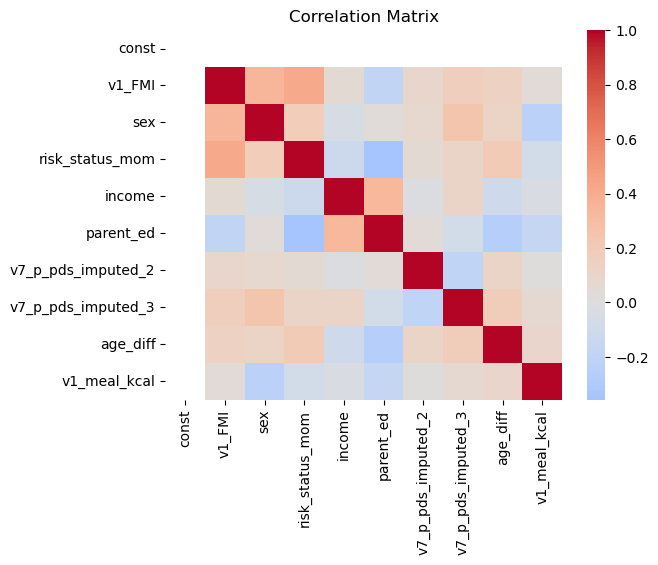

             Variable        VIF
0               const  16.313262
1              v1_FMI   1.407341
2                 sex   1.350147
3     risk_status_mom   1.386681
4              income   1.193322
5           parent_ed   1.406706
6  v7_p_pds_imputed_2   1.097055
7  v7_p_pds_imputed_3   1.218627
8            age_diff   1.154106
9        v1_meal_kcal   1.147865
CHECKING FOR HETEROSKEDASTICITY


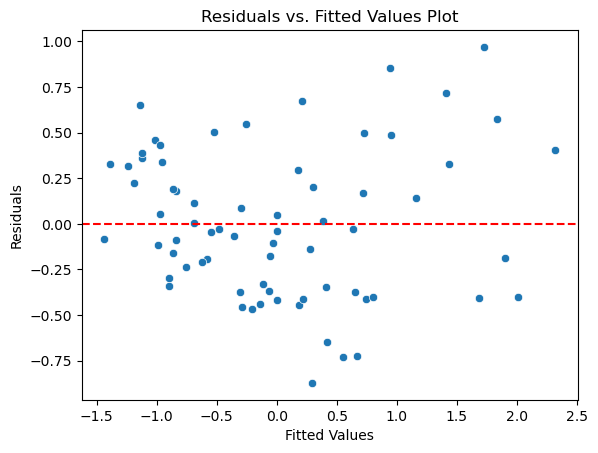

Breusch-Pagan test statistic: 15.920112190858154, p-value: 0.06856871211485396
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


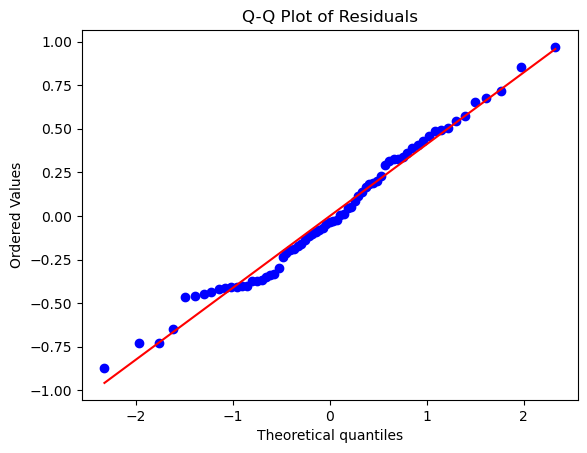

Shapiro-Wilk Test Results:
Statistic: 0.9824897050857544
p-value: 0.4453507363796234
Residuals are normally distributed (fail to reject null hypothesis)


In [28]:
# checking for model assumptions
# Calculate the residuals
residuals_mealkcalFMI= mod_mealkcalFMI.resid
# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealkcalFMI = durbin_watson(residuals_mealkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_mealkcalFMI)
if 0 < dw_statistic_mealkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealkcalFMI.values, i) for i in range(X_mealkcalFMI.shape[1])]
print(vif_data)

# 5. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealkcalFMI.fittedvalues, y=residuals_mealkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals_mealkcalFMI, mod_mealkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealkcalFMI, p_value_mealkcalFMI = shapiro(residuals_mealkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealkcalFMI)
print("p-value:", p_value_mealkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

# Assumption check for audio model

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.5611971939904519
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


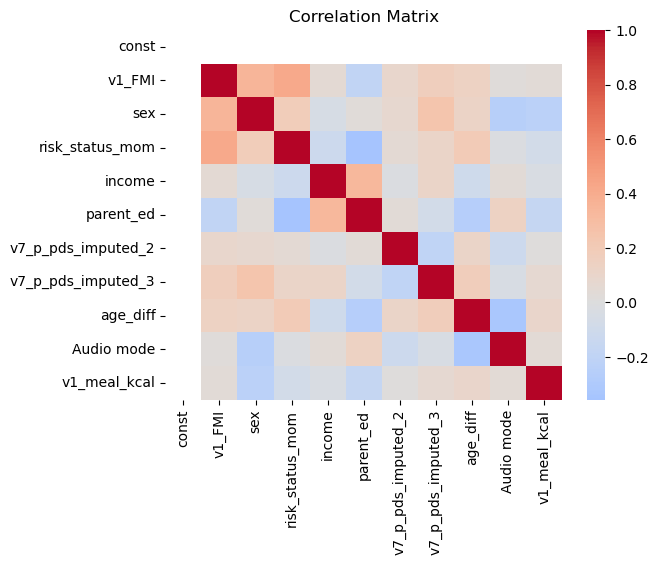

              Variable        VIF
0                const  16.778587
1               v1_FMI   1.443216
2                  sex   1.462492
3      risk_status_mom   1.393502
4               income   1.199205
5            parent_ed   1.439767
6   v7_p_pds_imputed_2   1.104207
7   v7_p_pds_imputed_3   1.222381
8             age_diff   1.264965
9           Audio mode   1.253735
10        v1_meal_kcal   1.148513
CHECKING FOR HETEROSKEDASTICITY


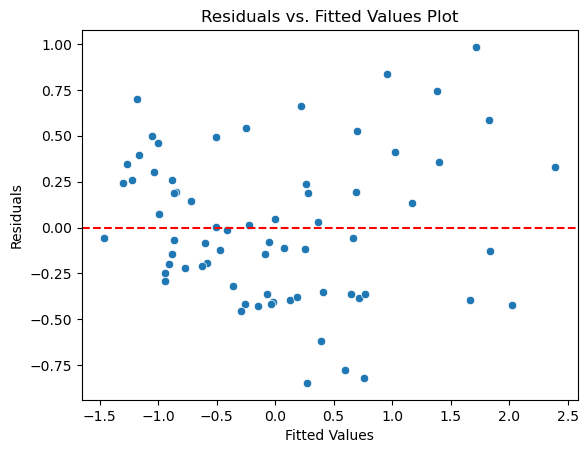

Breusch-Pagan test statistic: 15.37138620816667, p-value: 0.11909698957206706
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


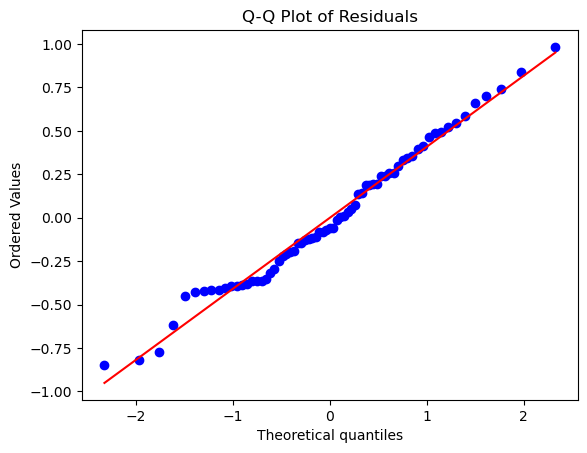

Shapiro-Wilk Test Results:
Statistic: 0.9822261333465576
p-value: 0.43255043029785156
Residuals are normally distributed (fail to reject null hypothesis)


In [29]:
# checking for model assumptions
# Calculate the residuals
residuals_mealkcalFMI_audio= mod_mealkcalFMI_audio.resid
# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealkcalFMI_audio = durbin_watson(residuals_mealkcalFMI_audio)
print("Durbin-Watson Statistic:", dw_statistic_mealkcalFMI_audio)
if 0 < dw_statistic_mealkcalFMI_audio < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealkcalFMI_audio.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealkcalFMI_audio.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealkcalFMI_audio.values, i) for i in range(X_mealkcalFMI_audio.shape[1])]
print(vif_data)

# 5. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealkcalFMI_audio.fittedvalues, y=residuals_mealkcalFMI_audio)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals_mealkcalFMI_audio, mod_mealkcalFMI_audio.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealkcalFMI_audio, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealkcalFMI_audio, p_value_mealkcalFMI_audio = shapiro(residuals_mealkcalFMI_audio)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealkcalFMI_audio)
print("p-value:", p_value_mealkcalFMI_audio)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealkcalFMI_audio > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH (kcal) at baseline (V1) vs V7 FMI
#### covariates baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH intake (kcal)

In [30]:
# Select specific columns as predictors (X) and response (y)

X_EAHkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','v1_eah_kcal']]
y_EAHkcalFMI = df_linear_reg['v7_FMI']


# Add a constant term to the predictors (intercept)
X_EAHkcalFMI = sm.add_constant(X_EAHkcalFMI)

# Fit a linear regression model using ols
mod_EAHkcalFMI = sm.OLS(y_EAHkcalFMI, X_EAHkcalFMI).fit()

# Get summary of the regression model
print(mod_EAHkcalFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     36.95
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           5.07e-21
Time:                        16:24:41   Log-Likelihood:                -32.617
No. Observations:                  69   AIC:                             85.23
Df Residuals:                      59   BIC:                             107.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2692      0

assumptions check for model

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.57130497617636
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


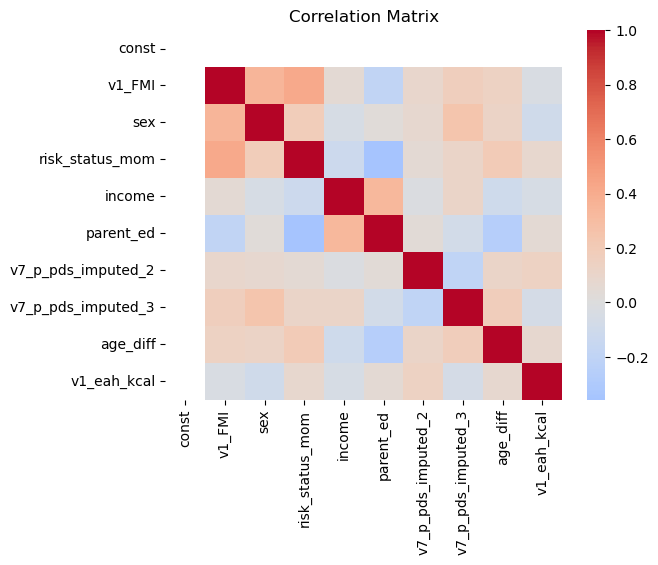

             Variable        VIF
0               const  15.656422
1              v1_FMI   1.385004
2                 sex   1.273138
3     risk_status_mom   1.377330
4              income   1.197079
5           parent_ed   1.402923
6  v7_p_pds_imputed_2   1.110803
7  v7_p_pds_imputed_3   1.203023
8            age_diff   1.154230
9         v1_eah_kcal   1.067134
CHECKING FOR HETEROSKEDASTICITY


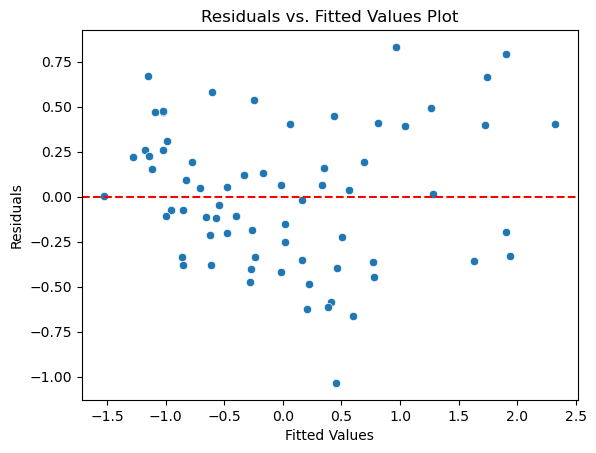

Breusch-Pagan test statistic: 13.796027168989605, p-value: 0.12976817746540312
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


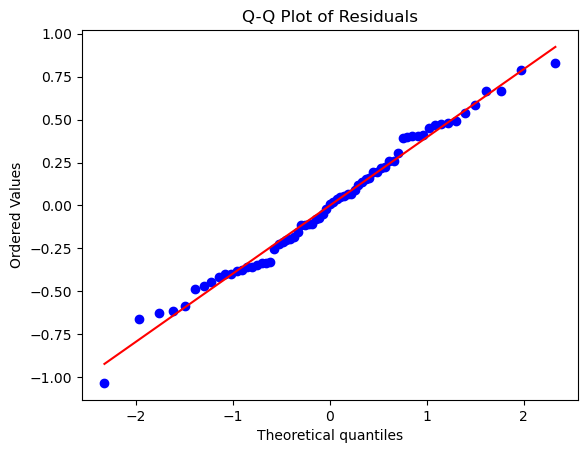

Shapiro-Wilk Test Results:
Statistic: 0.987616777420044
p-value: 0.7308404445648193
Residuals are normally distributed (fail to reject null hypothesis)


In [31]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHkcalFMI = mod_EAHkcalFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHkcalFMI = durbin_watson(residuals_EAHkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHkcalFMI)
if 0 < dw_statistic_EAHkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHkcalFMI.values, i) for i in range(X_EAHkcalFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHkcalFMI.fittedvalues, y=residuals_EAHkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHkcalFMI, mod_EAHkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")
    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHkcalFMI, p_value_EAHkcalFMI = shapiro(residuals_EAHkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHkcalFMI)
print("p-value:", p_value_EAHkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH Sweet (kcal) at baseline (V1) vs V7 FMI
#### covariates: baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1, main predictor: baseline EAH Sweet intake (kcal)

In [32]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_eah_sweet_kcal']]
y_EAHsweetkcalFMI = df_linear_reg['v7_FMI']
# Add a constant term to the predictors (intercept)
X_EAHsweetkcalFMI = sm.add_constant(X_EAHsweetkcalFMI)

# Fit a linear regression model using ols
mod_EAHsweetkcalFMI = sm.OLS(y_EAHsweetkcalFMI, X_EAHsweetkcalFMI).fit()

# Get summary of the regression model
print(mod_EAHsweetkcalFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     36.95
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           5.06e-21
Time:                        16:24:41   Log-Likelihood:                -32.615
No. Observations:                  69   AIC:                             85.23
Df Residuals:                      59   BIC:                             107.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2741      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.5620623983149309
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


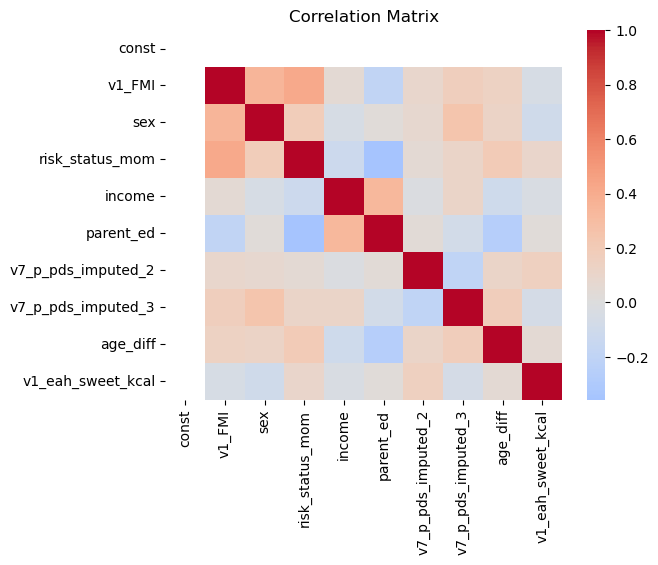

             Variable        VIF
0               const  15.671293
1              v1_FMI   1.389722
2                 sex   1.269437
3     risk_status_mom   1.385286
4              income   1.194130
5           parent_ed   1.392388
6  v7_p_pds_imputed_2   1.120038
7  v7_p_pds_imputed_3   1.202732
8            age_diff   1.148950
9   v1_eah_sweet_kcal   1.069630
CHECKING FOR HETEROSKEDASTICITY


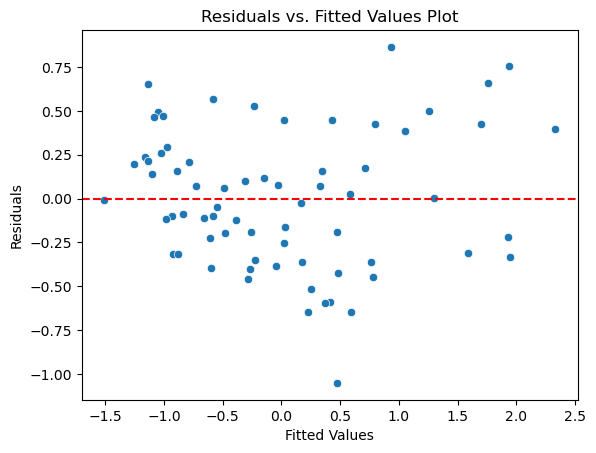

Breusch-Pagan test statistic: 14.665670461754223, p-value: 0.10053837413907275
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


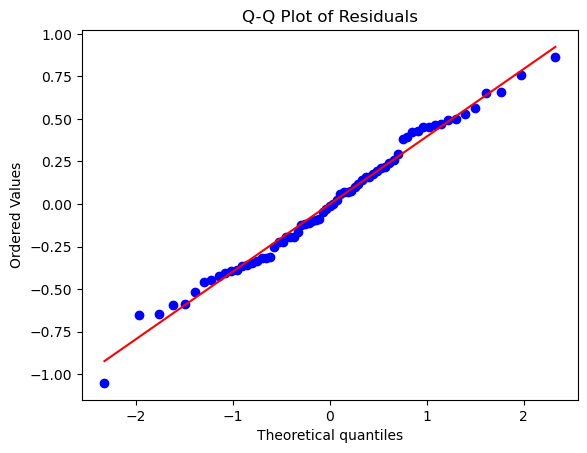

Shapiro-Wilk Test Results:
Statistic: 0.9884294271469116
p-value: 0.7772191166877747
Residuals are normally distributed (fail to reject null hypothesis)


In [33]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsweetkcalFMI = mod_EAHsweetkcalFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetkcalFMI = durbin_watson(residuals_EAHsweetkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetkcalFMI)
if 0 < dw_statistic_EAHsweetkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetkcalFMI.values, i) for i in range(X_EAHsweetkcalFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetkcalFMI.fittedvalues, y=residuals_EAHsweetkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetkcalFMI,  mod_EAHsweetkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetkcalFMI, p_value_EAHsweetkcalFMI = shapiro(residuals_EAHsweetkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetkcalFMI)
print("p-value:", p_value_EAHsweetkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Model : EAH savory (kcal) at baseline (V1) vs V7 FMI
#### covariates: baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH savory intake (kcal)

In [34]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','age_diff','v1_eah_sav_kcal']]
y_EAHsavkcalFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHsavkcalFMI = sm.add_constant(X_EAHsavkcalFMI)

# Fit a linear regression model using ols
mod_EAHsavkcalFMI = sm.OLS(y_EAHsavkcalFMI, X_EAHsavkcalFMI).fit()

# Get summary of the regression model
print(mod_EAHsavkcalFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     33.97
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.92e-20
Time:                        16:24:41   Log-Likelihood:                -35.061
No. Observations:                  69   AIC:                             90.12
Df Residuals:                      59   BIC:                             112.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2481      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.5710197491385056
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


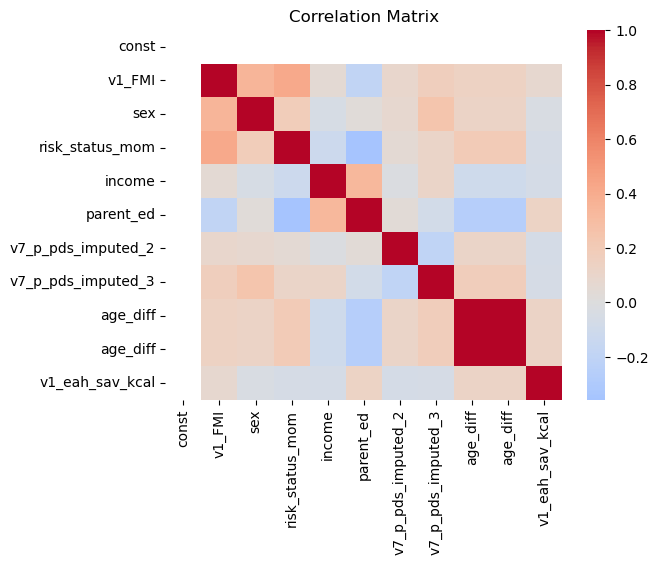

              Variable        VIF
0                const  15.668768
1               v1_FMI   1.423467
2                  sex   1.262835
3      risk_status_mom   1.360132
4               income   1.212679
5            parent_ed   1.443251
6   v7_p_pds_imputed_2   1.109895
7   v7_p_pds_imputed_3   1.209971
8             age_diff        inf
9             age_diff        inf
10     v1_eah_sav_kcal   1.107942
CHECKING FOR HETEROSKEDASTICITY


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


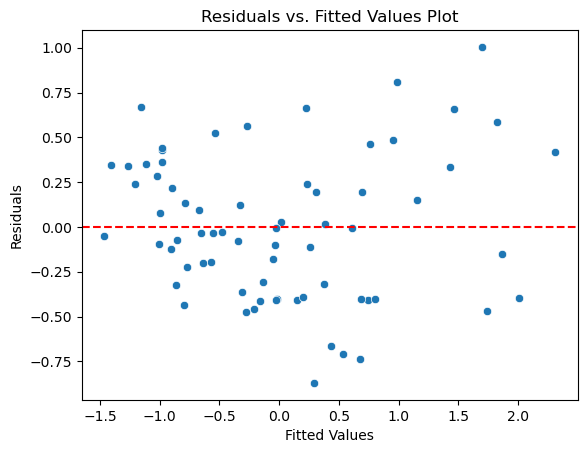

Breusch-Pagan test statistic: 16.350121648186146, p-value: 0.09003885093470114
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


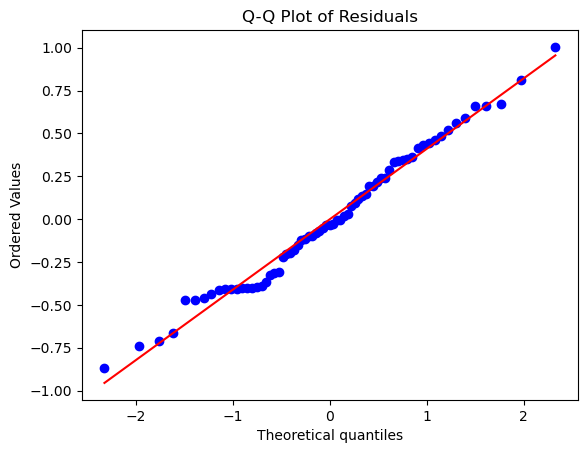

Shapiro-Wilk Test Results:
Statistic: 0.9837892055511475
p-value: 0.5120193362236023
Residuals are normally distributed (fail to reject null hypothesis)


In [35]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavkcalFMI = mod_EAHsavkcalFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavkcalFMI = durbin_watson(residuals_EAHsavkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavkcalFMI)
if 0 < dw_statistic_EAHsavkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavkcalFMI.values, i) for i in range(X_EAHsavkcalFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavkcalFMI.fittedvalues, y=residuals_EAHsavkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsavkcalFMI,  mod_EAHsavkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavkcalFMI, p_value_EAHsavkcalFMI = shapiro(residuals_EAHsavkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavkcalFMI)
print("p-value:", p_value_EAHsavkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsavkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

# Regression models : Baseline intake (kcal) vs follow-up weight status (BMIz)

### Model : Meal (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1, main predictor: baseline meal intake (kcal)

In [36]:
# Select specific columns as predictors (X) and response (y)
X_mealkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_meal_kcal']]
y_mealkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_mealkcalBMIz = sm.add_constant(X_mealkcalBMIz)

# Fit a linear regression model using ols
mod_mealkcalBMIz = sm.OLS(y_mealkcalBMIz, X_mealkcalBMIz).fit()

# Get summary of the regression model
print(mod_mealkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     37.73
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.02e-21
Time:                        16:24:42   Log-Likelihood:                -19.284
No. Observations:                  69   AIC:                             58.57
Df Residuals:                      59   BIC:                             80.91
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4527      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9916328373380847
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


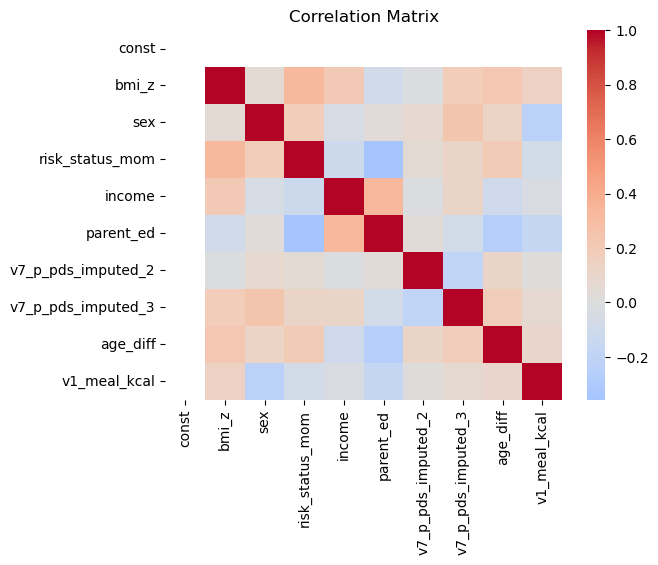

             Variable        VIF
0               const  17.281695
1               bmi_z   1.315390
2                 sex   1.215114
3     risk_status_mom   1.379542
4              income   1.254502
5           parent_ed   1.389664
6  v7_p_pds_imputed_2   1.093166
7  v7_p_pds_imputed_3   1.223422
8            age_diff   1.191612
9        v1_meal_kcal   1.161374
CHECKING FOR HETEROSKEDASTICITY


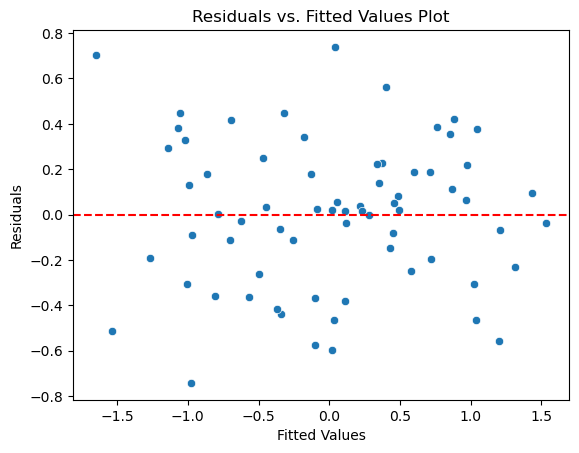

Breusch-Pagan test statistic: 13.325724743707084, p-value: 0.148412913439973
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


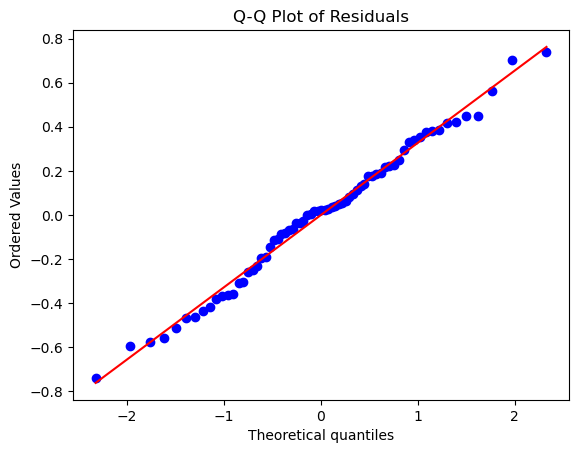

Shapiro-Wilk Test Results:
Statistic: 0.9888070821762085
p-value: 0.7981258630752563
Residuals are normally distributed (fail to reject null hypothesis)


In [37]:
# checking for model assumptions
# Calculate the residuals
residuals_mealkcalBMIz= mod_mealkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealkcalBMIz = durbin_watson(residuals_mealkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_mealkcalBMIz)
if 0 < dw_statistic_mealkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealkcalBMIz.values, i) for i in range(X_mealkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealkcalBMIz.fittedvalues, y=residuals_mealkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_mealkcalBMIz,  mod_mealkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealkcalBMIz, p_value_mealkcalBMIz = shapiro(residuals_mealkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealkcalBMIz)
print("p-value:", p_value_mealkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Model : EAH (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH intake (kcal)

In [38]:
# Select specific columns as predictors (X) and response (y)
X_EAHkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_eah_kcal']]
y_EAHkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHkcalBMIz = sm.add_constant(X_EAHkcalBMIz)

# Fit a linear regression model using ols
mod_EAHkcalBMIz = sm.OLS(y_EAHkcalBMIz, X_EAHkcalBMIz).fit()

# Get summary of the regression model
print(mod_EAHkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     38.89
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.43e-21
Time:                        16:24:42   Log-Likelihood:                -18.395
No. Observations:                  69   AIC:                             56.79
Df Residuals:                      59   BIC:                             79.13
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4697      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9343816514076428
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


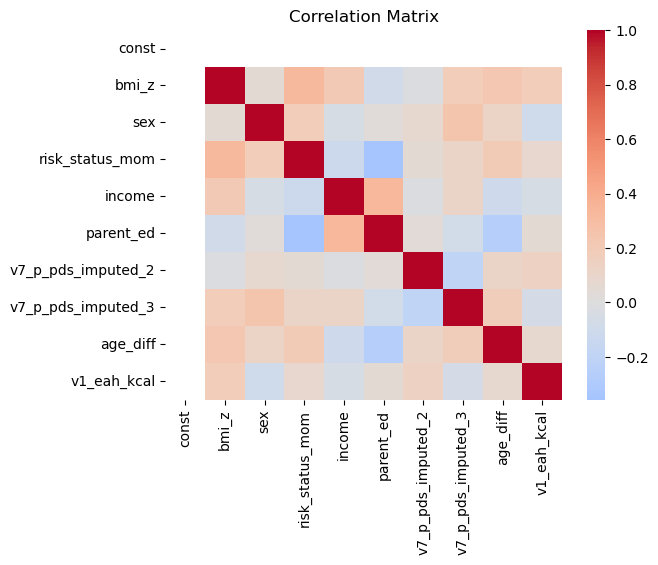

             Variable        VIF
0               const  16.440357
1               bmi_z   1.324681
2                 sex   1.167539
3     risk_status_mom   1.347923
4              income   1.268299
5           parent_ed   1.381840
6  v7_p_pds_imputed_2   1.106496
7  v7_p_pds_imputed_3   1.211184
8            age_diff   1.191183
9         v1_eah_kcal   1.104855
CHECKING FOR HETEROSKEDASTICITY


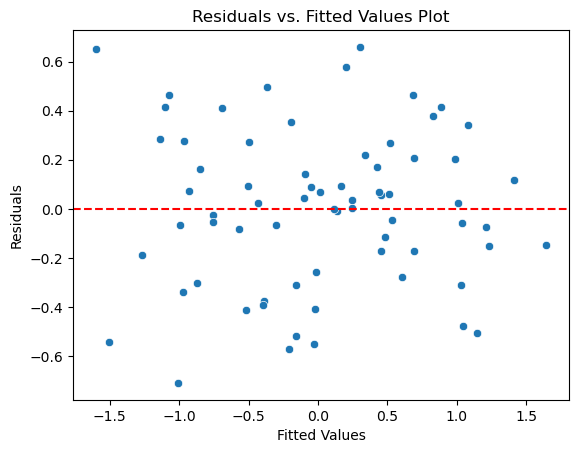

Breusch-Pagan test statistic: 13.893399393312668, p-value: 0.12616806722908064
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


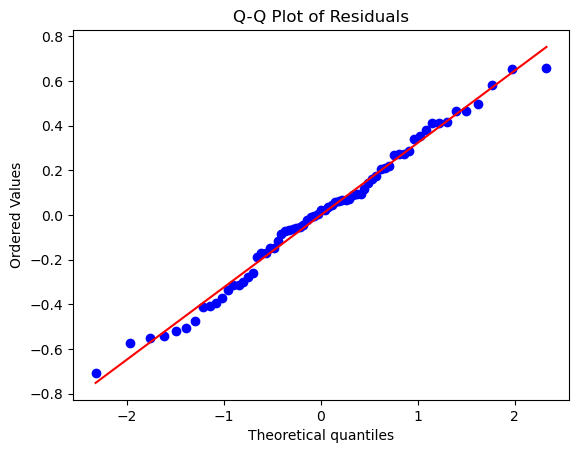

Shapiro-Wilk Test Results:
Statistic: 0.9863560795783997
p-value: 0.6571502089500427
Residuals are normally distributed (fail to reject null hypothesis)


In [39]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHkcalBMIz = mod_EAHkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHkcalBMIz = durbin_watson(residuals_EAHkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHkcalBMIz)
if 0 < dw_statistic_EAHkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHkcalBMIz.values, i) for i in range(X_EAHkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHkcalBMIz.fittedvalues, y=residuals_EAHkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHkcalBMIz,  mod_EAHkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")


# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHkcalBMIz, p_value_EAHkcalBMIz = shapiro(residuals_EAHkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHkcalBMIz)
print("p-value:", p_value_EAHkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Model : EAH sweet (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH sweet intake (kcal)

In [40]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','v1_eah_sweet_kcal']]
y_EAHsweetkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsweetkcalBMIz = sm.add_constant(X_EAHsweetkcalBMIz)

# Fit a linear regression model using ols
mod_EAHsweetkcalBMIz= sm.OLS(y_EAHsweetkcalBMIz, X_EAHsweetkcalBMIz).fit()

# Get summary of the regression model
print(mod_EAHsweetkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     39.15
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.21e-21
Time:                        16:24:42   Log-Likelihood:                -18.197
No. Observations:                  69   AIC:                             56.39
Df Residuals:                      59   BIC:                             78.74
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4709      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9110666121633892
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


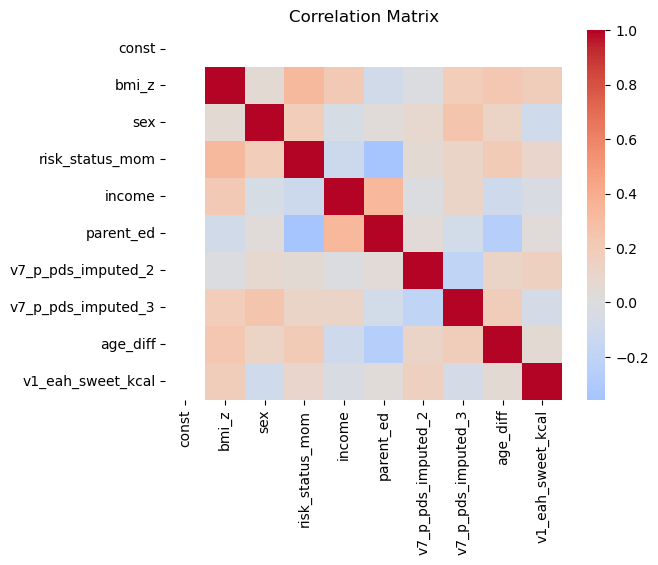

             Variable        VIF
0               const  16.434201
1               bmi_z   1.318536
2                 sex   1.167075
3     risk_status_mom   1.350414
4              income   1.262578
5           parent_ed   1.371564
6  v7_p_pds_imputed_2   1.114961
7  v7_p_pds_imputed_3   1.210216
8            age_diff   1.188724
9   v1_eah_sweet_kcal   1.098560
CHECKING FOR HETEROSKEDASTICITY


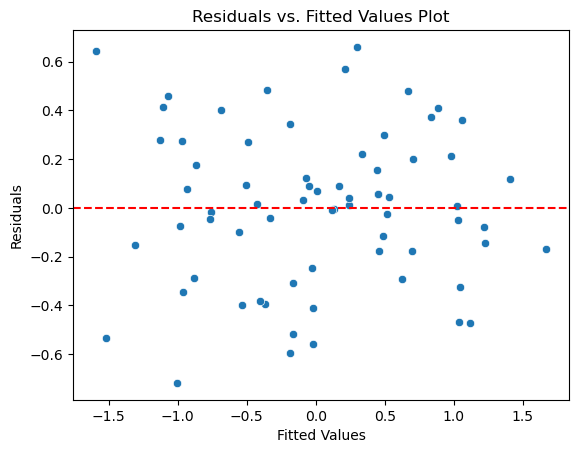

Breusch-Pagan test statistic: 14.007645036588249, p-value: 0.12205353904040696
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


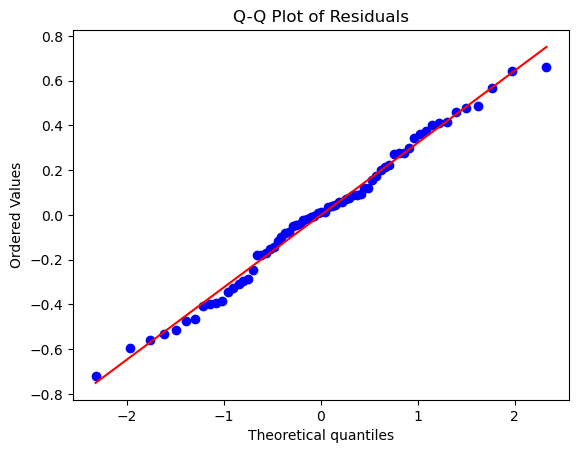

Shapiro-Wilk Test Results:
Statistic: 0.9874260425567627
p-value: 0.7197630405426025
Residuals are normally distributed (fail to reject null hypothesis)


In [41]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsweetkcalBMIz= mod_EAHsweetkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetkcalBMIz = durbin_watson(residuals_EAHsweetkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetkcalBMIz)
if 0 < dw_statistic_EAHsweetkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetkcalBMIz.values, i) for i in range(X_EAHsweetkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetkcalBMIz.fittedvalues, y=residuals_EAHsweetkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetkcalBMIz,  mod_EAHsweetkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetkcalBMIz, p_value_EAHsweetkcalBMIz = shapiro(residuals_EAHsweetkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetkcalBMIz)
print("p-value:", p_value_EAHsweetkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Model : EAH savory (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates :baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1, main predictor: baseline EAH savory intake (kcal)

In [42]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_eah_sav_kcal']]
y_EAHsavkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsavkcalBMIz = sm.add_constant(X_EAHsavkcalBMIz)

# Fit a linear regression model using ols
mod_EAHsavkcalBMIz= sm.OLS(y_EAHsavkcalBMIz, X_EAHsavkcalBMIz).fit()

# Get summary of the regression model
print(mod_EAHsavkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     37.49
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.54e-21
Time:                        16:24:43   Log-Likelihood:                -19.476
No. Observations:                  69   AIC:                             58.95
Df Residuals:                      59   BIC:                             81.29
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4782      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9646431408668086
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


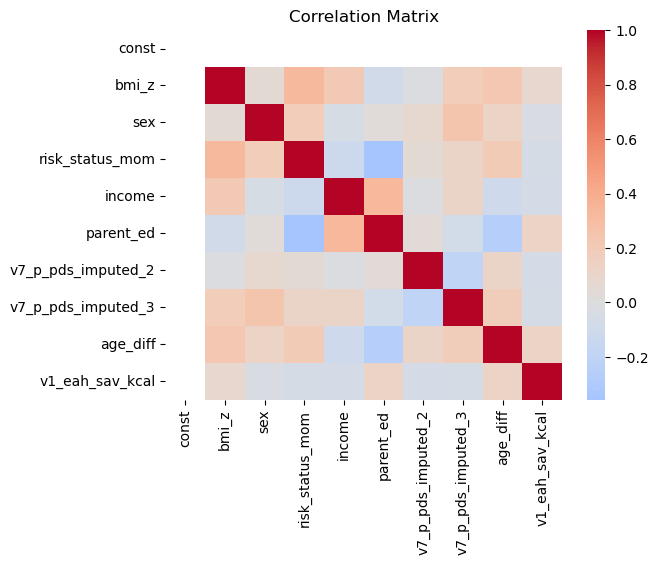

             Variable        VIF
0               const  16.454979
1               bmi_z   1.294366
2                 sex   1.147057
3     risk_status_mom   1.345114
4              income   1.271963
5           parent_ed   1.406899
6  v7_p_pds_imputed_2   1.099962
7  v7_p_pds_imputed_3   1.217080
8            age_diff   1.222070
9     v1_eah_sav_kcal   1.090568
CHECKING FOR HETEROSKEDASTICITY


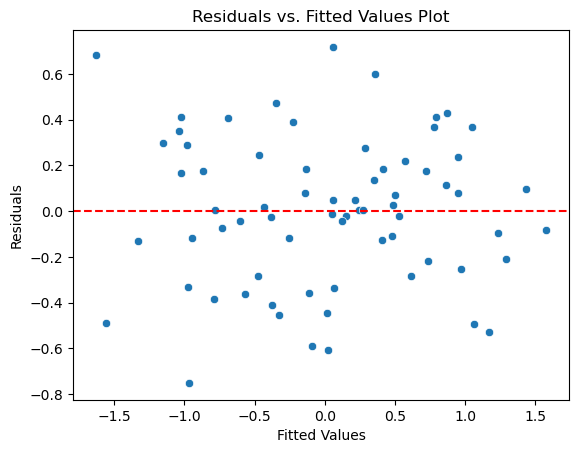

Breusch-Pagan test statistic: 13.491297771621765, p-value: 0.1416061639505836
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


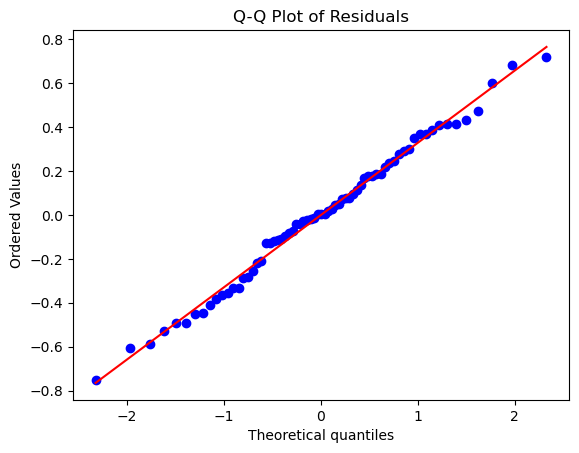

Shapiro-Wilk Test Results:
Statistic: 0.9901065826416016
p-value: 0.8650088906288147
Residuals are normally distributed (fail to reject null hypothesis)


In [43]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavkcalBMIz= mod_EAHsavkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavkcalBMIz = durbin_watson(residuals_EAHsavkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavkcalBMIz)
if 0 < dw_statistic_EAHsavkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavkcalBMIz.values, i) for i in range(X_EAHsavkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavkcalBMIz.fittedvalues, y=residuals_EAHsavkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsavkcalBMIz,  mod_EAHsavkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")
    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavkcalBMIz, p_value_EAHsavkcalBMIz = shapiro(residuals_EAHsavkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavkcalBMIz)
print("p-value:", p_value_EAHsavkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsavkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Regression model: Intake (gram) at baseline V1 vs follow-up adiposity (FMI)

### Model : Meal (gram) at baseline (V1) vs V7 follow-up adiposity FMI
#### covariates : baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1, main predictor: baseline meal intake (gram)

In [44]:
# Select specific columns as predictors (X) and response (y)
X_mealgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_meal_g']]
y_mealgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_mealgFMI = sm.add_constant(X_mealgFMI)

# Fit a linear regression model using ols
mod_mealgFMI= sm.OLS(y_mealgFMI, X_mealgFMI).fit()

# Get summary of the regression model
print(mod_mealgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     33.75
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           4.57e-20
Time:                        16:24:43   Log-Likelihood:                -35.245
No. Observations:                  69   AIC:                             90.49
Df Residuals:                      59   BIC:                             112.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2492      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.5518057678245332
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


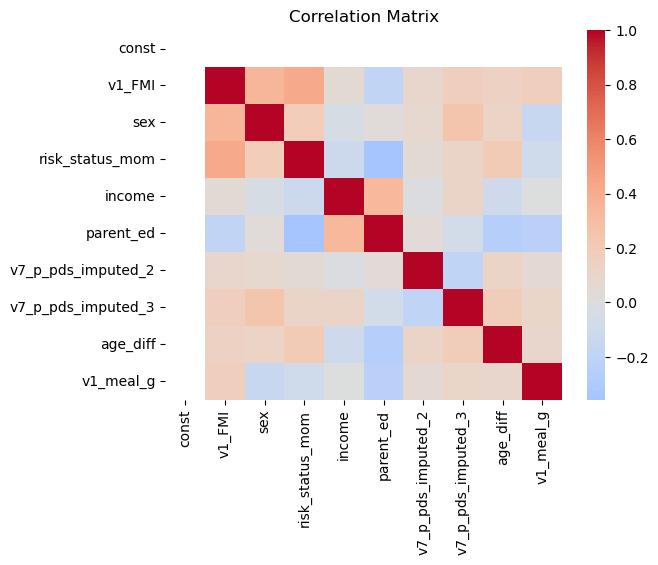

             Variable        VIF
0               const  16.618596
1              v1_FMI   1.483763
2                 sex   1.320584
3     risk_status_mom   1.461087
4              income   1.192176
5           parent_ed   1.470213
6  v7_p_pds_imputed_2   1.106010
7  v7_p_pds_imputed_3   1.226111
8            age_diff   1.147797
9           v1_meal_g   1.249836
CHECKING FOR HETEROSKEDASTICITY


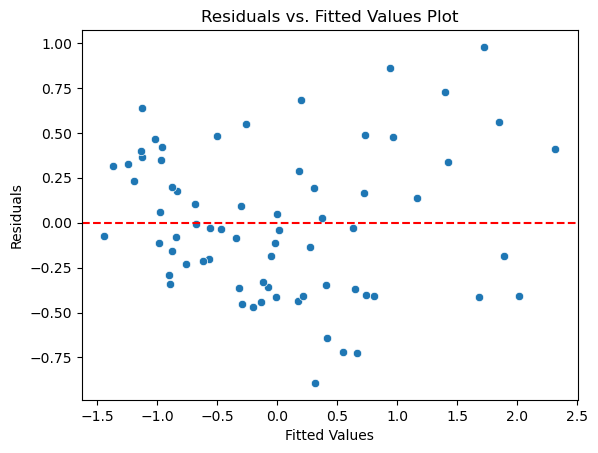

Breusch-Pagan test statistic: 15.966679830058151, p-value: 0.06758066877091383
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


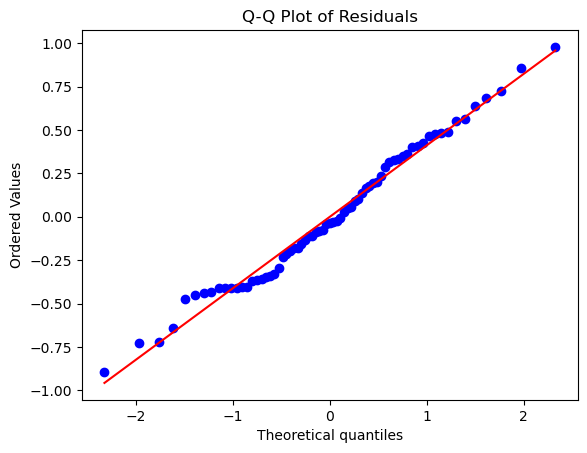

Shapiro-Wilk Test Results:
Statistic: 0.9830450415611267
p-value: 0.47313380241394043
Residuals are normally distributed (fail to reject null hypothesis)


In [45]:
# checking for model assumptions
# Calculate the residuals
residuals_mealgFMI= mod_mealgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealgFMI = durbin_watson(residuals_mealgFMI)
print("Durbin-Watson Statistic:", dw_statistic_mealgFMI)
if 0 < dw_statistic_mealgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealgFMI.values, i) for i in range(X_mealgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealgFMI.fittedvalues, y=residuals_mealgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_mealgFMI,  mod_mealgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealgFMI, p_value_mealgFMI = shapiro(residuals_mealgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealgFMI)
print("p-value:", p_value_mealgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH (gram) at baseline (V1) vs V7 follow-up adiposity FMI (v7)
#### covariates :baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH intake (gram)

In [46]:
# Select specific columns as predictors (X) and response (y)
X_EAHgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff','v1_eah_g']]
y_EAHgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHgFMI = sm.add_constant(X_EAHgFMI)

# Fit a linear regression model using ols
mod_EAHgFMI= sm.OLS(y_EAHgFMI, X_EAHgFMI).fit()

# Get summary of the regression model
print(mod_EAHgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     35.05
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.84e-20
Time:                        16:24:44   Log-Likelihood:                -34.157
No. Observations:                  69   AIC:                             88.31
Df Residuals:                      59   BIC:                             110.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2554      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.5289900097211984
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


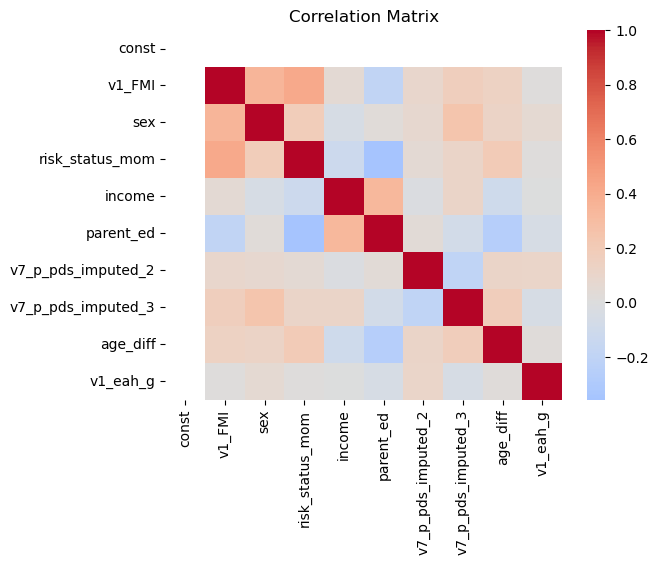

             Variable        VIF
0               const  15.636643
1              v1_FMI   1.384393
2                 sex   1.258613
3     risk_status_mom   1.354514
4              income   1.193173
5           parent_ed   1.389160
6  v7_p_pds_imputed_2   1.104680
7  v7_p_pds_imputed_3   1.206120
8            age_diff   1.146066
9            v1_eah_g   1.022696
CHECKING FOR HETEROSKEDASTICITY


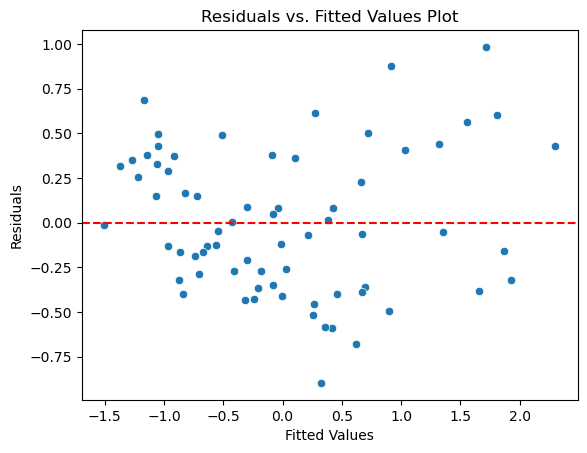

Breusch-Pagan test statistic: 15.992415033805749, p-value: 0.06704015073970863
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


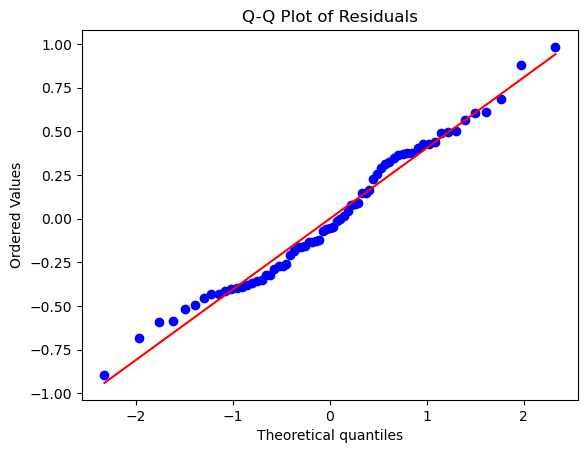

Shapiro-Wilk Test Results:
Statistic: 0.9798271656036377
p-value: 0.3281676471233368
Residuals are normally distributed (fail to reject null hypothesis)


In [47]:
# checking for model assumptions 
# Calculate the residuals
residuals_EAHgFMI= mod_EAHgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHgFMI = durbin_watson(residuals_EAHgFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHgFMI)
if 0 < dw_statistic_EAHgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHgFMI.values, i) for i in range(X_EAHgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHgFMI.fittedvalues, y=residuals_EAHgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHgFMI,  mod_EAHgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")


# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHgFMI, p_value_EAHgFMI = shapiro(residuals_EAHgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHgFMI)
print("p-value:", p_value_EAHgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH sweet (gram) at baseline (V1) vs V7 follow-up adiposity FMI (v7)
#### covariates : baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH sweet intake (gram)

In [48]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','v1_eah_sweet_g']]
y_EAHsweetgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHsweetgFMI = sm.add_constant(X_EAHsweetgFMI)

# Fit a linear regression model using ols
mod_EAHsweetgFMI= sm.OLS(y_EAHsweetgFMI, X_EAHsweetgFMI).fit()

# Get summary of the regression model
print(mod_EAHsweetgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     37.55
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.41e-21
Time:                        16:24:44   Log-Likelihood:                -32.144
No. Observations:                  69   AIC:                             84.29
Df Residuals:                      59   BIC:                             106.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2689      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.4906441793238991
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


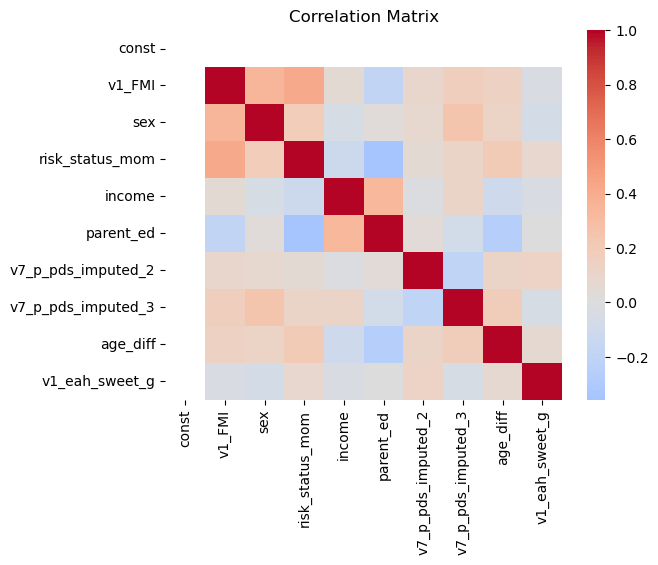

             Variable        VIF
0               const  15.652822
1              v1_FMI   1.387425
2                 sex   1.261059
3     risk_status_mom   1.370696
4              income   1.192838
5           parent_ed   1.385894
6  v7_p_pds_imputed_2   1.109622
7  v7_p_pds_imputed_3   1.202926
8            age_diff   1.150245
9      v1_eah_sweet_g   1.042284
CHECKING FOR HETEROSKEDASTICITY


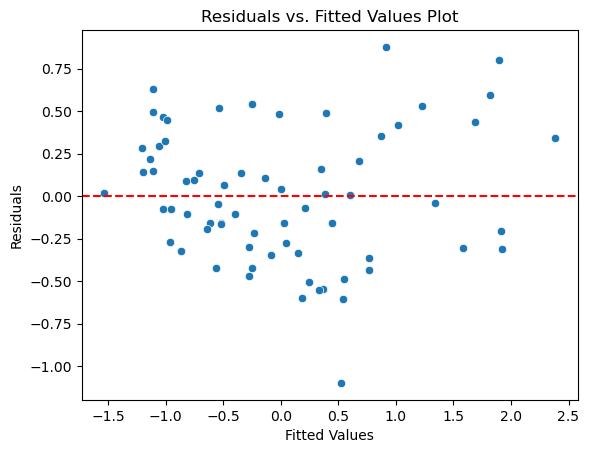

Breusch-Pagan test statistic: 15.460100173986477, p-value: 0.07904859422426959
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


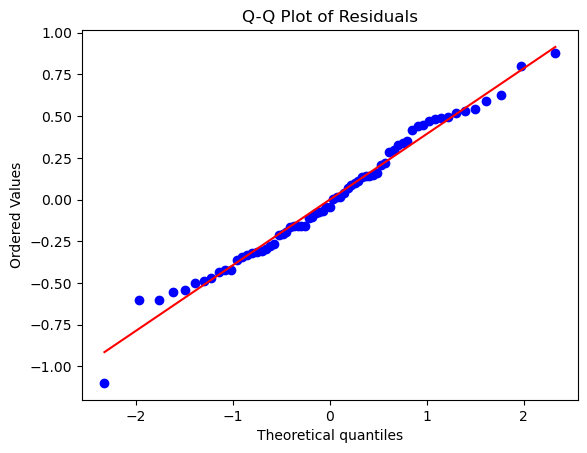

Shapiro-Wilk Test Results:
Statistic: 0.9856287837028503
p-value: 0.6148013472557068
Residuals are normally distributed (fail to reject null hypothesis)


In [49]:
# checking for model assumptions
# Calculate the residuals
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
residuals_EAHsweetgFMI= mod_EAHsweetgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetgFMI = durbin_watson(residuals_EAHsweetgFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetgFMI)
if 0 < dw_statistic_EAHsweetgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetgFMI.values, i) for i in range(X_EAHsweetgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetgFMI.fittedvalues, y=residuals_EAHsweetgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetgFMI,  mod_EAHsweetgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")   
    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetgFMI, p_value_EAHsweetgFMI = shapiro(residuals_EAHsweetgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetgFMI)
print("p-value:", p_value_EAHsweetgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH savory (gram) at baseline (V1) vs V7 follow-up adiposity FMI (v7)
#### covariates : baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH savory intake (gram)

In [50]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','v1_eah_sav_g']]
y_EAHsavgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHsavgFMI = sm.add_constant(X_EAHsavgFMI)

# Fit a linear regression model using ols
mod_EAHsavgFMI= sm.OLS(y_EAHsavgFMI, X_EAHsavgFMI).fit()

# Get summary of the regression model
print(mod_EAHsavgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     33.96
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.96e-20
Time:                        16:24:44   Log-Likelihood:                -35.073
No. Observations:                  69   AIC:                             90.15
Df Residuals:                      59   BIC:                             112.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2492      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.5697989020840775
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


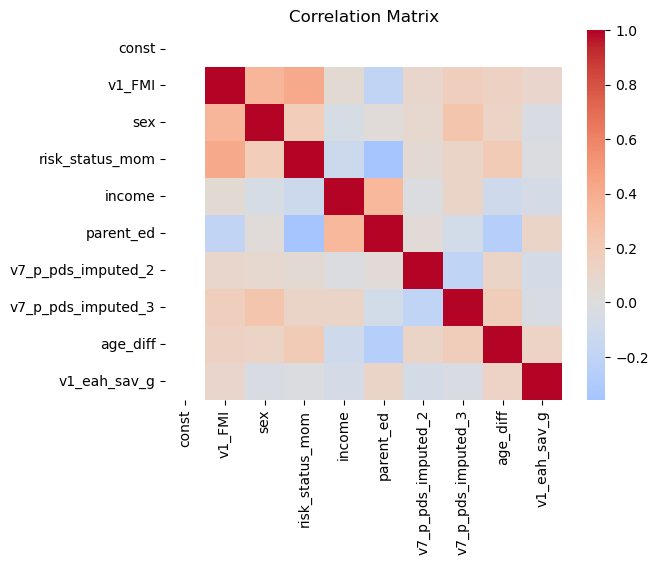

             Variable        VIF
0               const  15.658473
1              v1_FMI   1.426330
2                 sex   1.264574
3     risk_status_mom   1.355570
4              income   1.212779
5           parent_ed   1.444037
6  v7_p_pds_imputed_2   1.111299
7  v7_p_pds_imputed_3   1.206796
8            age_diff   1.186454
9        v1_eah_sav_g   1.104244
CHECKING FOR HETEROSKEDASTICITY


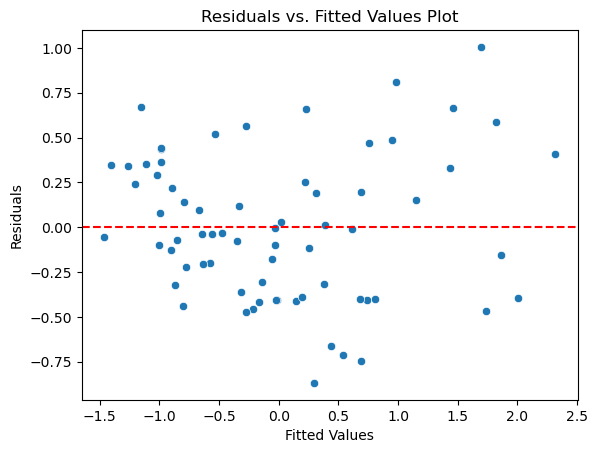

Breusch-Pagan test statistic: 16.273745293182134, p-value: 0.06138050347153616
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


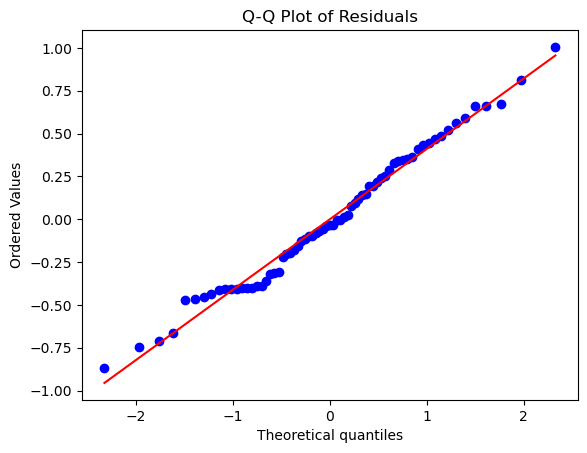

Shapiro-Wilk Test Results:
Statistic: 0.9837973117828369
p-value: 0.5124531388282776
Residuals are normally distributed (fail to reject null hypothesis)


In [51]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavgFMI= mod_EAHsavgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavgFMI = durbin_watson(residuals_EAHsavgFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavgFMI)
if 0 < dw_statistic_EAHsavgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavgFMI.values, i) for i in range(X_EAHsavgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavgFMI.fittedvalues, y=residuals_EAHsavgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsavgFMI,  mod_EAHsavgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavgFMI, p_value_EAHsavgFMI = shapiro(residuals_EAHsavgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavgFMI)
print("p-value:", p_value_EAHsavgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level 
if p_value_EAHsavgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Regression models: Intake (gram) at baseline (v1) vs follow-up (v7) weight status (BMIz)

### Model : Meal (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline meal intake (gram)

In [52]:
# Select specific columns as predictors (X) and response (y)
X_mealgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff','v1_meal_g']]
y_mealgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_mealgBMIz= sm.add_constant(X_mealgBMIz)

# Fit a linear regression model using ols
mod_mealgBMIz= sm.OLS(y_mealgBMIz, X_mealgBMIz).fit()

# Get summary of the regression model
print(mod_mealgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     37.92
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           2.68e-21
Time:                        16:24:45   Log-Likelihood:                -19.142
No. Observations:                  69   AIC:                             58.28
Df Residuals:                      59   BIC:                             80.62
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4365      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.956900497192526
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


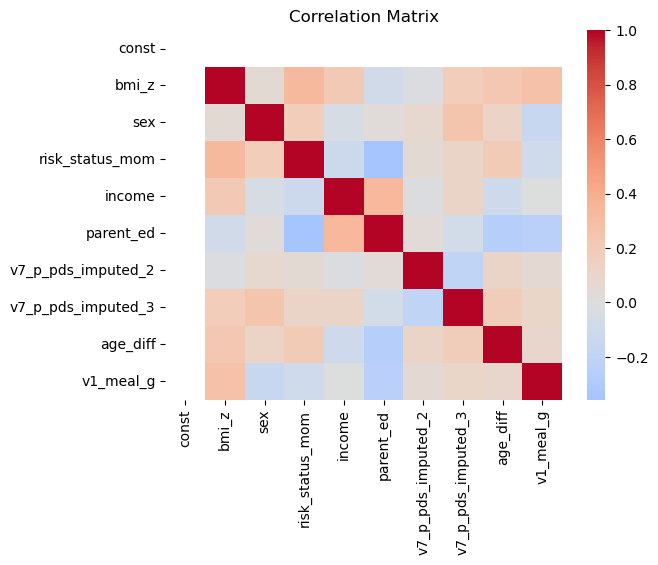

             Variable        VIF
0               const  17.899722
1               bmi_z   1.437573
2                 sex   1.171437
3     risk_status_mom   1.470498
4              income   1.252237
5           parent_ed   1.476537
6  v7_p_pds_imputed_2   1.109214
7  v7_p_pds_imputed_3   1.228400
8            age_diff   1.189149
9           v1_meal_g   1.310823
CHECKING FOR HETEROSKEDASTICITY


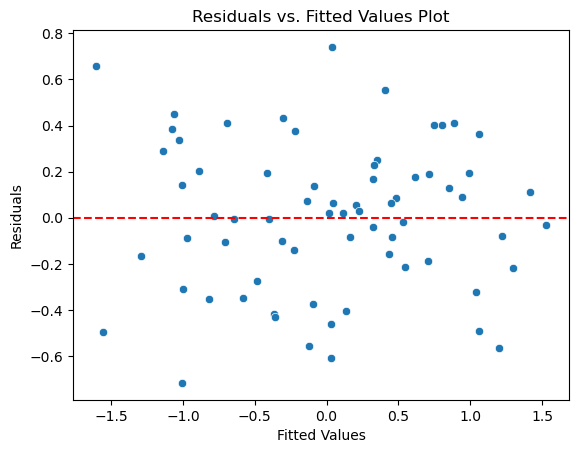

Breusch-Pagan test statistic: 13.296502368865234, p-value: 0.1496423768656752
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


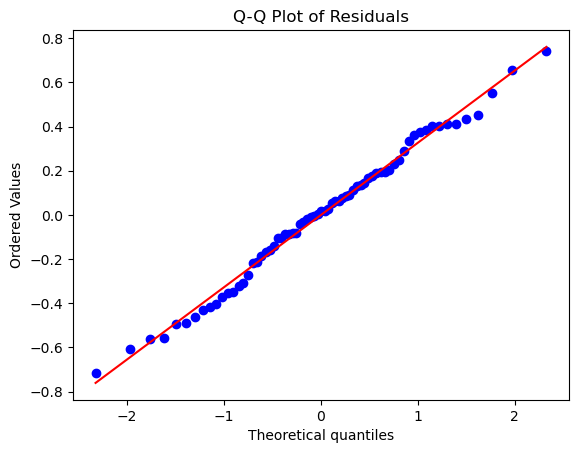

Shapiro-Wilk Test Results:
Statistic: 0.989029586315155
p-value: 0.8101848363876343
Residuals are normally distributed (fail to reject null hypothesis)


In [53]:
# checking for model assumptions
# Calculate the residuals
residuals_mealgBMIz= mod_mealgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealgBMIz = durbin_watson(residuals_mealgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_mealgBMIz)
if 0 < dw_statistic_mealgBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealgBMIz.values, i) for i in range(X_mealgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealgBMIz.fittedvalues, y=residuals_mealgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_mealgBMIz,  mod_mealgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  
      
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealgBMIz, p_value_mealgBMIz = shapiro(residuals_mealgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealgBMIz)
print("p-value:", p_value_mealgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH intake (gram)

In [54]:
# Select specific columns as predictors (X) and response (y)
X_EAHgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_eah_g']]
y_EAHgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHgBMIz= sm.add_constant(X_EAHgBMIz)

# Fit a linear regression model using ols
mod_EAHgBMIz= sm.OLS(y_EAHgBMIz, X_EAHgBMIz).fit()

# Get summary of the regression model
print(mod_EAHgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     40.72
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           4.55e-22
Time:                        16:24:45   Log-Likelihood:                -17.029
No. Observations:                  69   AIC:                             54.06
Df Residuals:                      59   BIC:                             76.40
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4765      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.936486715754711
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


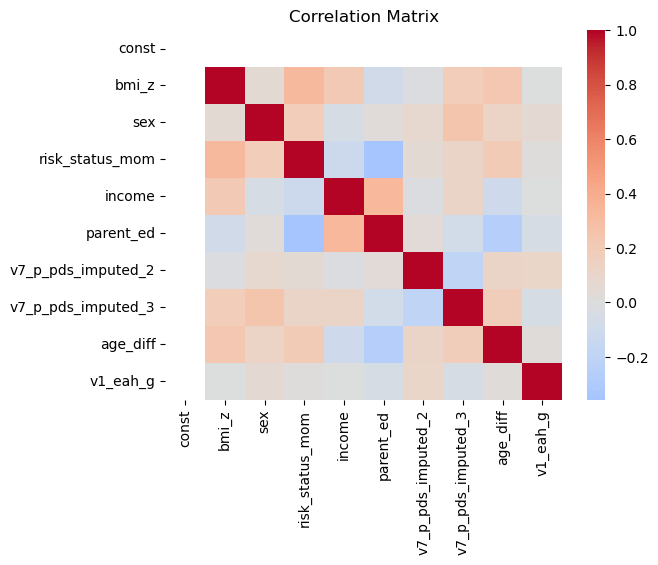

             Variable        VIF
0               const  16.425773
1               bmi_z   1.278426
2                 sex   1.150809
3     risk_status_mom   1.343060
4              income   1.251145
5           parent_ed   1.364906
6  v7_p_pds_imputed_2   1.098620
7  v7_p_pds_imputed_3   1.213319
8            age_diff   1.188474
9            v1_eah_g   1.022324
CHECKING FOR HETEROSKEDASTICITY


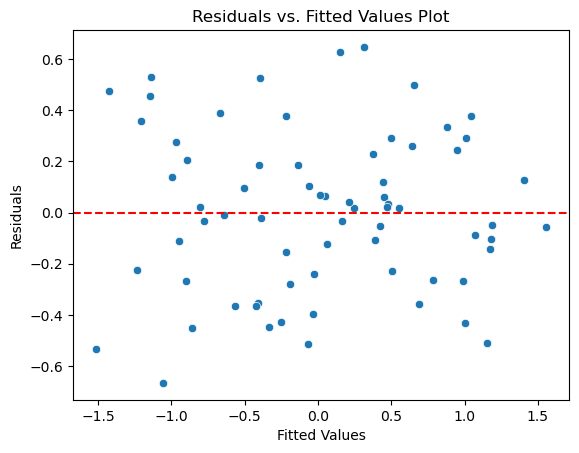

Breusch-Pagan test statistic: 13.579320977406313, p-value: 0.1380961648205715
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


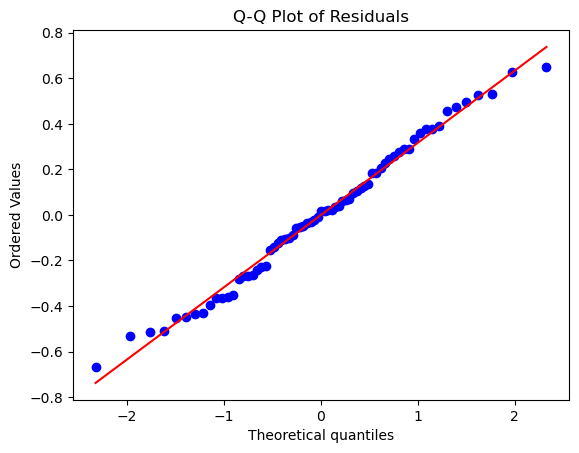

Shapiro-Wilk Test Results:
Statistic: 0.9853368997573853
p-value: 0.5979943871498108
Residuals are normally distributed (fail to reject null hypothesis)


In [55]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHgBMIz= mod_EAHgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHgBMIz = durbin_watson(residuals_EAHgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHgBMIz)
if 0 < dw_statistic_EAHgBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHgBMIz.values, i) for i in range(X_EAHgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHgBMIz.fittedvalues, y=residuals_EAHgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHgBMIz,  mod_EAHgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  
      
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHgBMIz, p_value_EAHgBMIz = shapiro(residuals_EAHgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHgBMIz)
print("p-value:", p_value_EAHgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH sweet (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates :baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH sweet intake (gram)

In [56]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_eah_sweet_g']]
y_EAHsweetgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsweetgBMIz= sm.add_constant(X_EAHsweetgBMIz)

# Fit a linear regression model using ols
mod_EAHsweetgBMIz= sm.OLS(y_EAHsweetgBMIz, X_EAHsweetgBMIz).fit()

# Get summary of the regression model
print(mod_EAHsweetgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     39.70
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           8.60e-22
Time:                        16:24:45   Log-Likelihood:                -17.788
No. Observations:                  69   AIC:                             55.58
Df Residuals:                      59   BIC:                             77.92
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4634      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.855210480627998
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


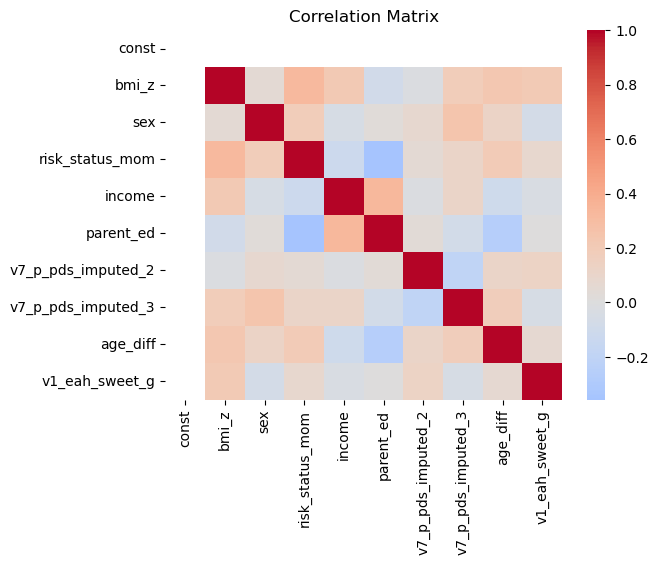

             Variable        VIF
0               const  16.460631
1               bmi_z   1.338389
2                 sex   1.156224
3     risk_status_mom   1.343392
4              income   1.260893
5           parent_ed   1.363789
6  v7_p_pds_imputed_2   1.105117
7  v7_p_pds_imputed_3   1.211254
8            age_diff   1.188863
9      v1_eah_sweet_g   1.088391
CHECKING FOR HETEROSKEDASTICITY


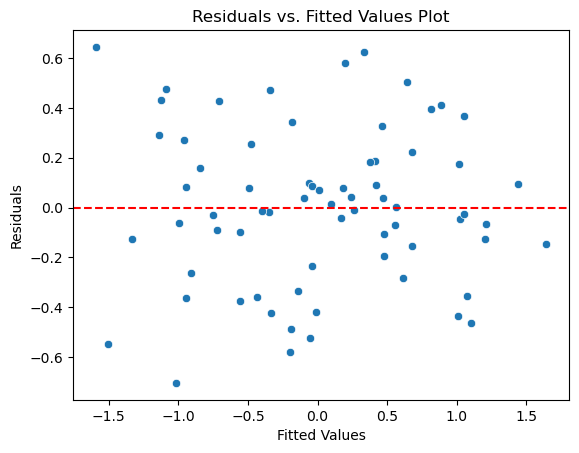

Breusch-Pagan test statistic: 15.088252420973019, p-value: 0.08854018420457146
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


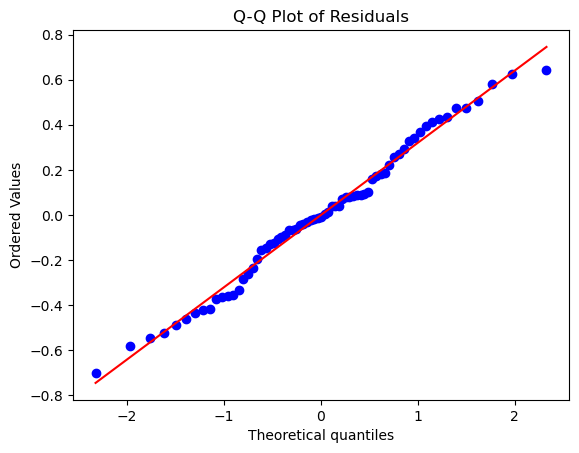

Shapiro-Wilk Test Results:
Statistic: 0.9847161173820496
p-value: 0.5627971887588501
Residuals are normally distributed (fail to reject null hypothesis)


In [57]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsweetgBMIz= mod_EAHsweetgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetgBMIz = durbin_watson(residuals_EAHsweetgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetgBMIz)
if 0 < dw_statistic_EAHsweetgBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetgBMIz.values, i) for i in range(X_EAHsweetgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetgBMIz.fittedvalues, y=residuals_EAHsweetgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetgBMIz,  mod_EAHsweetgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  
      

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetgBMIz, p_value_EAHsweetgBMIz = shapiro(residuals_EAHsweetgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetgBMIz)
print("p-value:", p_value_EAHsweetgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH savory (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH savory intake (gram)

In [58]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff', 'v1_eah_sav_g']]
y_EAHsavgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsavgBMIz= sm.add_constant(X_EAHsavgBMIz)

# Fit a linear regression model using ols
mod_EAHsavgBMIz= sm.OLS(y_EAHsavgBMIz, X_EAHsavgBMIz).fit()

# Get summary of the regression model
print(mod_EAHsavgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     37.46
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.60e-21
Time:                        16:24:46   Log-Likelihood:                -19.494
No. Observations:                  69   AIC:                             58.99
Df Residuals:                      59   BIC:                             81.33
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4774      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9690007390247022
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


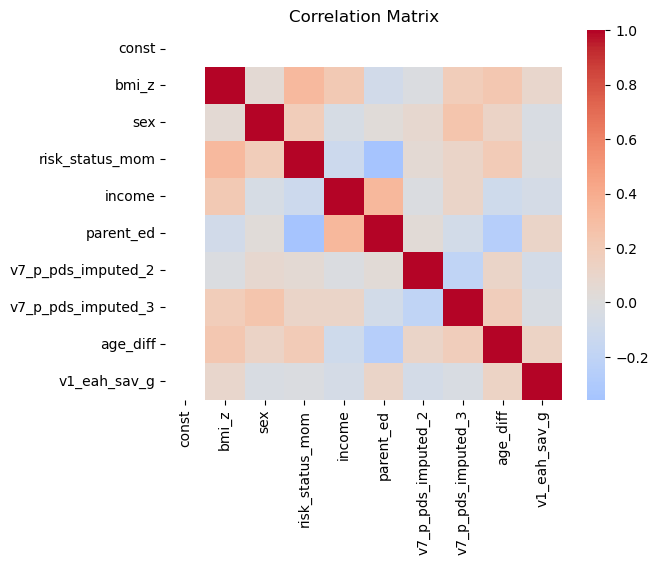

             Variable        VIF
0               const  16.442528
1               bmi_z   1.293179
2                 sex   1.147620
3     risk_status_mom   1.342330
4              income   1.271352
5           parent_ed   1.407027
6  v7_p_pds_imputed_2   1.101039
7  v7_p_pds_imputed_3   1.213780
8            age_diff   1.220322
9        v1_eah_sav_g   1.083751
CHECKING FOR HETEROSKEDASTICITY


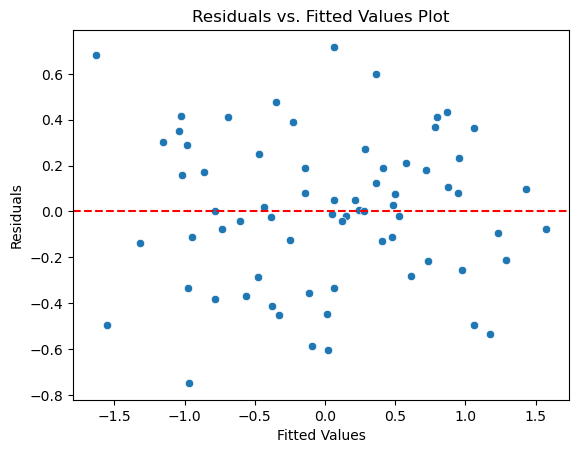

Breusch-Pagan test statistic: 13.468478299460106, p-value: 0.14252832808270435
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


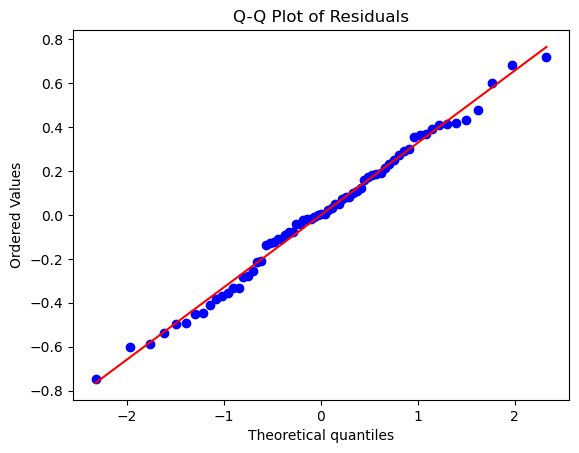

Shapiro-Wilk Test Results:
Statistic: 0.9900615215301514
p-value: 0.8628512620925903
Residuals are normally distributed (fail to reject null hypothesis)


In [59]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavgBMIz= mod_EAHsavgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavgBMIz = durbin_watson(residuals_EAHsavgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavgBMIz)
if 0 < dw_statistic_EAHsavgBMIz< 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavgBMIz.values, i) for i in range(X_EAHsavgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavgBMIz.fittedvalues, y=residuals_EAHsavgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()


bp_test = het_breuschpagan(residuals_EAHsavgBMIz,  mod_EAHsavgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)") 

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavgBMIz, p_value_EAHsavgBMIz = shapiro(residuals_EAHsavgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavgBMIz)
print("p-value:", p_value_EAHsavgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsavgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## DEMOGRAPHIC TABLE - separate for continuous and categorical

categorical vars

In [60]:
# Assuming 'df' is your original DataFrame with data

categorical_vars = ['parent_respondent', 'parent_ed', 'income', 'risk_status_mom',
                    'sex', 'ethnicity', 'race', 'pds_tanner_cat']

# Initialize an empty list to store the results
categorical_data = []

# Loop through each categorical column and calculate percentages and counts
for column in categorical_vars:
    counts = df[column].value_counts()
    percentages = counts / counts.sum() * 100
    for category, count in counts.items():
        categorical_data.append({
            'Variable': column,
            'Category': category,
            'Percentage': percentages[category],
            'Count': count
        })

# Convert the list of dictionaries into a DataFrame
categorical_table = pd.DataFrame(categorical_data)

print(categorical_table)

# Save to Excel
categorical_table.to_excel('cat_table.xlsx', index=False)

             Variable  Category  Percentage  Count
0   parent_respondent         0   84.057971     58
1   parent_respondent         1   15.942029     11
2           parent_ed         3   43.478261     30
3           parent_ed         4   21.739130     15
4           parent_ed         5   15.942029     11
5           parent_ed         0   10.144928      7
6           parent_ed         1    8.695652      6
7              income         5   37.681159     26
8              income         3   28.985507     20
9              income         4   23.188406     16
10             income         2    7.246377      5
11             income         1    1.449275      1
12             income         0    1.449275      1
13    risk_status_mom         0   59.420290     41
14    risk_status_mom         1   40.579710     28
15                sex         0   50.724638     35
16                sex         1   49.275362     34
17          ethnicity         0  100.000000     69
18               race         0

continuous vars

In [61]:
# Create a new DataFrame for the continuous table
continuous_vars = ['age_yr', 'bmi_percentile', 'bmi_z', 'v7_age_yr', 'v7_bmi_percentile', 'v7_bmi_z', 'age_diff']
continuous_table = pd.DataFrame()

# Continuous variables - mean +/- SD and output range
for col in continuous_vars:
    continuous_table[f'{col}_mean'] = [df[col].mean()]
    continuous_table[f'{col}_SD'] = [df[col].std()]
    continuous_table[f'{col}_min'] = [df[col].min()]
    continuous_table[f'{col}_max'] = [df[col].max()]

# Display the continuous table
print("\nContinuous Table:")
print(continuous_table)
continuous_table.to_excel('cont_table.xlsx')


Continuous Table:
   age_yr_mean  age_yr_SD  age_yr_min  age_yr_max  bmi_percentile_mean  \
0     7.827101   0.583814         7.0        8.99            47.614783   

   bmi_percentile_SD  bmi_percentile_min  bmi_percentile_max  bmi_z_mean  \
0           25.28671                3.91               89.49   -0.083478   

   bmi_z_SD  bmi_z_min  bmi_z_max  v7_age_yr_mean  v7_age_yr_SD  \
0  0.752228      -1.76       1.25        9.344638      0.685479   

   v7_age_yr_min  v7_age_yr_max  v7_bmi_percentile_mean  v7_bmi_percentile_SD  \
0           8.35          11.07               50.817391             27.186951   

   v7_bmi_percentile_min  v7_bmi_percentile_max  v7_bmi_z_mean  v7_bmi_z_SD  \
0                   2.02                  93.72       0.019275     0.837816   

   v7_bmi_z_min  v7_bmi_z_max  age_diff_mean  age_diff_SD  age_diff_min  \
0         -2.05          1.53       1.517536     0.407075          1.07   

   age_diff_max  
0          2.77  


# Intake vars analysis, Mean,SD, Max-Min

In [62]:
intake_vars = ['v1_eah_kcal', 'v7_eah_kcal', 'v1_meal_kcal', 'v7_meal_kcal',
               'v1_eah_g', 'v7_eah_g', 'v1_meal_g', 'v7_meal_g',
               'v1_eah_sweet_kcal', 'v7_eah_sweet_kcal', 'v1_eah_sav_kcal', 'v7_eah_sav_kcal',
               'v1_eah_sweet_g', 'v7_eah_sweet_g', 'v1_eah_sav_g', 'v7_eah_sav_g']

# Initialize an empty DataFrame to store the Intake Table
intake_table = pd.DataFrame(
    columns=['Intake Variable', 'Mean', 'Min', 'Max', 'SD'])

# Function to calculate statistics and append to the intake_table


def add_to_intake_table(column_name, data_column):
    mean_val = data_column.mean()
    min_val = data_column.min()
    max_val = data_column.max()
    sd_val = data_column.std()

    intake_table.loc[len(intake_table)] = [column_name, mean_val, min_val, max_val, sd_val]


# Calculate statistics for intake variables and add to intake_table
for column in intake_vars:
    add_to_intake_table(column, df[column])

print(intake_table)
intake_table.to_excel('intake_table.xlsx', index=False)

      Intake Variable        Mean        Min         Max          SD
0         v1_eah_kcal  274.584117   60.37431   642.05487  133.515806
1         v7_eah_kcal  306.030159    0.00000   665.39691  155.603497
2        v1_meal_kcal  601.116138  219.67092  1272.07870  267.504081
3        v7_meal_kcal  704.237170  265.71855  1311.72059  242.769272
4            v1_eah_g  110.535318   14.81000   292.33000   65.162893
5            v7_eah_g  149.894493    0.00000   412.97000   96.438106
6           v1_meal_g  328.078680   68.17000   762.67000  171.777034
7           v7_meal_g  406.725742   75.01000   689.17000  166.273347
8   v1_eah_sweet_kcal  252.703909   42.74560   564.92261  126.692229
9   v7_eah_sweet_kcal  282.773871    0.00000   632.48842  154.476590
10    v1_eah_sav_kcal   21.835923    0.00000   112.22033   26.044635
11    v7_eah_sav_kcal   24.323944    0.00000   244.01132   38.970932
12     v1_eah_sweet_g   67.037513   10.65000   142.35000   30.595453
13     v7_eah_sweet_g   76.158406 

# Intake variables independent T test between low vs risk status

In [63]:
from scipy.stats import ttest_ind

# Filter data for each risk group
low_risk_data = df[df["risk_status_mom"] == 0]
high_risk_data = df[df["risk_status_mom"] == 1]

# List of continuous variables to test
continuous_variables = ["v1_eah_g", "v1_eah_kcal", "v7_eah_g", "v7_eah_kcal", "v1_meal_g", "v1_meal_kcal", "v7_meal_g", "v7_meal_kcal","v1_eah_sweet_g", "v1_eah_sweet_kcal", "v7_eah_sweet_g", "v7_eah_sweet_kcal","v1_eah_sav_g", "v1_eah_sav_kcal", "v7_eah_sav_g", "v7_eah_sav_kcal"]

# Create a DataFrame to store results
results = []

# Loop through each continuous variable
for variable in continuous_variables:
    t_stat, p_value = ttest_ind(low_risk_data[variable], high_risk_data[variable])
    
    result_entry = {
        "Variable": variable,
        "T-statistic": t_stat,
        "P-value": p_value
    }
    
    results.append(result_entry)

# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Export results to Excel
results_df.to_excel("t_test_eahvsmeal.xlsx", index=False)

## Analysis by risk status

In [64]:
# Filter data for each risk group
low_risk_data = df[df["risk_status_mom"] == 0]
high_risk_data = df[df["risk_status_mom"] == 1]

# List of continuous variables to calculate statistics for
continuous_variables = [
    "v1_eah_g", "v1_eah_kcal", "v7_eah_g", "v7_eah_kcal",
    "v1_meal_g", "v1_meal_kcal", "v7_meal_g", "v7_meal_kcal",
    "v1_eah_sweet_g", "v1_eah_sweet_kcal", "v7_eah_sweet_g", "v7_eah_sweet_kcal",
    "v1_eah_sav_g", "v1_eah_sav_kcal", "v7_eah_sav_g", "v7_eah_sav_kcal"
]

# Create a DataFrame to store statistics
statistics = []

# Calculate statistics (mean, SD, min, max) for each variable based on risk status
for variable in continuous_variables:
    low_risk_mean = low_risk_data[variable].mean()
    low_risk_sd = low_risk_data[variable].std()
    low_risk_min = low_risk_data[variable].min()
    low_risk_max = low_risk_data[variable].max()

    high_risk_mean = high_risk_data[variable].mean()
    high_risk_sd = high_risk_data[variable].std()
    high_risk_min = high_risk_data[variable].min()
    high_risk_max = high_risk_data[variable].max()

    result_entry = {
        "Variable": variable,
        "Low Risk Mean": low_risk_mean,
        "Low Risk SD": low_risk_sd,
        "Low Risk Min": low_risk_min,
        "Low Risk Max": low_risk_max,
        "High Risk Mean": high_risk_mean,
        "High Risk SD": high_risk_sd,
        "High Risk Min": high_risk_min,
        "High Risk Max": high_risk_max
    }

    statistics.append(result_entry)

# Convert statistics list to DataFrame
statistics_df = pd.DataFrame(statistics)

# Export statistics to Excel
statistics_df.to_excel("statistics_by_risk_status.xlsx", index=False)

# T-test for intake vars at T1 and T2

In [65]:
import pandas as pd
from scipy.stats import ttest_rel

# Assuming your dataframe is named df
variables_to_compare = [
    ('meal_kcal', 'v1_meal_kcal', 'v7_meal_kcal'),
    ('eah_kcal', 'v1_eah_kcal', 'v7_eah_kcal'),
    ('sweet_kcal', 'v1_eah_sweet_kcal', 'v7_eah_sweet_kcal'),
    ('sav_kcal', 'v1_eah_sav_kcal', 'v7_eah_sav_kcal'),
    ('sav_g', 'v1_eah_sav_g', 'v7_eah_sav_g'),
    ('sweet_g', 'v1_eah_sweet_g', 'v7_eah_sweet_g'),
    ('meal_g', 'v1_meal_g', 'v7_meal_g'),
    ('eah_g', 'v1_eah_g', 'v7_eah_g')
]

# Initialize an empty DataFrame to store the t-test results
ttest_results = pd.DataFrame(columns=['Variable Pair', 'T-Statistic', 'P-Value'])

# Perform paired t-tests for each variable pair
for var_name, col_v1, col_v7 in variables_to_compare:
    t_statistic, p_value = ttest_rel(df[col_v1], df[col_v7])
    formatted_p_value = "{:.3f}".format(p_value)  # Format p-value to two decimal places
    ttest_results.loc[len(ttest_results)] = [var_name, t_statistic, formatted_p_value]

print(ttest_results)

  Variable Pair  T-Statistic P-Value
0     meal_kcal    -3.643207   0.001
1      eah_kcal    -1.902995   0.061
2    sweet_kcal    -1.860199   0.067
3      sav_kcal    -0.513689   0.609
4         sav_g    -0.575535   0.567
5       sweet_g    -2.388904   0.020
6        meal_g    -4.248915   0.000
7         eah_g    -3.384997   0.001


# Liking ratings

 each food item liking rating at v1 and v7 , Independent T test for each food item comparing between v1 and v7

In [66]:
def analyze_food_items(df):
    # Extracting the column names for v1 and v7 time points
    v1_columns = [col for col in df.columns if col.startswith("v1_vas_")]
    v7_columns = [col for col in df.columns if col.startswith("v7_vas_")]

    # Initializing a list to store results
    results = []

    # Looping through each pair of columns
    for v1_col, v7_col in zip(v1_columns, v7_columns):
        food_item = v1_col.split("v1_vas_")[-1]  # Extracting the food item name

        # Calculating means and standard errors
        mean_v1 = df[v1_col].mean()
        se_v1 = df[v1_col].sem()
        mean_v7 = df[v7_col].mean()
        se_v7 = df[v7_col].sem()

        # Performing t-test
        t_stat, p_value = stats.ttest_ind(df[v1_col].dropna(), df[v7_col].dropna())

        # Storing results
        results.append({
            "Food Item": food_item,
            "Mean V1": mean_v1,
            "SE V1": se_v1,
            "Mean V7": mean_v7,
            "SE V7": se_v7,
            "T-Statistic": t_stat,
            "P-Value": p_value
        })

    # Converting results to DataFrame for better visualization
    results_df = pd.DataFrame(results)
    return results_df

# Set display option for floating point numbers
pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Analyzing the DataFrame
results = analyze_food_items(df)

# Printing the results
print(results)

        Food Item      Mean V1        SE V1      Mean V7        SE V7  \
0         popcorn 4.1304347826 0.0770099900 4.0289855072 0.0771702608   
1         pretzle 3.9275362319 0.0834028029 3.9710144928 0.0850530512   
2        cornchip 3.9855072464 0.1158620781 3.9420289855 0.0920637173   
3          cookie 4.6376811594 0.0683847700 4.5652173913 0.0863147674   
4         brownie 4.4202898551 0.0810360163 4.4492753623 0.0839564899   
5       starburst 4.3478260870 0.0986396971 4.2608695652 0.0938250669   
6         skittle 4.3043478261 0.1117640231 4.3188405797 0.1102054843   
7         hershey 4.4202898551 0.0885754385 4.4492753623 0.0912549427   
8        icecream 4.3478260870 0.0942192916 4.4057971014 0.0953274086   
9      pbj_sndwch 3.4927536232 0.1567236865 3.5652173913 0.1139806389   
10     ham_sndwch 3.7101449275 0.1257567871 3.7681159420 0.1275129794   
11  turkey_sndwch 3.8260869565 0.1353164359 3.7826086957 0.1089936240   
12  cheese_sndwch 3.4927536232 0.1266379276 3.36231

Savory and sweet categories comparing between v1 vs v7

In [67]:
# Define the savory and sweet items
savory_items = ['cornchip', 'pretzle', 'popcorn']
sweet_items = ['cookie', 'icecream', 'hershey', 'starburst', 'skittle', 'brownie']

def analyze_categories(df, savory_items, sweet_items):
    # Initialize results
    results = []

    # Function to calculate mean, SE, and t-test for a category
    def analyze_category(category_name, item_list):
        # Creating combined columns for v1 and v7
        df[f'v1_{category_name}'] = df[[f'v1_vas_{item}' for item in item_list]].mean(axis=1)
        df[f'v7_{category_name}'] = df[[f'v7_vas_{item}' for item in item_list]].mean(axis=1)

        # Calculating means and standard errors
        mean_v1 = df[f'v1_{category_name}'].mean()
        se_v1 = df[f'v1_{category_name}'].sem()
        mean_v7 = df[f'v7_{category_name}'].mean()
        se_v7 = df[f'v7_{category_name}'].sem()

        # Performing t-test
        t_stat, p_value = stats.ttest_ind(df[f'v1_{category_name}'].dropna(), df[f'v7_{category_name}'].dropna())

        return {
            "Category": category_name,
            "Mean V1": mean_v1,
            "SE V1": se_v1,
            "Mean V7": mean_v7,
            "SE V7": se_v7,
            "T-Statistic": t_stat,
            "P-Value": p_value
        }

    # Analyzing Savory category
    results.append(analyze_category("Savory", savory_items))

    # Analyzing Sweet category
    results.append(analyze_category("Sweet", sweet_items))

    # Converting results to DataFrame for better visualization
    results_df = pd.DataFrame(results)
    return results_df

# Set display option for floating point numbers
pd.set_option('display.float_format', lambda x: '%.10f' % x)


# Example usage:
results = analyze_categories(df, savory_items, sweet_items)
print(results)

  Category      Mean V1        SE V1      Mean V7        SE V7  T-Statistic  \
0   Savory 4.0144927536 0.0617215306 3.9806763285 0.0554349606 0.4076167210   
1    Sweet 4.4130434783 0.0578465558 4.4082125604 0.0584500549 0.0587451134   

       P-Value  
0 0.6841960122  
1 0.9532413555  


Savory vs sweet categories at v1 AND v7

In [68]:
import pandas as pd
from scipy import stats

def compare_sweet_savory(df, savory_items, sweet_items):
    # Function to calculate the mean and SE for a category at a given time point
    def category_stats(df, item_list, time_point):
        category_means = df[[f'{time_point}_vas_{item}' for item in item_list]].mean(axis=1)
        mean = category_means.mean()
        se = category_means.sem()
        return mean, se, category_means

    # Calculate category means and SE for both time points
    savory_mean_v1, savory_se_v1, savory_v1 = category_stats(df, savory_items, 'v1')
    sweet_mean_v1, sweet_se_v1, sweet_v1 = category_stats(df, sweet_items, 'v1')
    savory_mean_v7, savory_se_v7, savory_v7 = category_stats(df, savory_items, 'v7')
    sweet_mean_v7, sweet_se_v7, sweet_v7 = category_stats(df, sweet_items, 'v7')

    # Perform t-tests for sweet vs savory at v1 and v7 with sweet as the first group
    t_stat_v1, p_value_v1 = stats.ttest_ind(sweet_v1.dropna(), savory_v1.dropna())
    t_stat_v7, p_value_v7 = stats.ttest_ind(sweet_v7.dropna(), savory_v7.dropna())

    # Organize the results
    results = pd.DataFrame({
        "Category": ["Sweet", "Savory", "Sweet", "Savory"],
        "Time Point": ["V1", "V1", "V7", "V7"],
        "Mean": [sweet_mean_v1, savory_mean_v1, sweet_mean_v7, savory_mean_v7],
        "SE": [sweet_se_v1, savory_se_v1, sweet_se_v7, savory_se_v7],
        "T-Statistic": [t_stat_v1, None, t_stat_v7, None],
        "P-Value": [p_value_v1, None, p_value_v7, None]
    })

    return results

# Set display option for floating point numbers
pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Define the savory and sweet items
savory_items = ['cornchip', 'pretzle', 'popcorn']
sweet_items = ['cookie', 'icecream', 'hershey', 'starburst', 'skittle', 'brownie']


results = compare_sweet_savory(df, savory_items, sweet_items)
print(results)


  Category Time Point         Mean           SE  T-Statistic      P-Value
0    Sweet         V1 4.4130434783 0.0578465558 4.7114585562 0.0000060021
1   Savory         V1 4.0144927536 0.0617215306          NaN          NaN
2    Sweet         V7 4.4082125604 0.0584500549 5.3072456299 0.0000004409
3   Savory         V7 3.9806763285 0.0554349606          NaN          NaN


In [69]:
import pandas as pd
from scipy import stats

def compare_sweet_savory(df, savory_items, sweet_items):
    # Function to calculate the mean for a category at a given time point
    def category_mean(df, item_list, time_point):
        # Creating a column for the category mean at the specified time point
        category_col = [f'{time_point}_vas_{item}' for item in item_list]
        df[f'{time_point}_category_mean'] = df[category_col].mean(axis=1)
        return df[f'{time_point}_category_mean']

    # Calculate category means for both time points
    savory_mean_v1 = category_mean(df, savory_items, 'v1')
    sweet_mean_v1 = category_mean(df, sweet_items, 'v1')
    savory_mean_v7 = category_mean(df, savory_items, 'v7')
    sweet_mean_v7 = category_mean(df, sweet_items, 'v7')

    # Perform t-tests
    t_stat_v1, p_value_v1 = stats.ttest_ind(savory_mean_v1.dropna(), sweet_mean_v1.dropna())
    t_stat_v7, p_value_v7 = stats.ttest_ind(savory_mean_v7.dropna(), sweet_mean_v7.dropna())

    # Results
    return pd.DataFrame({
        "Time Point": ["v1", "v7"],
        "T-Statistic": [t_stat_v1, t_stat_v7],
        "P-Value": [p_value_v1, p_value_v7]
    })

# Set display option for floating point numbers
pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Define the savory and sweet items
savory_items = ['cornchip', 'pretzle', 'popcorn']
sweet_items = ['cookie', 'icecream', 'hershey', 'starburst', 'skittle', 'brownie']

# Example usage:
results = compare_sweet_savory(df, savory_items, sweet_items)
print(results)

  Time Point   T-Statistic      P-Value
0         v1 -4.7114585562 0.0000060021
1         v7 -5.3072456299 0.0000004409


T-test for comparison between sweet vs savory at T1, and at T2

In [70]:
import pandas as pd
from scipy import stats

def compare_sweet_savory(df, savory_items, sweet_items):
    # Function to calculate the mean for a category at a given time point
    def category_mean(df, item_list, time_point):
        # Creating a column for the category mean at the specified time point
        category_col = [f'{time_point}_vas_{item}' for item in item_list]
        df[f'{time_point}_category_mean'] = df[category_col].mean(axis=1)
        return df[f'{time_point}_category_mean']

    # Calculate category means for both time points
    savory_mean_v1 = category_mean(df, savory_items, 'v1')
    sweet_mean_v1 = category_mean(df, sweet_items, 'v1')
    savory_mean_v7 = category_mean(df, savory_items, 'v7')
    sweet_mean_v7 = category_mean(df, sweet_items, 'v7')

    # Perform t-tests
    t_stat_v1, p_value_v1 = stats.ttest_ind(savory_mean_v1.dropna(), sweet_mean_v1.dropna())
    t_stat_v7, p_value_v7 = stats.ttest_ind(savory_mean_v7.dropna(), sweet_mean_v7.dropna())

    # Results
    return pd.DataFrame({
        "Time Point": ["v1", "v7"],
        "T-Statistic": [t_stat_v1, t_stat_v7],
        "P-Value": [p_value_v1, p_value_v7]
    })

# Set display option for floating point numbers
pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Define the savory and sweet items
savory_items = ['cornchip', 'pretzle', 'popcorn']
sweet_items = ['cookie', 'icecream', 'hershey', 'starburst', 'skittle', 'brownie']

# Example usage:
results = compare_sweet_savory(df, savory_items, sweet_items)
print(results)

  Time Point   T-Statistic      P-Value
0         v1 -4.7114585562 0.0000060021
1         v7 -5.3072456299 0.0000004409


### Exporting table with OLS model params

In [71]:
import pandas as pd
import statsmodels.api as sm

# List of model names
model_names = [
    "mod_mealkcalFMI", "mod_EAHkcalFMI", "mod_EAHsweetkcalFMI", "mod_EAHsavkcalFMI",
    "mod_mealkcalBMIz", "mod_EAHkcalBMIz", "mod_EAHsweetkcalBMIz", "mod_EAHsavkcalBMIz",
    "mod_mealgFMI", "mod_EAHgFMI", "mod_EAHsweetgFMI", "mod_EAHsavgFMI",
     "mod_mealgBMIz", "mod_EAHgBMIz", "mod_EAHsweetgBMIz", "mod_EAHsavgBMIz",
]

# List to store model information
model_info = []

# Loop through each model
for model_name in model_names:
    model = globals()[model_name]  # Get the model object using its name
    
    # Extract parameter for the last predictor
    last_predictor = model.params.index[-1]
    last_param = model.params[last_predictor]
    last_se = model.bse[last_predictor] 
    last_p_value = model.pvalues[last_predictor]
    last_t_value = model.tvalues[last_predictor]
    last_conf_int = model.conf_int().loc[last_predictor]

    # Create a dictionary to store information
    model_entry = {
        "Model Name": model_name,
        "Last Predictor": last_predictor,
        "Last Parameter": last_param,
        "SE": last_se,
        "Last P-value": last_p_value,
        "Last T-value": last_t_value,
        "Last CI 95%": last_conf_int
    }

    model_info.append(model_entry)

# Create a DataFrame from the list of model information
models_df = pd.DataFrame(model_info)

models_df.to_excel("regression_model_no_low_intake.xlsx",index=False)

# graphs

In [72]:
#import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
%matplotlib inline

In [73]:
pd.set_option('display.max_columns', None)

In [74]:
df=pd.read_excel("EAH_DB_no_low_intake.xlsx")

In [75]:
def replace_outliers_with_mean(df, columns):
    # Dictionary to store the count of replaced outliers for each column
    replaced_count = {}
    
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        # Define bounds for outliers
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        
        # Calculate condition for outliers
        outlier_condition = (df[col] < lower_bound) | (df[col] > upper_bound)
        
        # Count outliers that will be replaced
        replaced_count[col] = outlier_condition.sum()
        
        # Replace outliers with the mean of the series
        df[col] = df[col].mask(outlier_condition, mean_val)
        
    # Optionally, return the dictionary if you want to see the counts after function execution
    return df, replaced_count

# Usage
df, count_replaced = replace_outliers_with_mean(df, outlier_cols)
print(count_replaced)


{'v1_meal_g': 0, 'v1_meal_kcal': 0, 'v1_eah_g': 1, 'v1_eah_kcal': 0, 'v1_eah_sweet_g': 0, 'v1_eah_sweet_kcal': 0, 'v1_eah_sav_g': 1, 'v1_eah_sav_kcal': 1, 'v7_meal_g': 0, 'v7_meal_kcal': 0, 'v7_eah_g': 0, 'v7_eah_kcal': 0, 'v7_eah_sweet_g': 0, 'v7_eah_sweet_kcal': 0, 'v7_eah_sav_kcal': 1, 'v7_eah_sav_g': 1, 'v1_freddy_pre_eah': 0, 'v7_freddy_pre_eah': 1}


In [76]:
df_graph=df.copy()

In [77]:
def plot_with_regression_and_pvalue(x, y, data, ax, xlabel, ylabel, title, beta, pvalue, change_100, unit):
    sns.scatterplot(x=x, y=y, data=data, ax=ax)
    sns.regplot(x=x, y=y, data=data, ax=ax, scatter=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.text(0.05, 0.95, f"β = {beta:.2f}\np-value: {pvalue:.2f}\nchange in outcome with 100 {unit} increase   = {change_100:.3f}", transform=ax.transAxes,
            fontsize=12, va='top', ha='left', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to calculate unscaled change for 100 units
def calculate_unscaled_change(coef, sd_outcome, sd_predictor, units=100):
    return coef * sd_outcome * (units / sd_predictor)

# Define a function to extract coefficients and p-values, and calculate unscaled changes
def extract_and_unscale(model, predictor, outcome_sd, predictor_sd):
    coef = model.params[predictor]
    pvalue = model.pvalues[predictor]
    change = calculate_unscaled_change(coef, outcome_sd, predictor_sd)
    return coef, pvalue, change

# Extract standard deviations of predictors and outcomes from df_graph (unscaled)
sd_meal_kcal = df_graph['v1_meal_kcal'].std()
sd_eah_kcal = df_graph['v1_eah_kcal'].std()
sd_eah_sweet_kcal = df_graph['v1_eah_sweet_kcal'].std()
sd_eah_sav_kcal = df_graph['v1_eah_sav_kcal'].std()

sd_meal_g = df_graph['v1_meal_g'].std()
sd_eah_g = df_graph['v1_eah_g'].std()
sd_eah_sweet_g = df_graph['v1_eah_sweet_g'].std()
sd_eah_sav_g = df_graph['v1_eah_sav_g'].std()

sd_FMI = df_graph['v7_FMI'].std()

# Extract and unscale values for each model
# FMI models (kcal)
coef_meal_kcal, pvalue_meal_kcal, change_meal_kcal_FMI = extract_and_unscale(mod_mealkcalFMI, 'v1_meal_kcal', sd_FMI, sd_meal_kcal)
coef_eah_kcal, pvalue_eah_kcal, change_eah_kcal_FMI = extract_and_unscale(mod_EAHkcalFMI, 'v1_eah_kcal', sd_FMI, sd_eah_kcal)
coef_eah_sweet_kcal, pvalue_eah_sweet_kcal, change_eah_sweet_kcal_FMI = extract_and_unscale(mod_EAHsweetkcalFMI, 'v1_eah_sweet_kcal', sd_FMI, sd_eah_sweet_kcal)
coef_eah_sav_kcal, pvalue_eah_sav_kcal, change_eah_sav_kcal_FMI = extract_and_unscale(mod_EAHsavkcalFMI, 'v1_eah_sav_kcal', sd_FMI, sd_eah_sav_kcal)

# FMI models (grams)
coef_meal_g, pvalue_meal_g, change_meal_g_FMI = extract_and_unscale(mod_mealgFMI, 'v1_meal_g', sd_FMI, sd_meal_g)
coef_eah_g, pvalue_eah_g, change_eah_g_FMI = extract_and_unscale(mod_EAHgFMI, 'v1_eah_g', sd_FMI, sd_eah_g)
coef_eah_sweet_g, pvalue_eah_sweet_g, change_eah_sweet_g_FMI = extract_and_unscale(mod_EAHsweetgFMI, 'v1_eah_sweet_g', sd_FMI, sd_eah_sweet_g)
coef_eah_sav_g, pvalue_eah_sav_g, change_eah_sav_g_FMI = extract_and_unscale(mod_EAHsavgFMI, 'v1_eah_sav_g', sd_FMI, sd_eah_sav_g)

# BMIz models (kcal)
coef_meal_kcal_bmiz = mod_mealkcalBMIz.params['v1_meal_kcal']
pvalue_meal_kcal_bmiz = mod_mealkcalBMIz.pvalues['v1_meal_kcal']
change_meal_kcal_BMIz = coef_meal_kcal_bmiz * 100 / sd_meal_kcal

coef_eah_kcal_bmiz = mod_EAHkcalBMIz.params['v1_eah_kcal']
pvalue_eah_kcal_bmiz = mod_EAHkcalBMIz.pvalues['v1_eah_kcal']
change_eah_kcal_BMIz = coef_eah_kcal_bmiz * 100 / sd_eah_kcal

coef_eah_sweet_kcal_bmiz = mod_EAHsweetkcalBMIz.params['v1_eah_sweet_kcal']
pvalue_eah_sweet_kcal_bmiz = mod_EAHsweetkcalBMIz.pvalues['v1_eah_sweet_kcal']
change_eah_sweet_kcal_BMIz = coef_eah_sweet_kcal_bmiz * 100 / sd_eah_sweet_kcal

coef_eah_sav_kcal_bmiz = mod_EAHsavkcalBMIz.params['v1_eah_sav_kcal']
pvalue_eah_sav_kcal_bmiz = mod_EAHsavkcalBMIz.pvalues['v1_eah_sav_kcal']
change_eah_sav_kcal_BMIz = coef_eah_sav_kcal_bmiz * 100 / sd_eah_sav_kcal

# BMIz models (grams)
coef_meal_g_bmiz = mod_mealgBMIz.params['v1_meal_g']
pvalue_meal_g_bmiz = mod_mealgBMIz.pvalues['v1_meal_g']
change_meal_g_BMIz = coef_meal_g_bmiz * 100 / sd_meal_g

coef_eah_g_bmiz = mod_EAHgBMIz.params['v1_eah_g']
pvalue_eah_g_bmiz = mod_EAHgBMIz.pvalues['v1_eah_g']
change_eah_g_BMIz = coef_eah_g_bmiz * 100 / sd_eah_g

coef_eah_sweet_g_bmiz = mod_EAHsweetgBMIz.params['v1_eah_sweet_g']
pvalue_eah_sweet_g_bmiz = mod_EAHsweetgBMIz.pvalues['v1_eah_sweet_g']
change_eah_sweet_g_BMIz = coef_eah_sweet_g_bmiz * 100 / sd_eah_sweet_g

coef_eah_sav_g_bmiz = mod_EAHsavgBMIz.params['v1_eah_sav_g']
pvalue_eah_sav_g_bmiz = mod_EAHsavgBMIz.pvalues['v1_eah_sav_g']
change_eah_sav_g_BMIz = coef_eah_sav_g_bmiz * 100 / sd_eah_sav_g

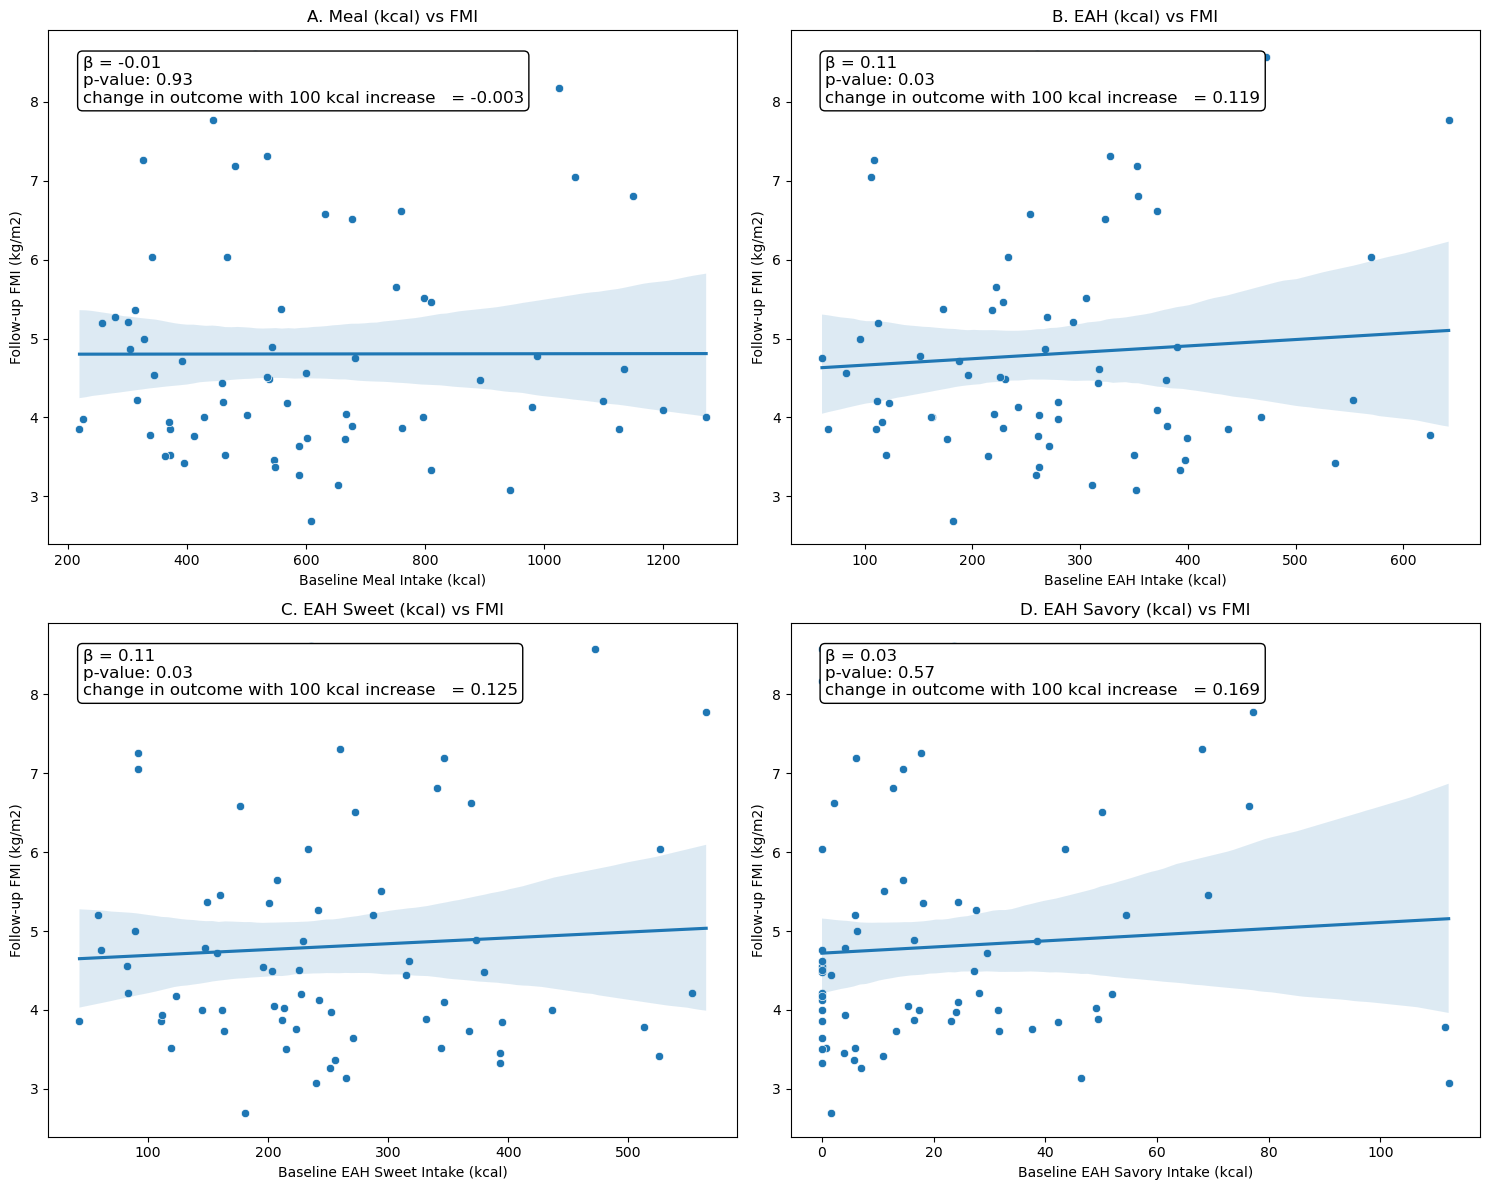

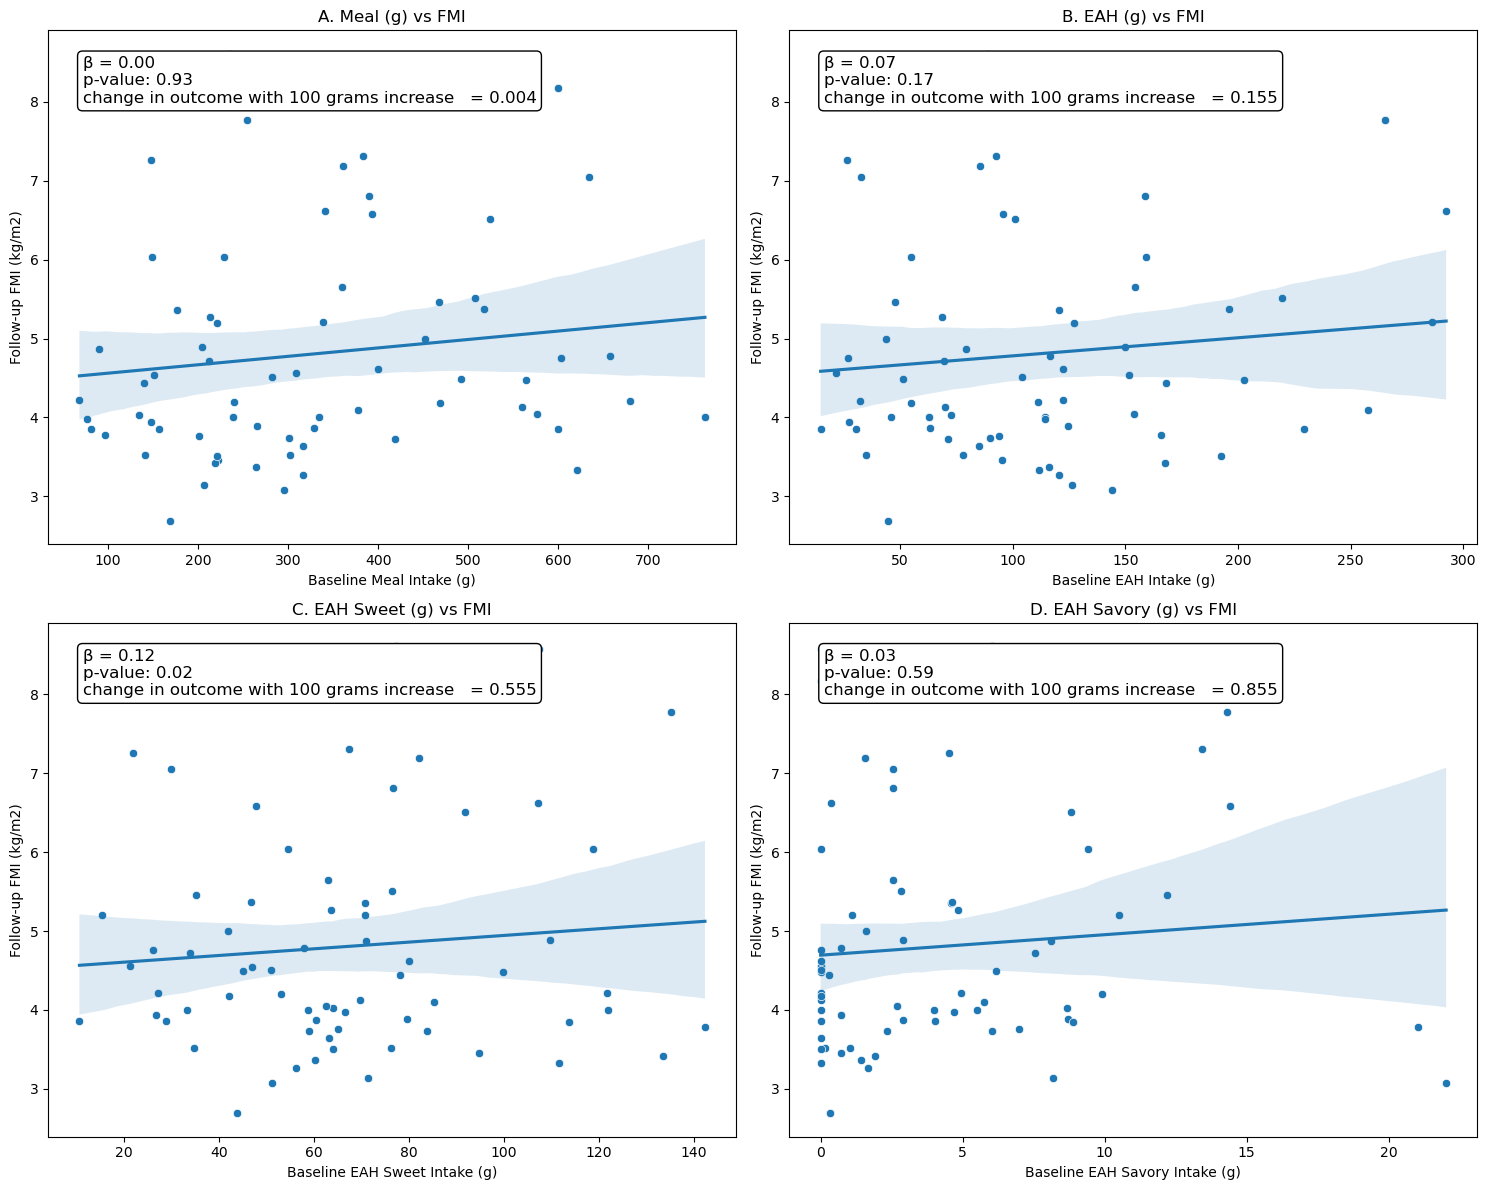

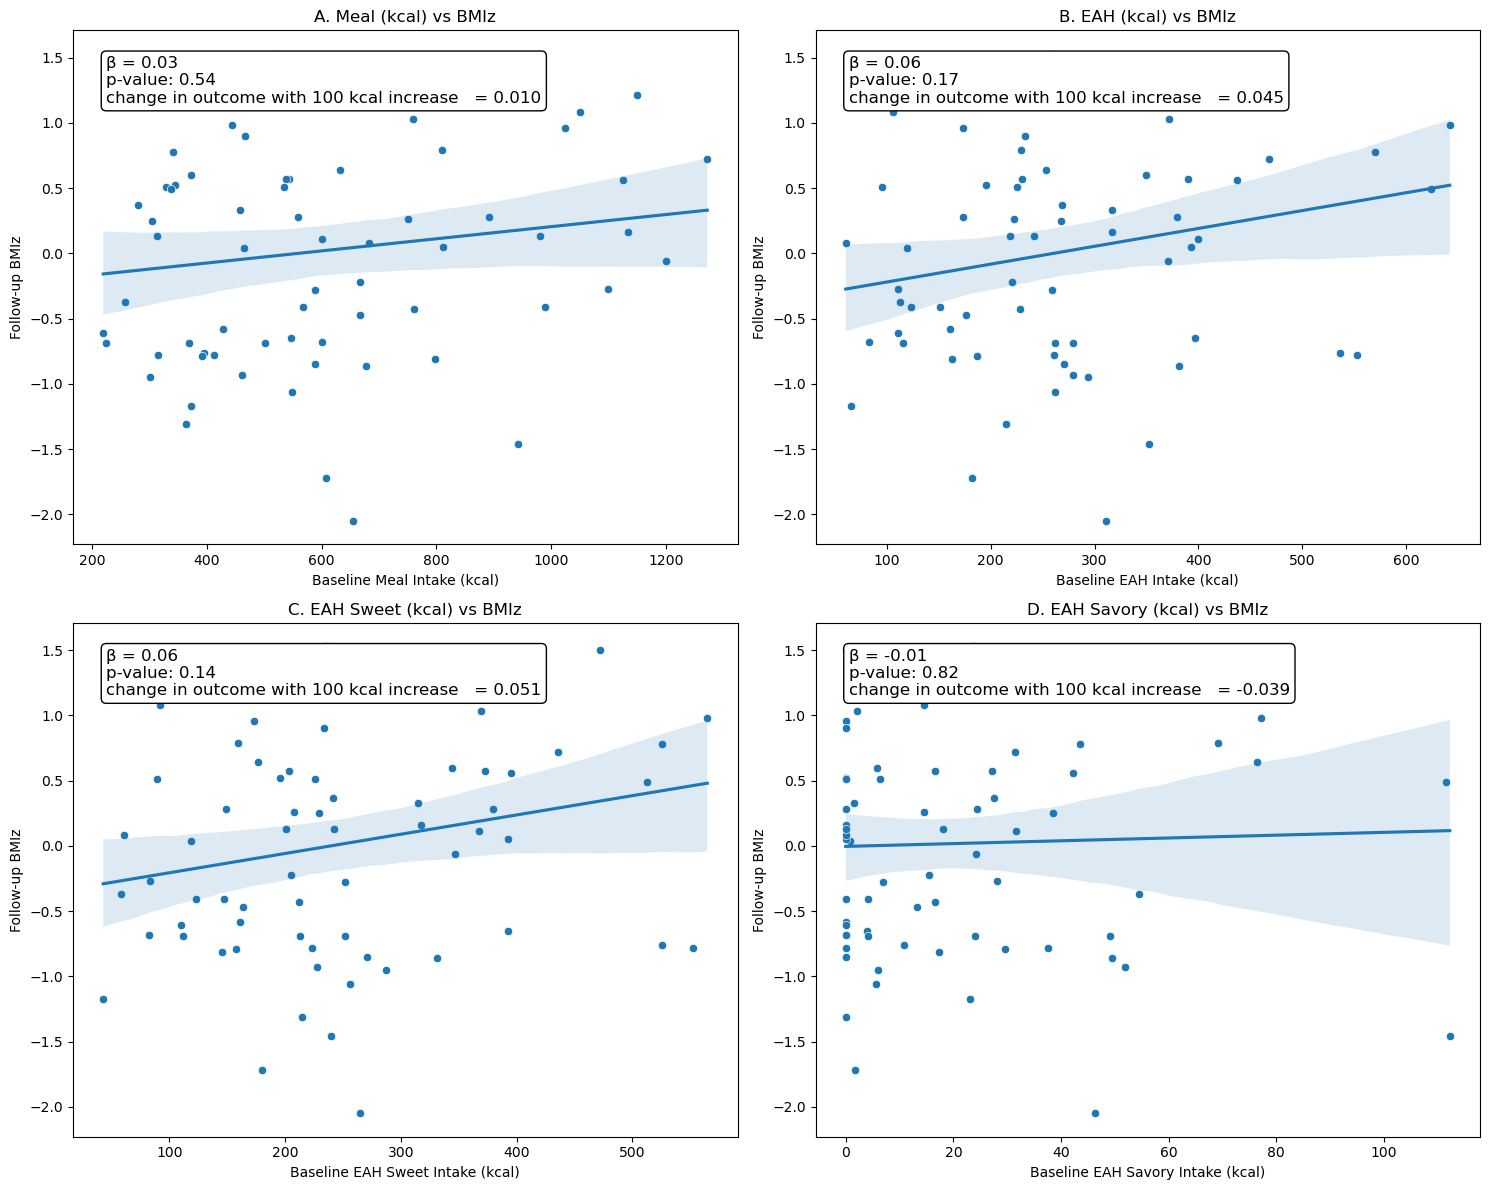

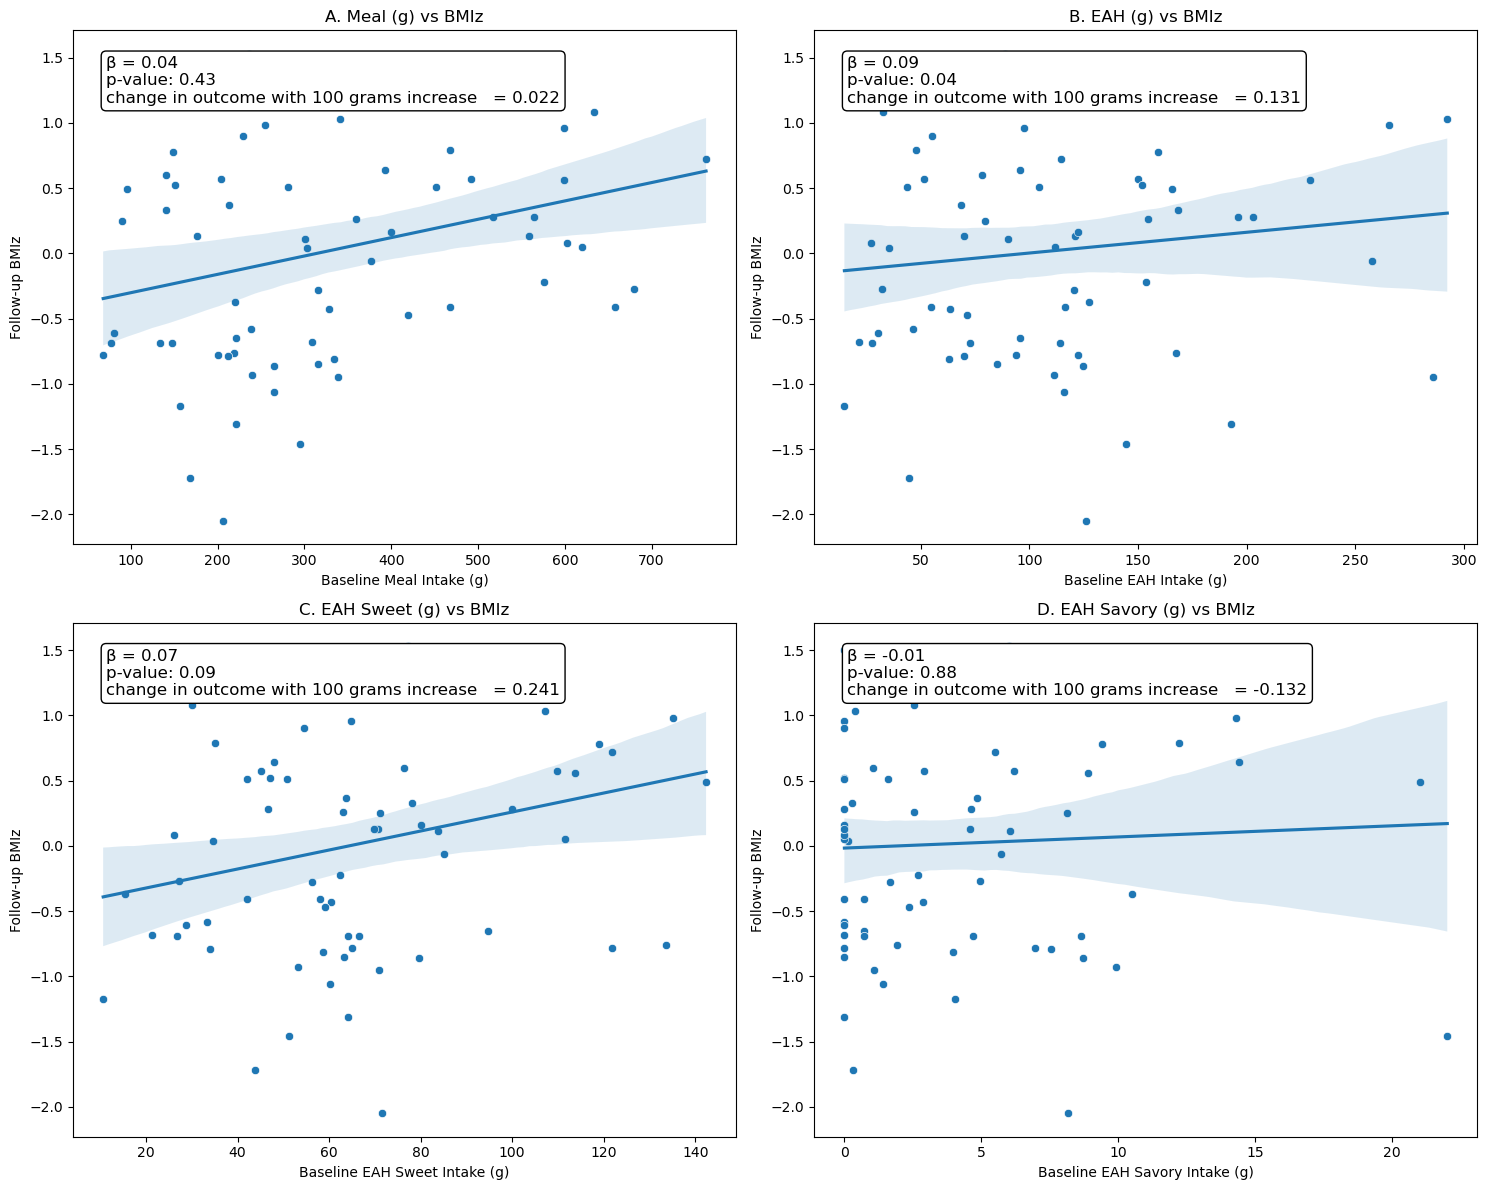

In [79]:
# First Graph: FMI vs. Meal, EAH, EAH Sweet, EAH Savory (all kcal)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_FMI', df_graph, axes[0, 0], 'Baseline Meal Intake (kcal)', 'Follow-up FMI (kg/m2)', 'A. Meal (kcal) vs FMI', coef_meal_kcal, pvalue_meal_kcal, change_meal_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_FMI', df_graph, axes[0, 1], 'Baseline EAH Intake (kcal)', 'Follow-up FMI (kg/m2)', 'B. EAH (kcal) vs FMI', coef_eah_kcal, pvalue_eah_kcal, change_eah_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_FMI', df_graph, axes[1, 0], 'Baseline EAH Sweet Intake (kcal)', 'Follow-up FMI (kg/m2)', 'C. EAH Sweet (kcal) vs FMI', coef_eah_sweet_kcal, pvalue_eah_sweet_kcal, change_eah_sweet_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_FMI', df_graph, axes[1, 1], 'Baseline EAH Savory Intake (kcal)', 'Follow-up FMI (kg/m2)', 'D. EAH Savory (kcal) vs FMI', coef_eah_sav_kcal, pvalue_eah_sav_kcal, change_eah_sav_kcal_FMI, 'kcal')
plt.tight_layout()
plt.show()

# Second Graph: FMI vs. Meal, EAH, EAH Sweet, EAH Savory (all grams)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_g', 'v7_FMI', df_graph, axes[0, 0], 'Baseline Meal Intake (g)', 'Follow-up FMI (kg/m2)', 'A. Meal (g) vs FMI', coef_meal_g, pvalue_meal_g, change_meal_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_g', 'v7_FMI', df_graph, axes[0, 1], 'Baseline EAH Intake (g)', 'Follow-up FMI (kg/m2)', 'B. EAH (g) vs FMI', coef_eah_g, pvalue_eah_g, change_eah_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_sweet_g', 'v7_FMI', df_graph, axes[1, 0], 'Baseline EAH Sweet Intake (g)', 'Follow-up FMI (kg/m2)', 'C. EAH Sweet (g) vs FMI', coef_eah_sweet_g, pvalue_eah_sweet_g, change_eah_sweet_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_sav_g', 'v7_FMI', df_graph, axes[1, 1], 'Baseline EAH Savory Intake (g)', 'Follow-up FMI (kg/m2)', 'D. EAH Savory (g) vs FMI', coef_eah_sav_g, pvalue_eah_sav_g, change_eah_sav_g_FMI, 'grams')
plt.tight_layout()
plt.show()

# Third Graph: BMIz vs. Meal, EAH, EAH Sweet, EAH Savory (all kcal)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_bmi_z', df_graph, axes[0, 0], 'Baseline Meal Intake (kcal)', 'Follow-up BMIz', 'A. Meal (kcal) vs BMIz', coef_meal_kcal_bmiz, pvalue_meal_kcal_bmiz, change_meal_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_bmi_z', df_graph, axes[0, 1], 'Baseline EAH Intake (kcal)', 'Follow-up BMIz', 'B. EAH (kcal) vs BMIz', coef_eah_kcal_bmiz, pvalue_eah_kcal_bmiz, change_eah_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_bmi_z', df_graph, axes[1, 0], 'Baseline EAH Sweet Intake (kcal)', 'Follow-up BMIz', 'C. EAH Sweet (kcal) vs BMIz', coef_eah_sweet_kcal_bmiz, pvalue_eah_sweet_kcal_bmiz, change_eah_sweet_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_bmi_z', df_graph, axes[1, 1], 'Baseline EAH Savory Intake (kcal)', 'Follow-up BMIz', 'D. EAH Savory (kcal) vs BMIz', coef_eah_sav_kcal_bmiz, pvalue_eah_sav_kcal_bmiz, change_eah_sav_kcal_BMIz, 'kcal')
plt.tight_layout()
plt.show()


# Fourth Graph: BMIz vs. Meal, EAH, EAH Sweet, EAH Savory (all grams)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_g', 'v7_bmi_z', df_graph, axes[0, 0], 'Baseline Meal Intake (g)', 'Follow-up BMIz', 'A. Meal (g) vs BMIz', coef_meal_g_bmiz, pvalue_meal_g_bmiz, change_meal_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_g', 'v7_bmi_z', df_graph, axes[0, 1], 'Baseline EAH Intake (g)', 'Follow-up BMIz', 'B. EAH (g) vs BMIz', coef_eah_g_bmiz, pvalue_eah_g_bmiz, change_eah_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_sweet_g', 'v7_bmi_z', df_graph, axes[1, 0], 'Baseline EAH Sweet Intake (g)', 'Follow-up BMIz', 'C. EAH Sweet (g) vs BMIz', coef_eah_sweet_g_bmiz, pvalue_eah_sweet_g_bmiz, change_eah_sweet_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_sav_g', 'v7_bmi_z', df_graph, axes[1, 1], 'Baseline EAH Savory Intake (g)', 'Follow-up BMIz', 'D. EAH Savory (g) vs BMIz', coef_eah_sav_g_bmiz, pvalue_eah_sav_g_bmiz, change_eah_sav_g_BMIz, 'grams')
plt.tight_layout()
plt.show()


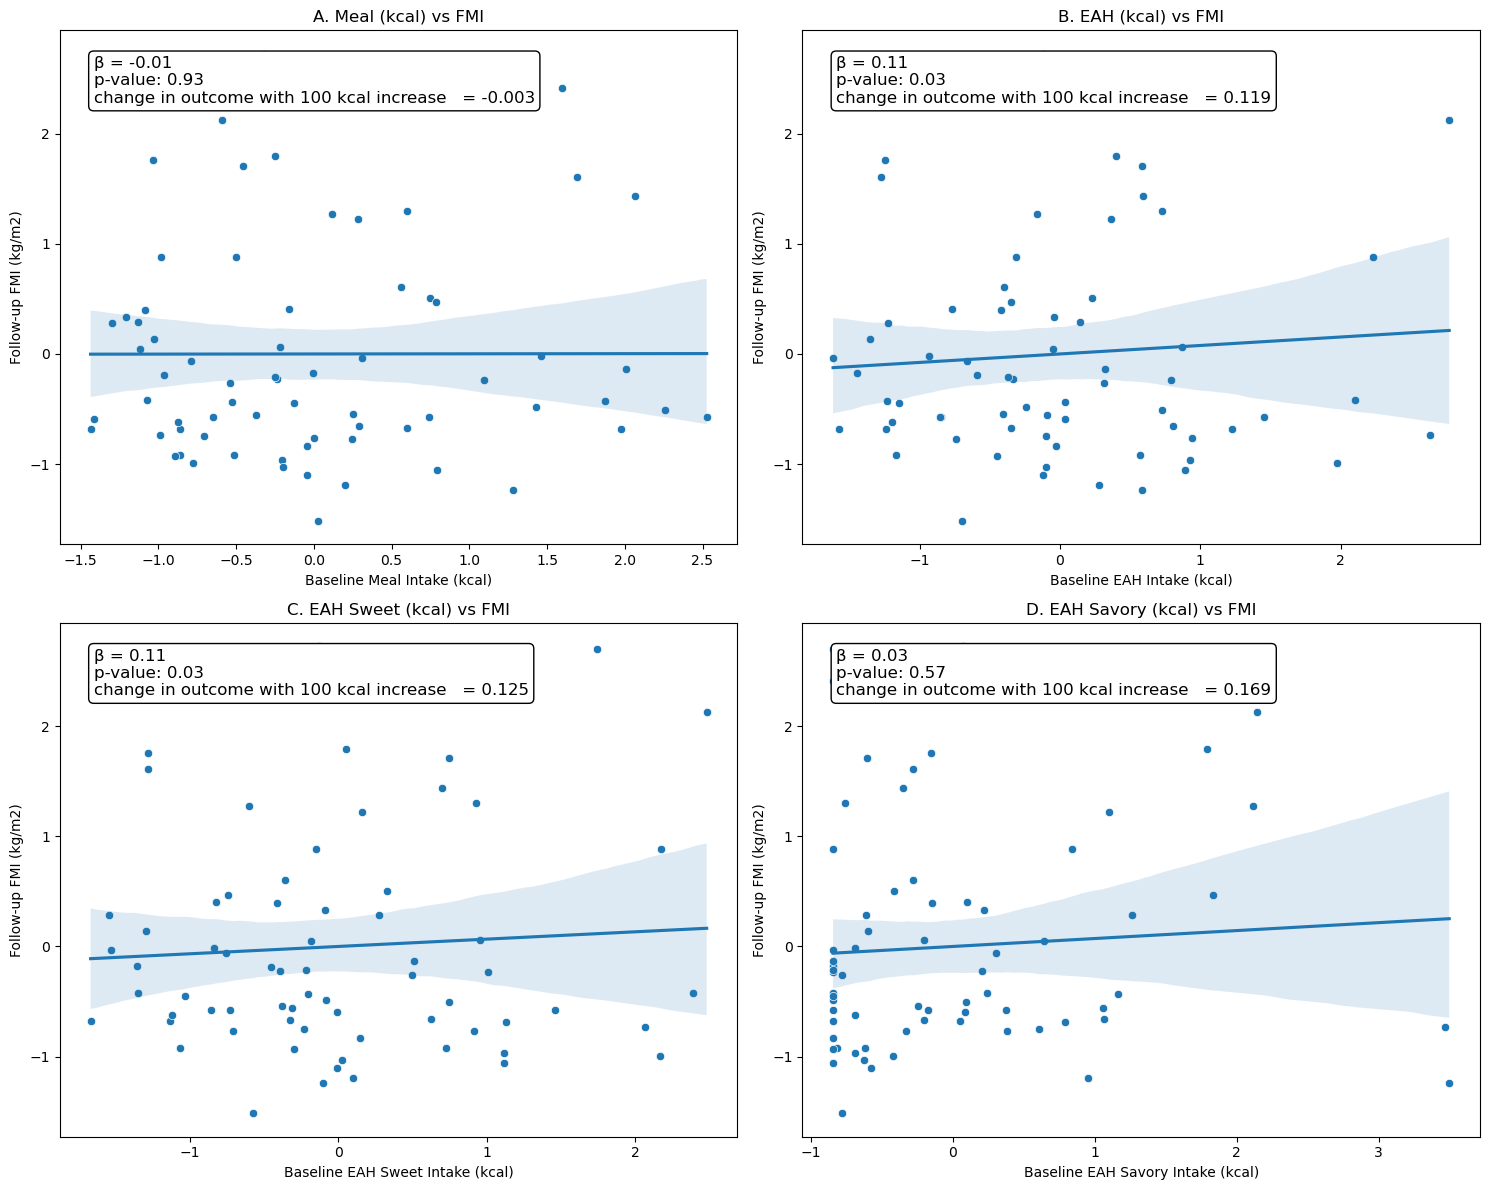

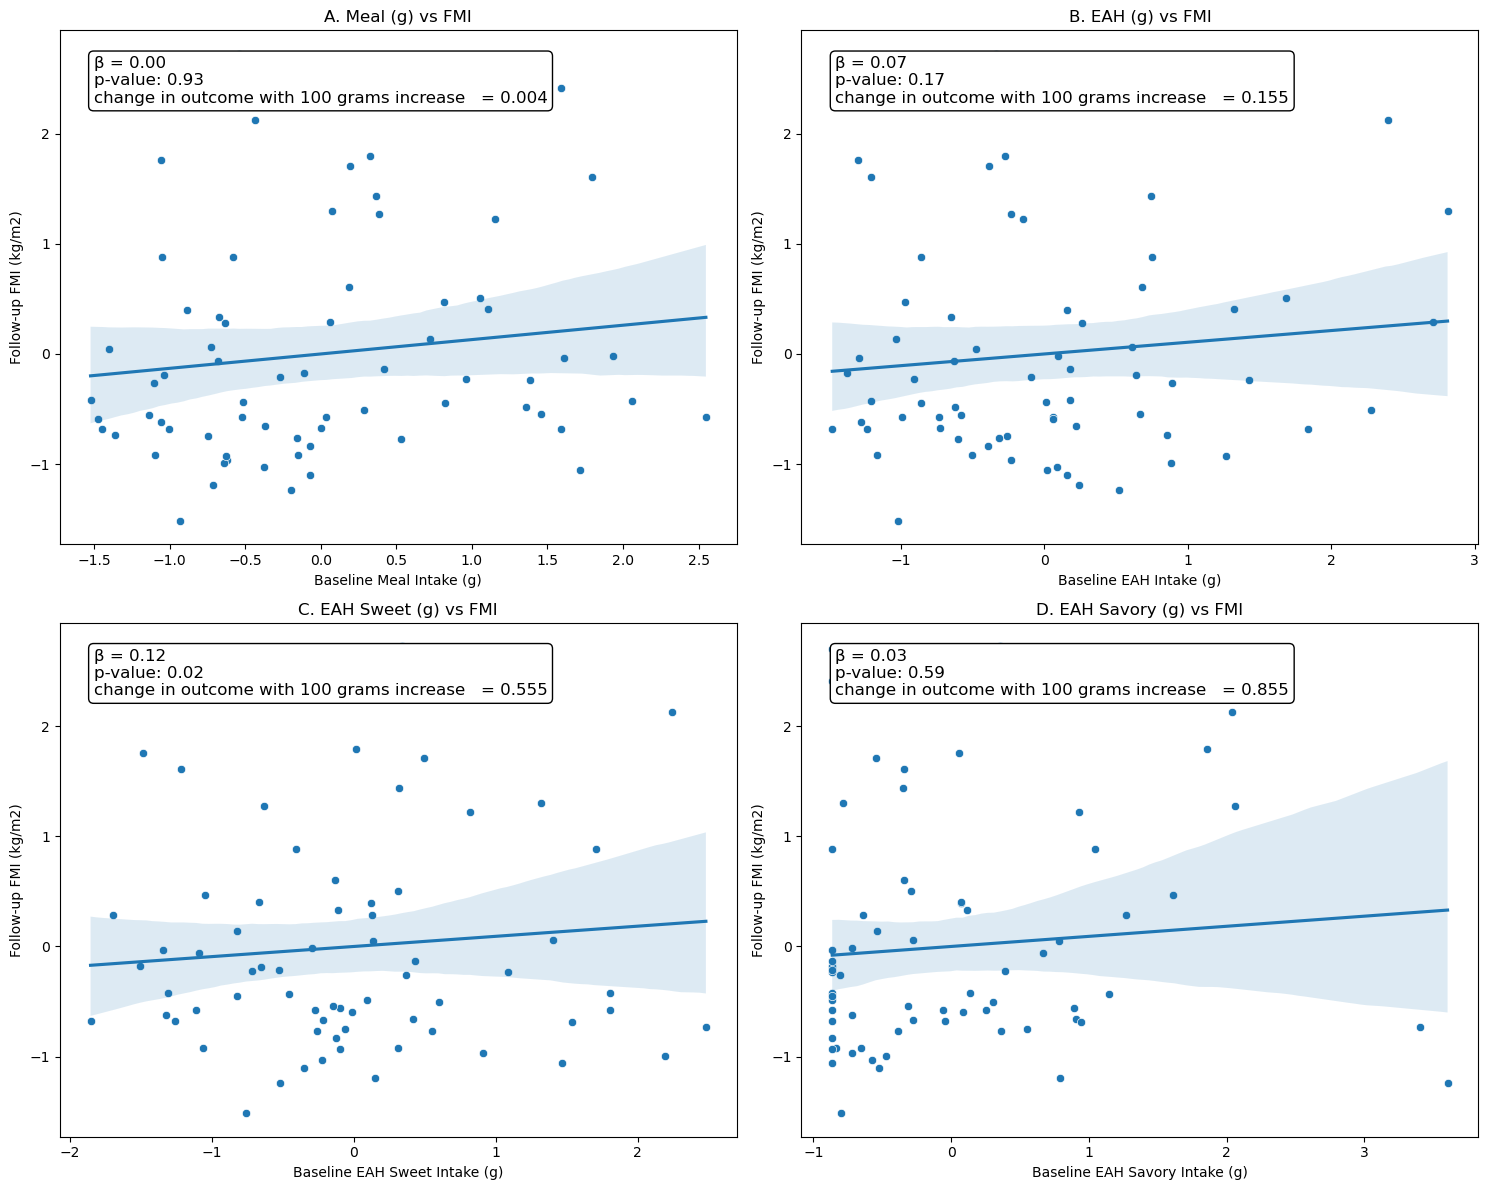

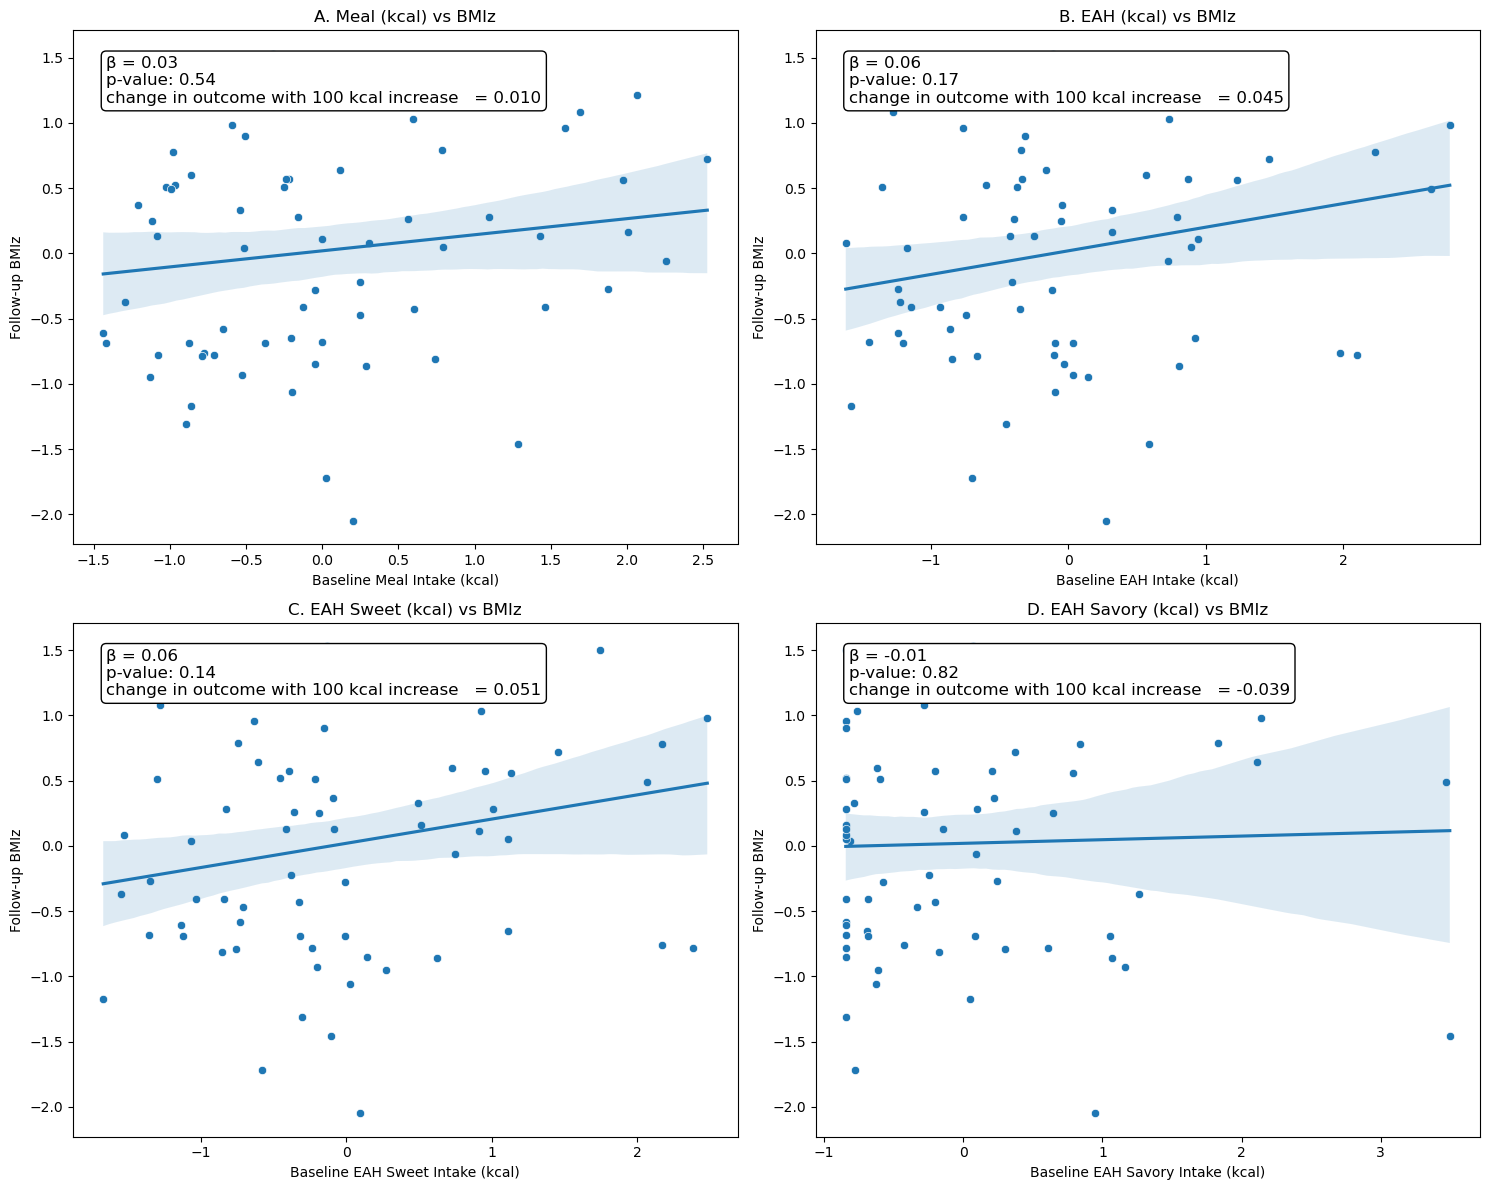

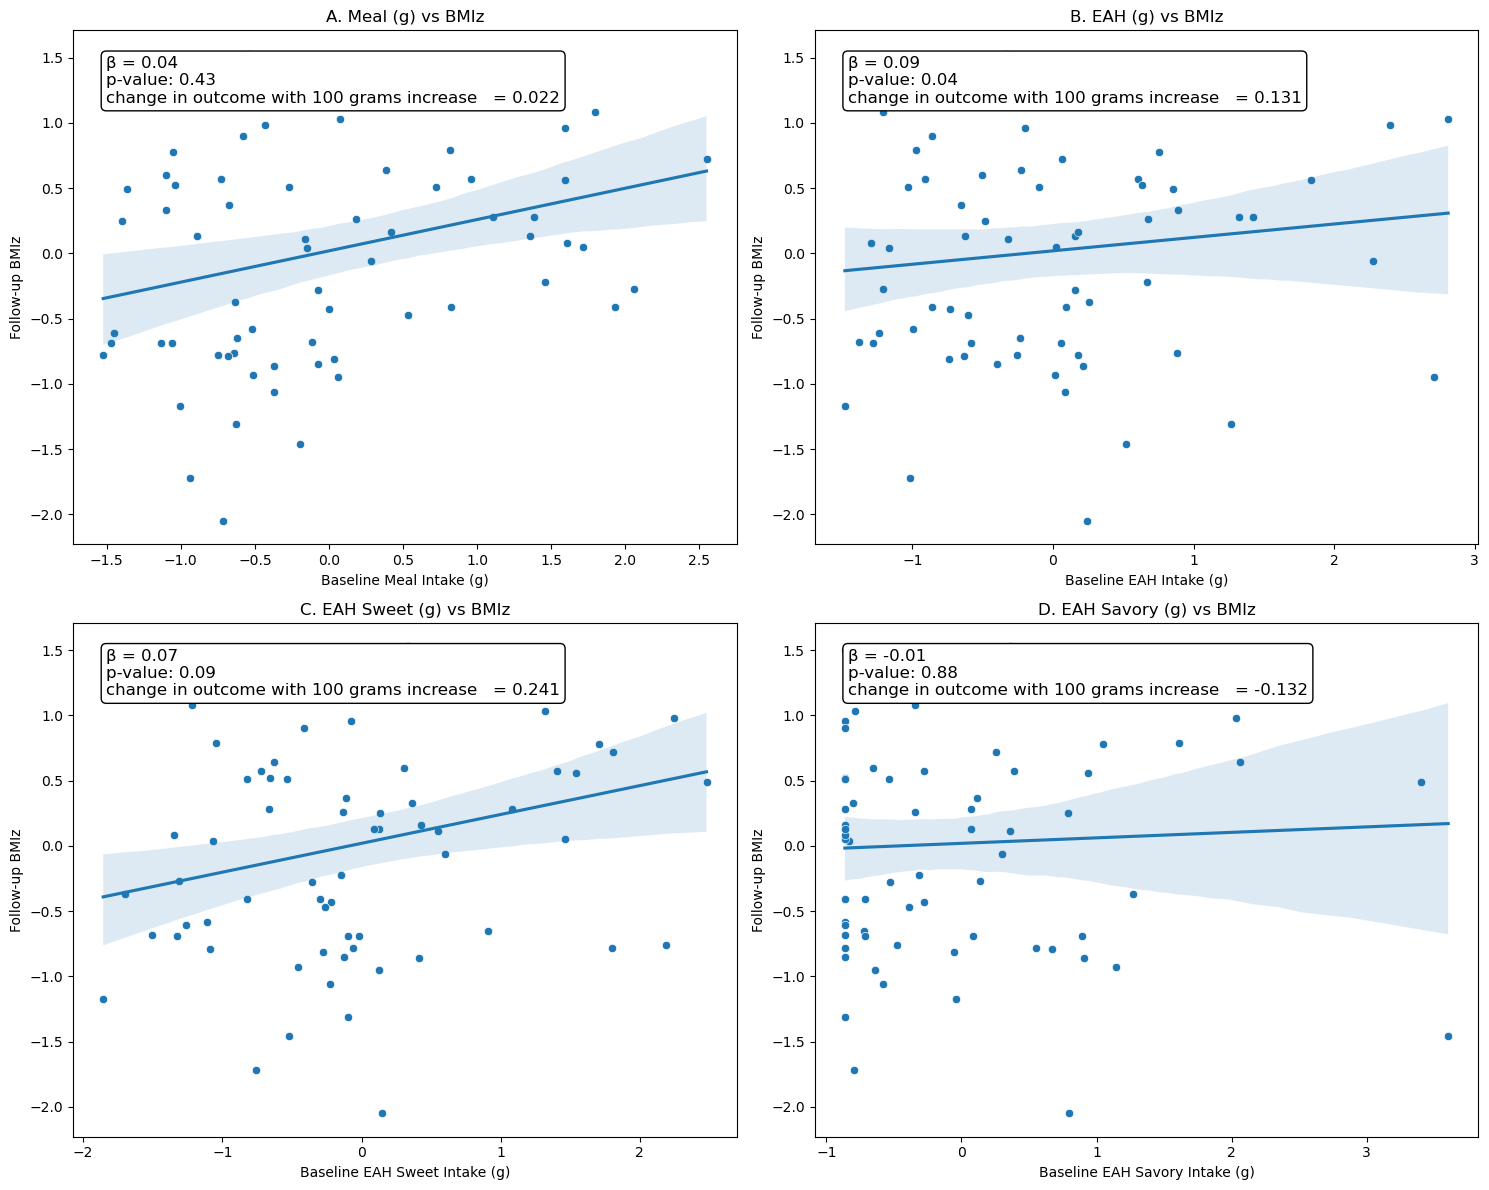

In [80]:
# First Graph: FMI vs. Meal, EAH, EAH Sweet, EAH Savory (all kcal)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_FMI', df_linear_reg, axes[0, 0], 'Baseline Meal Intake (kcal)', 'Follow-up FMI (kg/m2)', 'A. Meal (kcal) vs FMI', coef_meal_kcal, pvalue_meal_kcal, change_meal_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_FMI', df_linear_reg, axes[0, 1], 'Baseline EAH Intake (kcal)', 'Follow-up FMI (kg/m2)', 'B. EAH (kcal) vs FMI', coef_eah_kcal, pvalue_eah_kcal, change_eah_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_FMI', df_linear_reg, axes[1, 0], 'Baseline EAH Sweet Intake (kcal)', 'Follow-up FMI (kg/m2)', 'C. EAH Sweet (kcal) vs FMI', coef_eah_sweet_kcal, pvalue_eah_sweet_kcal, change_eah_sweet_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_FMI', df_linear_reg, axes[1, 1], 'Baseline EAH Savory Intake (kcal)', 'Follow-up FMI (kg/m2)', 'D. EAH Savory (kcal) vs FMI', coef_eah_sav_kcal, pvalue_eah_sav_kcal, change_eah_sav_kcal_FMI, 'kcal')
plt.tight_layout()
plt.show()

# Second Graph: FMI vs. Meal, EAH, EAH Sweet, EAH Savory (all grams)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_g', 'v7_FMI', df_linear_reg, axes[0, 0], 'Baseline Meal Intake (g)', 'Follow-up FMI (kg/m2)', 'A. Meal (g) vs FMI', coef_meal_g, pvalue_meal_g, change_meal_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_g', 'v7_FMI', df_linear_reg, axes[0, 1], 'Baseline EAH Intake (g)', 'Follow-up FMI (kg/m2)', 'B. EAH (g) vs FMI', coef_eah_g, pvalue_eah_g, change_eah_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_sweet_g', 'v7_FMI', df_linear_reg, axes[1, 0], 'Baseline EAH Sweet Intake (g)', 'Follow-up FMI (kg/m2)', 'C. EAH Sweet (g) vs FMI', coef_eah_sweet_g, pvalue_eah_sweet_g, change_eah_sweet_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_sav_g', 'v7_FMI', df_linear_reg, axes[1, 1], 'Baseline EAH Savory Intake (g)', 'Follow-up FMI (kg/m2)', 'D. EAH Savory (g) vs FMI', coef_eah_sav_g, pvalue_eah_sav_g, change_eah_sav_g_FMI, 'grams')
plt.tight_layout()
plt.show()

# Third Graph: BMIz vs. Meal, EAH, EAH Sweet, EAH Savory (all kcal)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_bmi_z', df_linear_reg, axes[0, 0], 'Baseline Meal Intake (kcal)', 'Follow-up BMIz', 'A. Meal (kcal) vs BMIz', coef_meal_kcal_bmiz, pvalue_meal_kcal_bmiz, change_meal_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_bmi_z', df_linear_reg, axes[0, 1], 'Baseline EAH Intake (kcal)', 'Follow-up BMIz', 'B. EAH (kcal) vs BMIz', coef_eah_kcal_bmiz, pvalue_eah_kcal_bmiz, change_eah_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_bmi_z', df_linear_reg, axes[1, 0], 'Baseline EAH Sweet Intake (kcal)', 'Follow-up BMIz', 'C. EAH Sweet (kcal) vs BMIz', coef_eah_sweet_kcal_bmiz, pvalue_eah_sweet_kcal_bmiz, change_eah_sweet_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_bmi_z', df_linear_reg, axes[1, 1], 'Baseline EAH Savory Intake (kcal)', 'Follow-up BMIz', 'D. EAH Savory (kcal) vs BMIz', coef_eah_sav_kcal_bmiz, pvalue_eah_sav_kcal_bmiz, change_eah_sav_kcal_BMIz, 'kcal')
plt.tight_layout()
plt.show()


# Fourth Graph: BMIz vs. Meal, EAH, EAH Sweet, EAH Savory (all grams)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_g', 'v7_bmi_z', df_linear_reg, axes[0, 0], 'Baseline Meal Intake (g)', 'Follow-up BMIz', 'A. Meal (g) vs BMIz', coef_meal_g_bmiz, pvalue_meal_g_bmiz, change_meal_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_g', 'v7_bmi_z', df_linear_reg, axes[0, 1], 'Baseline EAH Intake (g)', 'Follow-up BMIz', 'B. EAH (g) vs BMIz', coef_eah_g_bmiz, pvalue_eah_g_bmiz, change_eah_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_sweet_g', 'v7_bmi_z', df_linear_reg, axes[1, 0], 'Baseline EAH Sweet Intake (g)', 'Follow-up BMIz', 'C. EAH Sweet (g) vs BMIz', coef_eah_sweet_g_bmiz, pvalue_eah_sweet_g_bmiz, change_eah_sweet_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_sav_g', 'v7_bmi_z', df_linear_reg, axes[1, 1], 'Baseline EAH Savory Intake (g)', 'Follow-up BMIz', 'D. EAH Savory (g) vs BMIz', coef_eah_sav_g_bmiz, pvalue_eah_sav_g_bmiz, change_eah_sav_g_BMIz, 'grams')
plt.tight_layout()
plt.show()



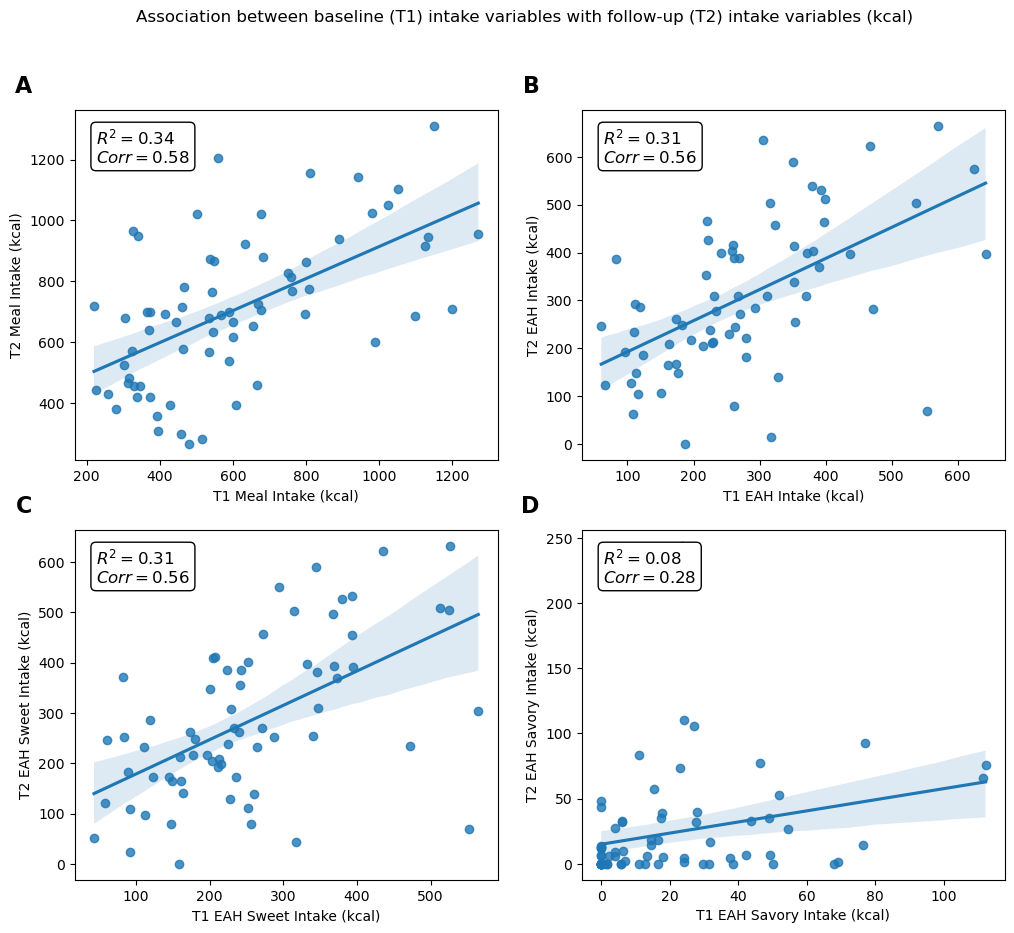

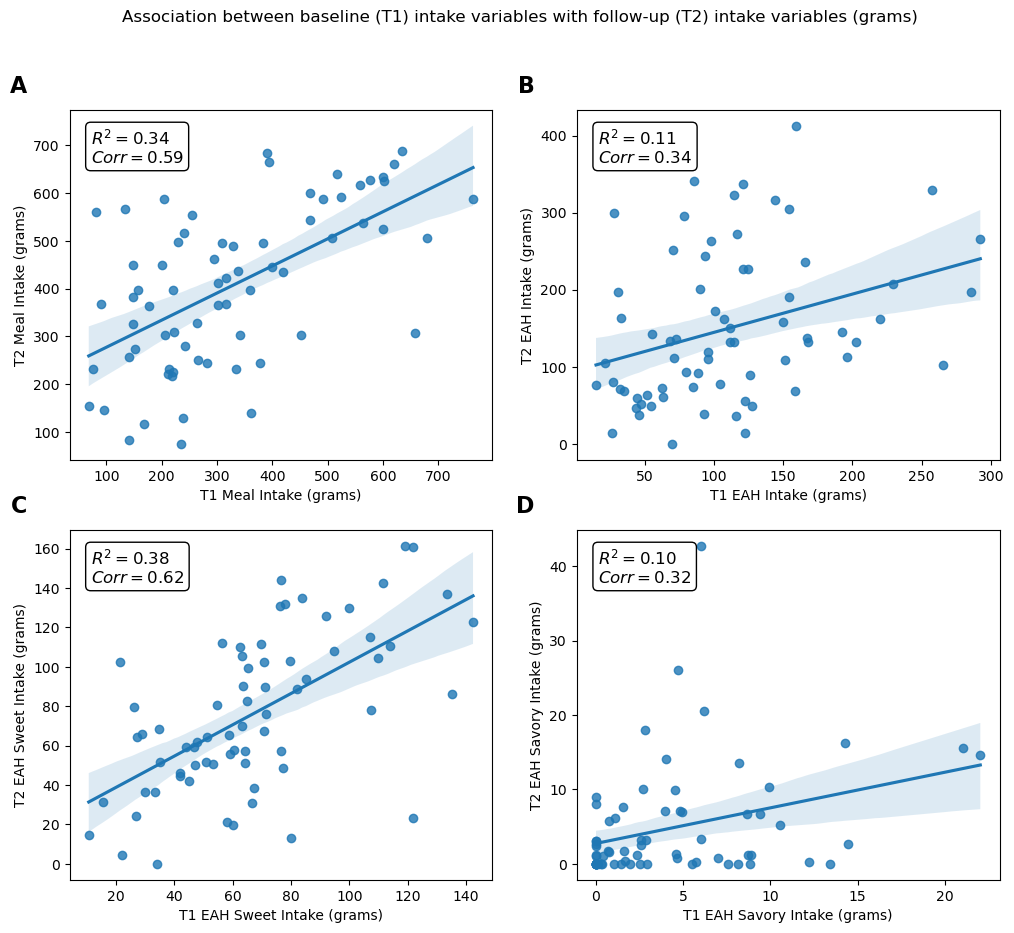

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

# Function to create scatter plots with R2 and correlation coefficient
def scatter_plot_with_stats(ax, x, y, x_label, y_label):
    sns.regplot(x=x, y=y, ax=ax, scatter_kws={'color': '#1f77b4'}, line_kws={'color': '#1f77b4'})
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # Fit linear model
    model = LinearRegression().fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
    y_pred = model.predict(x.values.reshape(-1, 1))
    
    # Calculate R2 and correlation coefficient
    r2 = r2_score(y, y_pred)
    corr_coeff = x.corr(y)
    
    # Add text box with R2 and correlation coefficient
    textstr = f'$R^2 = {r2:.2f}$\n$Corr = {corr_coeff:.2f}$'
    props = dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

# Create the 2x2 subplot for the first graph
fig1, axs1 = plt.subplots(2, 2, figsize=(12, 10))
fig1.suptitle('Association between baseline (T1) intake variables with follow-up (T2) intake variables (kcal)')

variables_kcal = [
    ('v1_meal_kcal', 'v7_meal_kcal', 'T1 Meal Intake (kcal)', 'T2 Meal Intake (kcal)'),
    ('v1_eah_kcal', 'v7_eah_kcal', 'T1 EAH Intake (kcal)', 'T2 EAH Intake (kcal)'),
    ('v1_eah_sweet_kcal', 'v7_eah_sweet_kcal', 'T1 EAH Sweet Intake (kcal)', 'T2 EAH Sweet Intake (kcal)'),
    ('v1_eah_sav_kcal', 'v7_eah_sav_kcal', 'T1 EAH Savory Intake (kcal)', 'T2 EAH Savory Intake (kcal)')
]

# Label for the subplots
labels = ['A', 'B', 'C', 'D']

for ax, (x_var, y_var, x_label, y_label), label in zip(axs1.ravel(), variables_kcal, labels):
    scatter_plot_with_stats(ax, df_graph[x_var], df_graph[y_var], x_label, y_label)
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Create the 2x2 subplot for the second graph
fig2, axs2 = plt.subplots(2, 2, figsize=(12, 10))
fig2.suptitle('Association between baseline (T1) intake variables with follow-up (T2) intake variables (grams)')

variables_g = [
    ('v1_meal_g', 'v7_meal_g', 'T1 Meal Intake (grams)', 'T2 Meal Intake (grams)'),
    ('v1_eah_g', 'v7_eah_g', 'T1 EAH Intake (grams)', 'T2 EAH Intake (grams)'),
    ('v1_eah_sweet_g', 'v7_eah_sweet_g', 'T1 EAH Sweet Intake (grams)', 'T2 EAH Sweet Intake (grams)'),
    ('v1_eah_sav_g', 'v7_eah_sav_g', 'T1 EAH Savory Intake (grams)', 'T2 EAH Savory Intake (grams)')
]

# Label for the subplots
labels = ['A', 'B', 'C', 'D']

for ax, (x_var, y_var, x_label, y_label), label in zip(axs2.ravel(), variables_g, labels):
    scatter_plot_with_stats(ax, df_graph[x_var], df_graph[y_var], x_label, y_label)
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Show the plots
plt.show()

# partial reg corr

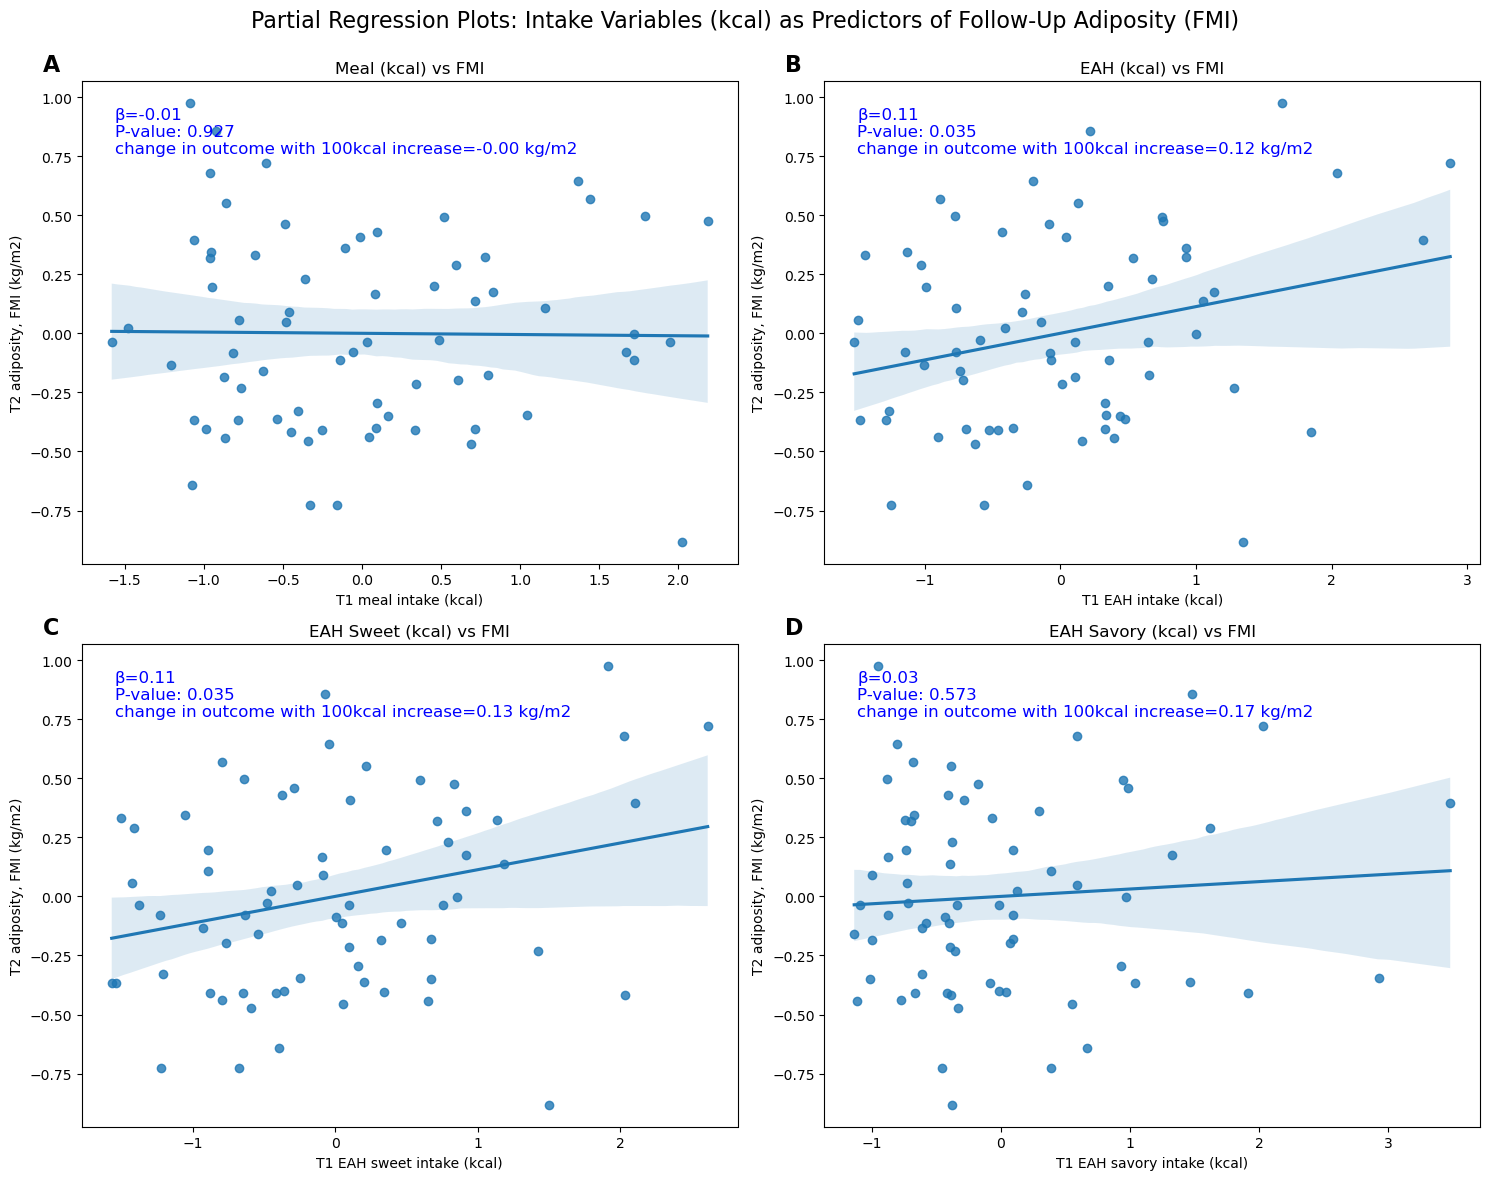

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Create a model for each independent variable and calculate residuals

# Meal (kcal) vs FMI
X_meal = df_linear_reg[['v1_FMI', 'sex','risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff']]
y_meal = df_linear_reg['v7_FMI']
X_meal_const = sm.add_constant(X_meal)

# Regressing v7_FMI on all covariates
mod_FMI = sm.OLS(y_meal, X_meal_const).fit()
resid_FMI = mod_FMI.resid

# Regressing v1_meal_kcal on all covariates
mod_meal = sm.OLS(df_linear_reg['v1_meal_kcal'], X_meal_const).fit()
resid_meal_kcal = mod_meal.resid

# EAH (kcal) vs FMI
mod_eah = sm.OLS(df_linear_reg['v1_eah_kcal'], X_meal_const).fit()
resid_eah_kcal = mod_eah.resid

# EAH sweet (kcal) vs FMI
mod_eah_sweet = sm.OLS(df_linear_reg['v1_eah_sweet_kcal'], X_meal_const).fit()
resid_eah_sweet_kcal = mod_eah_sweet.resid

# EAH savory (kcal) vs FMI
mod_eah_sav = sm.OLS(df_linear_reg['v1_eah_sav_kcal'], X_meal_const).fit()
resid_eah_sav_kcal = mod_eah_sav.resid

# Plotting the residuals
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot for Meal (kcal) vs FMI residuals
sns.regplot(x=resid_meal_kcal, y=resid_FMI, ax=axes[0, 0])
axes[0, 0].set_xlabel("T1 meal intake (kcal)")
axes[0, 0].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[0, 0].set_title("Meal (kcal) vs FMI")
axes[0, 0].annotate(f"β={mod_mealkcalFMI.params['v1_meal_kcal']:.2f}\nP-value: {mod_mealkcalFMI.pvalues['v1_meal_kcal']:.3f}\nchange in outcome with 100kcal increase={change_meal_kcal_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH total (kcal) vs FMI residuals
sns.regplot(x=resid_eah_kcal, y=resid_FMI, ax=axes[0, 1])
axes[0, 1].set_xlabel("T1 EAH intake (kcal)")
axes[0, 1].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[0, 1].set_title("EAH (kcal) vs FMI")
axes[0, 1].annotate(f"β={mod_EAHkcalFMI.params['v1_eah_kcal']:.2f}\nP-value: {mod_EAHkcalFMI.pvalues['v1_eah_kcal']:.3f}\nchange in outcome with 100kcal increase={change_eah_kcal_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH sweet (kcal) vs FMI residuals
sns.regplot(x=resid_eah_sweet_kcal, y=resid_FMI, ax=axes[1, 0])
axes[1, 0].set_xlabel("T1 EAH sweet intake (kcal)")
axes[1, 0].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[1, 0].set_title("EAH Sweet (kcal) vs FMI")
axes[1, 0].annotate(f"β={mod_EAHsweetkcalFMI.params['v1_eah_sweet_kcal']:.2f}\nP-value: {mod_EAHsweetkcalFMI.pvalues['v1_eah_sweet_kcal']:.3f}\nchange in outcome with 100kcal increase={change_eah_sweet_kcal_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 0].annotate('C', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH savory (kcal) vs FMI residuals
sns.regplot(x=resid_eah_sav_kcal, y=resid_FMI, ax=axes[1, 1])
axes[1, 1].set_xlabel("T1 EAH savory intake (kcal)")
axes[1, 1].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[1, 1].set_title("EAH Savory (kcal) vs FMI")
axes[1, 1].annotate(f"β={mod_EAHsavkcalFMI.params['v1_eah_sav_kcal']:.2f}\nP-value: {mod_EAHsavkcalFMI.pvalues['v1_eah_sav_kcal']:.3f}\nchange in outcome with 100kcal increase={change_eah_sav_kcal_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 1].annotate('D', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Partial Regression Plots: Intake Variables (kcal) as Predictors of Follow-Up Adiposity (FMI)", fontsize=16)
plt.show()

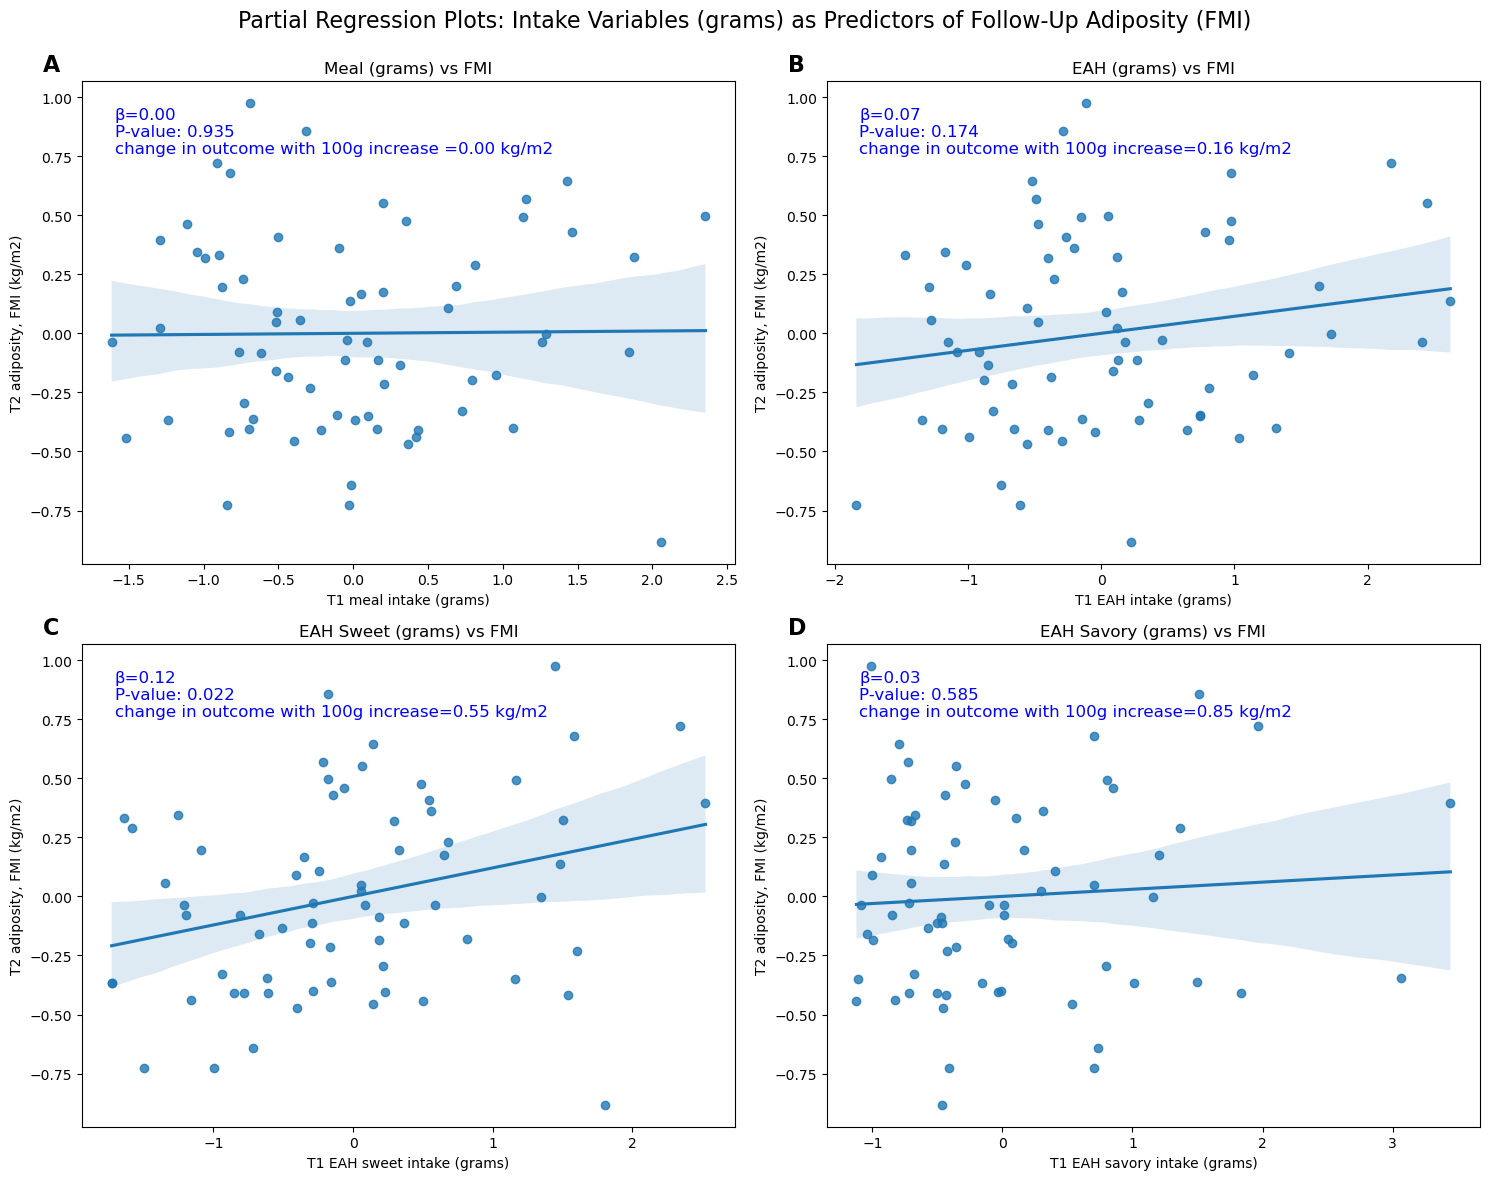

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Create a model for each independent variable and calculate residuals

# Meal (grams) vs FMI
X_meal = df_linear_reg[['v1_FMI', 'sex','risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff']]
y_meal = df_linear_reg['v7_FMI']
X_meal_const = sm.add_constant(X_meal)

# Regressing v7_FMI on all covariates
mod_FMI = sm.OLS(y_meal, X_meal_const).fit()
resid_FMI = mod_FMI.resid

# Regressing v1_meal_grams on all covariates
mod_meal = sm.OLS(df_linear_reg['v1_meal_g'], X_meal_const).fit()
resid_meal_grams = mod_meal.resid

# EAH (grams) vs FMI
mod_eah = sm.OLS(df_linear_reg['v1_eah_g'], X_meal_const).fit()
resid_eah_grams = mod_eah.resid

# EAH sweet (grams) vs FMI
mod_eah_sweet = sm.OLS(df_linear_reg['v1_eah_sweet_g'], X_meal_const).fit()
resid_eah_sweet_grams = mod_eah_sweet.resid

# EAH savory (grams) vs FMI
mod_eah_sav = sm.OLS(df_linear_reg['v1_eah_sav_g'], X_meal_const).fit()
resid_eah_sav_grams = mod_eah_sav.resid

# Plotting the residuals
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot for Meal (grams) vs FMI residuals
sns.regplot(x=resid_meal_grams, y=resid_FMI, ax=axes[0, 0])
axes[0, 0].set_xlabel("T1 meal intake (grams)")
axes[0, 0].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[0, 0].set_title("Meal (grams) vs FMI")
axes[0, 0].annotate(f"β={mod_mealgFMI.params['v1_meal_g']:.2f}\nP-value: {mod_mealgFMI.pvalues['v1_meal_g']:.3f}\nchange in outcome with 100g increase ={change_meal_g_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH total (grams) vs FMI residuals
sns.regplot(x=resid_eah_grams, y=resid_FMI, ax=axes[0, 1])
axes[0, 1].set_xlabel("T1 EAH intake (grams)")
axes[0, 1].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[0, 1].set_title("EAH (grams) vs FMI")
axes[0, 1].annotate(f"β={mod_EAHgFMI.params['v1_eah_g']:.2f}\nP-value: {mod_EAHgFMI.pvalues['v1_eah_g']:.3f}\nchange in outcome with 100g increase={change_eah_g_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH sweet (grams) vs FMI residuals
sns.regplot(x=resid_eah_sweet_grams, y=resid_FMI, ax=axes[1, 0])
axes[1, 0].set_xlabel("T1 EAH sweet intake (grams)")
axes[1, 0].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[1, 0].set_title("EAH Sweet (grams) vs FMI")
axes[1, 0].annotate(f"β={mod_EAHsweetgFMI.params['v1_eah_sweet_g']:.2f}\nP-value: {mod_EAHsweetgFMI.pvalues['v1_eah_sweet_g']:.3f}\nchange in outcome with 100g increase={change_eah_sweet_g_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 0].annotate('C', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH savory (grams) vs FMI residuals
sns.regplot(x=resid_eah_sav_grams, y=resid_FMI, ax=axes[1, 1])
axes[1, 1].set_xlabel("T1 EAH savory intake (grams)")
axes[1, 1].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[1, 1].set_title("EAH Savory (grams) vs FMI")
axes[1, 1].annotate(f"β={mod_EAHsavgFMI.params['v1_eah_sav_g']:.2f}\nP-value: {mod_EAHsavgFMI.pvalues['v1_eah_sav_g']:.3f}\nchange in outcome with 100g increase={change_eah_sav_g_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 1].annotate('D', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Partial Regression Plots: Intake Variables (grams) as Predictors of Follow-Up Adiposity (FMI)", fontsize=16)
plt.show()

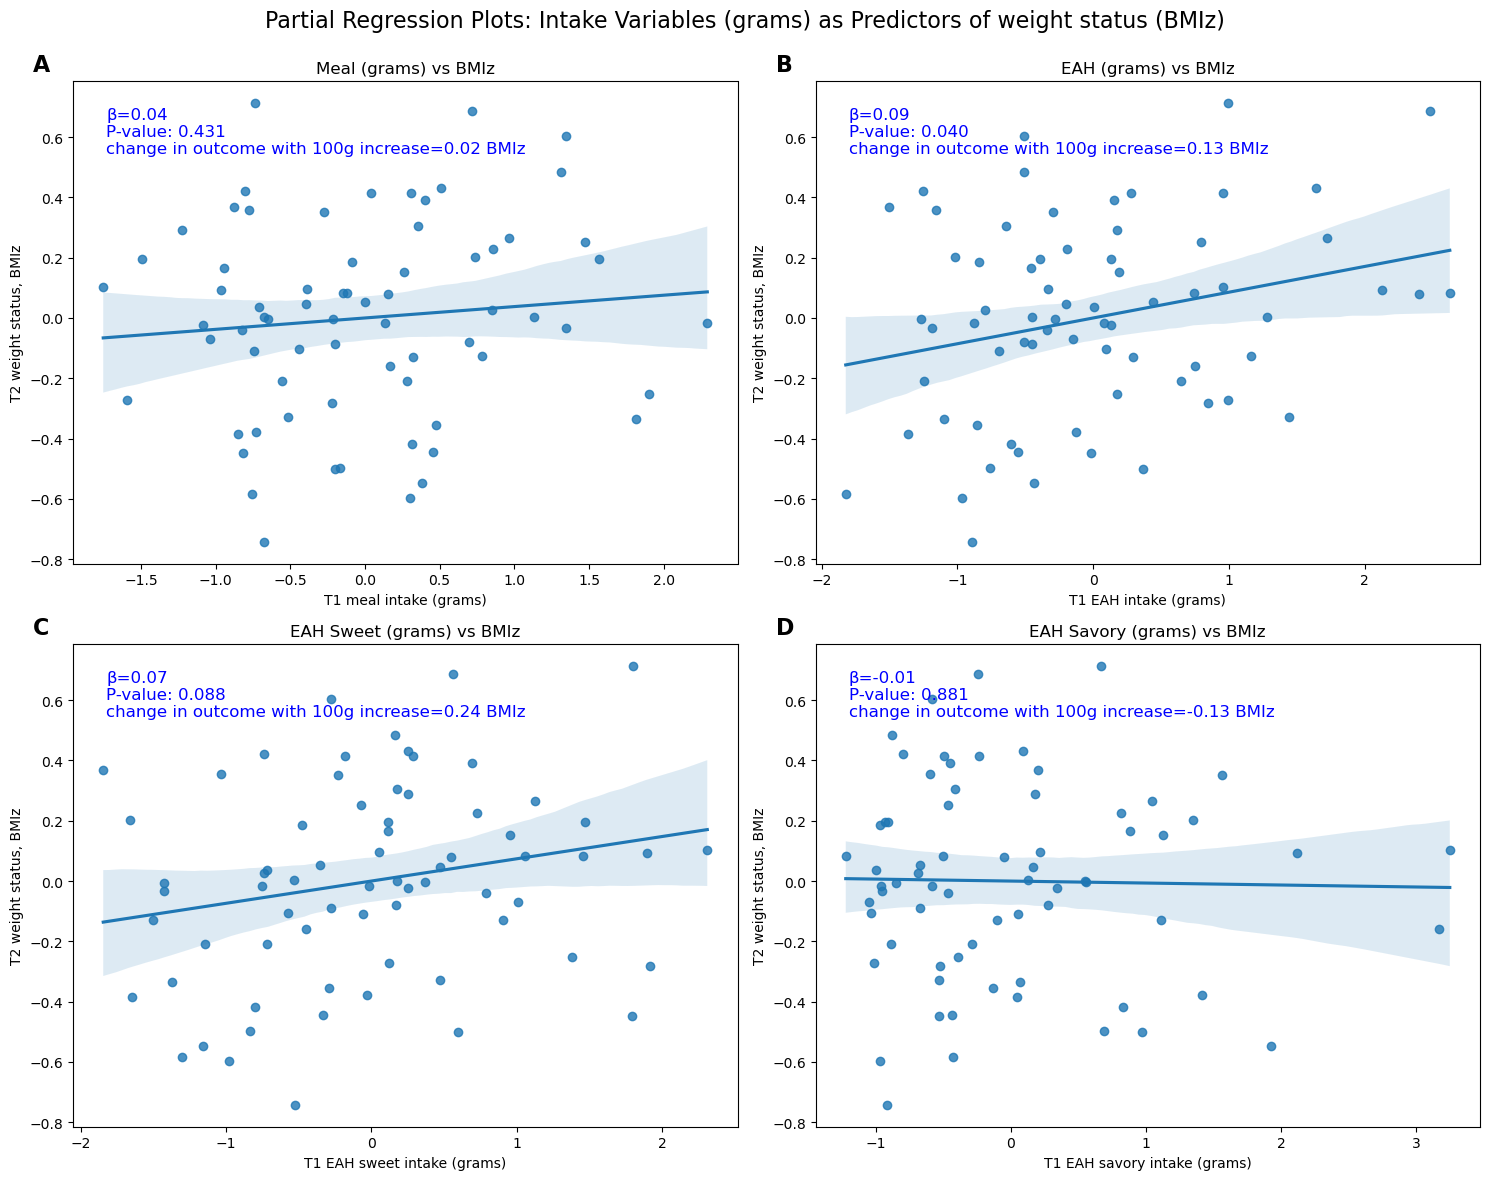

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Create a model for each independent variable and calculate residuals

# Meal (grams) vs BMIz
X_meal = df_linear_reg[['bmi_z', 'sex','risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff']]
y_meal = df_linear_reg['v7_bmi_z']
X_meal_const = sm.add_constant(X_meal)

# Regressing v7_BMIz on all covariates
mod_BMIz = sm.OLS(y_meal, X_meal_const).fit()
resid_BMIz = mod_BMIz.resid

# Regressing v1_meal_grams on all covariates
mod_meal = sm.OLS(df_linear_reg['v1_meal_g'], X_meal_const).fit()
resid_meal_grams = mod_meal.resid

# EAH (grams) vs BMIz
mod_eah = sm.OLS(df_linear_reg['v1_eah_g'], X_meal_const).fit()
resid_eah_grams = mod_eah.resid

# EAH sweet (grams) vs BMIz
mod_eah_sweet = sm.OLS(df_linear_reg['v1_eah_sweet_g'], X_meal_const).fit()
resid_eah_sweet_grams = mod_eah_sweet.resid

# EAH savory (grams) vs BMIz
mod_eah_sav = sm.OLS(df_linear_reg['v1_eah_sav_g'], X_meal_const).fit()
resid_eah_sav_grams = mod_eah_sav.resid

# Plotting the residuals
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot for Meal (grams) vs BMIz residuals
sns.regplot(x=resid_meal_grams, y=resid_BMIz, ax=axes[0, 0])
axes[0, 0].set_xlabel("T1 meal intake (grams)")
axes[0, 0].set_ylabel("T2 weight status, BMIz")
axes[0, 0].set_title("Meal (grams) vs BMIz")
axes[0, 0].annotate(f"β={mod_mealgBMIz.params['v1_meal_g']:.2f}\nP-value: {mod_mealgBMIz.pvalues['v1_meal_g']:.3f}\nchange in outcome with 100g increase={change_meal_g_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH total (grams) vs BMIz residuals
sns.regplot(x=resid_eah_grams, y=resid_BMIz, ax=axes[0, 1])
axes[0, 1].set_xlabel("T1 EAH intake (grams)")
axes[0, 1].set_ylabel("T2 weight status, BMIz")
axes[0, 1].set_title("EAH (grams) vs BMIz")
axes[0, 1].annotate(f"β={mod_EAHgBMIz.params['v1_eah_g']:.2f}\nP-value: {mod_EAHgBMIz.pvalues['v1_eah_g']:.3f}\nchange in outcome with 100g increase={change_eah_g_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH sweet (grams) vs BMIz residuals
sns.regplot(x=resid_eah_sweet_grams, y=resid_BMIz, ax=axes[1, 0])
axes[1, 0].set_xlabel("T1 EAH sweet intake (grams)")
axes[1, 0].set_ylabel("T2 weight status, BMIz")
axes[1, 0].set_title("EAH Sweet (grams) vs BMIz")
axes[1, 0].annotate(f"β={mod_EAHsweetgBMIz.params['v1_eah_sweet_g']:.2f}\nP-value: {mod_EAHsweetgBMIz.pvalues['v1_eah_sweet_g']:.3f}\nchange in outcome with 100g increase={change_eah_sweet_g_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 0].annotate('C', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH savory (grams) vs BMIz residuals
sns.regplot(x=resid_eah_sav_grams, y=resid_BMIz, ax=axes[1, 1])
axes[1, 1].set_xlabel("T1 EAH savory intake (grams)")
axes[1, 1].set_ylabel("T2 weight status, BMIz")
axes[1, 1].set_title("EAH Savory (grams) vs BMIz")
axes[1, 1].annotate(f"β={mod_EAHsavgBMIz.params['v1_eah_sav_g']:.2f}\nP-value: {mod_EAHsavgBMIz.pvalues['v1_eah_sav_g']:.3f}\nchange in outcome with 100g increase={change_eah_sav_g_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 1].annotate('D', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Partial Regression Plots: Intake Variables (grams) as Predictors of weight status (BMIz)", fontsize=16)
plt.show()


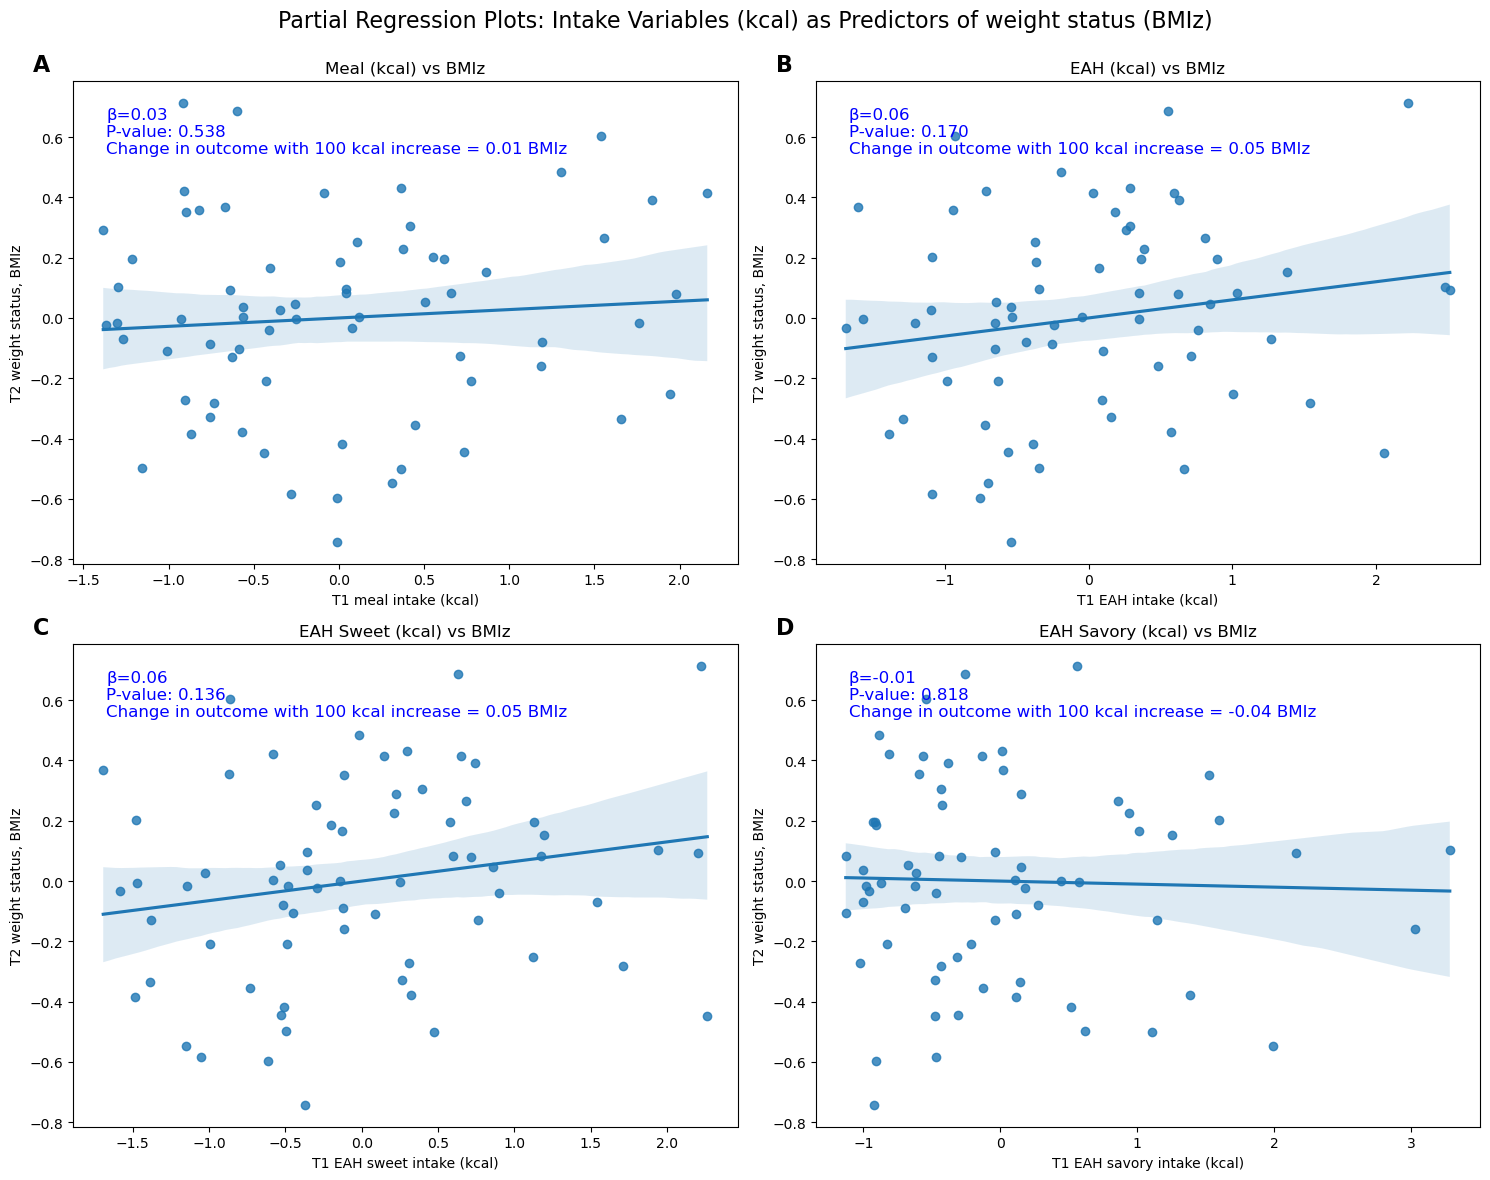

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Create a model for each independent variable and calculate residuals

# Meal (kcal) vs BMIz
X_meal = df_linear_reg[['bmi_z', 'sex','risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff']]
y_meal = df_linear_reg['v7_bmi_z']
X_meal_const = sm.add_constant(X_meal)

# Regressing v7_BMIz on all covariates
mod_BMIz = sm.OLS(y_meal, X_meal_const).fit()
resid_BMIz = mod_BMIz.resid

# Regressing v1_meal_kcal on all covariates
mod_meal = sm.OLS(df_linear_reg['v1_meal_kcal'], X_meal_const).fit()
resid_meal_kcal = mod_meal.resid

# EAH (kcal) vs BMIz
mod_eah = sm.OLS(df_linear_reg['v1_eah_kcal'], X_meal_const).fit()
resid_eah_kcal = mod_eah.resid

# EAH sweet (kcal) vs BMIz
mod_eah_sweet = sm.OLS(df_linear_reg['v1_eah_sweet_kcal'], X_meal_const).fit()
resid_eah_sweet_kcal = mod_eah_sweet.resid

# EAH savory (kcal) vs BMIz
mod_eah_sav = sm.OLS(df_linear_reg['v1_eah_sav_kcal'], X_meal_const).fit()
resid_eah_sav_kcal = mod_eah_sav.resid

# Plotting the residuals
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot for Meal (kcal) vs BMIz residuals
sns.regplot(x=resid_meal_kcal, y=resid_BMIz, ax=axes[0, 0])
axes[0, 0].set_xlabel("T1 meal intake (kcal)")
axes[0, 0].set_ylabel("T2 weight status, BMIz")
axes[0, 0].set_title("Meal (kcal) vs BMIz")
axes[0, 0].annotate(f"β={mod_mealkcalBMIz.params['v1_meal_kcal']:.2f}\nP-value: {mod_mealkcalBMIz.pvalues['v1_meal_kcal']:.3f}\nChange in outcome with 100 kcal increase = {change_meal_kcal_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH total (kcal) vs BMIz residuals
sns.regplot(x=resid_eah_kcal, y=resid_BMIz, ax=axes[0, 1])
axes[0, 1].set_xlabel("T1 EAH intake (kcal)")
axes[0, 1].set_ylabel("T2 weight status, BMIz")
axes[0, 1].set_title("EAH (kcal) vs BMIz")
axes[0, 1].annotate(f"β={mod_EAHkcalBMIz.params['v1_eah_kcal']:.2f}\nP-value: {mod_EAHkcalBMIz.pvalues['v1_eah_kcal']:.3f}\nChange in outcome with 100 kcal increase = {change_eah_kcal_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH sweet (kcal) vs BMIz residuals
sns.regplot(x=resid_eah_sweet_kcal, y=resid_BMIz, ax=axes[1, 0])
axes[1, 0].set_xlabel("T1 EAH sweet intake (kcal)")
axes[1, 0].set_ylabel("T2 weight status, BMIz")
axes[1, 0].set_title("EAH Sweet (kcal) vs BMIz")
axes[1, 0].annotate(f"β={mod_EAHsweetkcalBMIz.params['v1_eah_sweet_kcal']:.2f}\nP-value: {mod_EAHsweetkcalBMIz.pvalues['v1_eah_sweet_kcal']:.3f}\nChange in outcome with 100 kcal increase = {change_eah_sweet_kcal_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 0].annotate('C', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH savory (kcal) vs BMIz residuals
sns.regplot(x=resid_eah_sav_kcal, y=resid_BMIz, ax=axes[1, 1])
axes[1, 1].set_xlabel("T1 EAH savory intake (kcal)")
axes[1, 1].set_ylabel("T2 weight status, BMIz")
axes[1, 1].set_title("EAH Savory (kcal) vs BMIz")
axes[1, 1].annotate(f"β={mod_EAHsavkcalBMIz.params['v1_eah_sav_kcal']:.2f}\nP-value: {mod_EAHsavkcalBMIz.pvalues['v1_eah_sav_kcal']:.3f}\nChange in outcome with 100 kcal increase = {change_eah_sav_kcal_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 1].annotate('D', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Partial Regression Plots: Intake Variables (kcal) as Predictors of weight status (BMIz)", fontsize=16)
plt.show()
